In [1]:
%reload_ext autoreload
%autoreload 2

import os
import math
import warnings

import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import (mean_squared_error,
                             plot_confusion_matrix,
                             mean_squared_error,
                             classification_report,
                            )
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline

from utils import *

pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib inline

pd.set_option("display.max_columns", None)
warnings.filterwarnings('ignore')

# Setting theme
sns.set_theme(style="white")

# Initial analysis

In [2]:
# Check .csv file size
os.stat(r"d:P3_OC/en.openfoodfacts.org.products.csv").st_size / 2**30, 'Go'

(4.0958871291950345, 'Go')

In [3]:
# Import and convert .csv file into a pandas dataframe
df_products = pd.read_csv(r"d:P3_OC/en.openfoodfacts.org.products.csv", sep="\t", encoding="utf-8")

# Check parameters
info(df_products)

# Show
df_products.head(5)

186 columns
1937688 rows
Rate of missing values in df : 79.77066716423342 %


code                                                url  \
0     00000000000000225  http://world-en.openfoodfacts.org/product/0000...   
1  00000000000003429145  http://world-en.openfoodfacts.org/product/0000...   
2         0000000000017  http://world-en.openfoodfacts.org/product/0000...   
3         0000000000031  http://world-en.openfoodfacts.org/product/0000...   
4    000000000003327986  http://world-en.openfoodfacts.org/product/0000...   

          creator   created_t      created_datetime  last_modified_t  \
0  nutrinet-sante  1623855208  2021-06-16T14:53:28Z       1623855209   
1         kiliweb  1630483911  2021-09-01T08:11:51Z       1630484064   
2         kiliweb  1529059080  2018-06-15T10:38:00Z       1561463718   
3        isagoofy  1539464774  2018-10-13T21:06:14Z       1539464817   
4         kiliweb  1574175736  2019-11-19T15:02:16Z       1624390765   

  last_modified_datetime               product_name abbreviated_product_name  \
0   2021-06-16T14:53:29Z             jeunes pousses                      NaN   
1   2021-09-01T08:14:24Z                    L.casei                      NaN   
2   2019-06-25T11:55:18Z           Vitória crackers                      NaN   
3   2018-10-13T21:06:57Z                      Cacao                      NaN   
4   2021-06-22T19:39:25Z  Filetes de pollo empanado                      NaN   

  generic_name quantity packaging packaging_tags packaging_text   brands  \
0          NaN      NaN       NaN            NaN            NaN  endives   
1          NaN      NaN       NaN            NaN            NaN      NaN   
2          NaN      NaN       NaN            NaN            NaN      NaN   
3          NaN    130 g       NaN            NaN            NaN      NaN   
4          NaN      NaN       NaN            NaN            NaN      NaN   

  brands_tags categories categories_tags categories_en origins origins_tags  \
0     endives        NaN             NaN           NaN     NaN          NaN   
1         NaN        NaN             NaN           NaN   Spain     en:spain   
2         NaN        NaN             NaN           NaN     NaN          NaN   
3         NaN        NaN             NaN           NaN     NaN          NaN   
4         NaN        NaN             NaN           NaN     NaN          NaN   

  origins_en manufacturing_places manufacturing_places_tags labels  \
0        NaN                  NaN                       NaN    NaN   
1      Spain                  NaN                       NaN    NaN   
2        NaN                  NaN                       NaN    NaN   
3        NaN                  NaN                       NaN    NaN   
4        NaN                  NaN                       NaN    NaN   

  labels_tags labels_en emb_codes emb_codes_tags first_packaging_code_geo  \
0         NaN       NaN       NaN            NaN                      NaN   
1         NaN       NaN       NaN            NaN                      NaN   
2         NaN       NaN       NaN            NaN                      NaN   
3         NaN       NaN       NaN            NaN                      NaN   
4         NaN       NaN       NaN            NaN                      NaN   

   cities cities_tags purchase_places stores  countries countries_tags  \
0     NaN         NaN             NaN    NaN  en:france      en:france   
1     NaN         NaN             NaN    NaN      Spain       en:spain   
2     NaN         NaN             NaN    NaN     France      en:france   
3     NaN         NaN             NaN    NaN     France      en:france   
4     NaN         NaN             NaN    NaN    Espagne       en:spain   

  countries_en                                   ingredients_text allergens  \
0       France                                                NaN       NaN   
1        Spain  Leche semidesnatada, azucar 6.9% leche desnata...       NaN   
2       France                                                NaN       NaN   
3       France                                             

In [100]:
# Check stats
df_products.describe(include="all")

code                                                url  \
count   1.937688e+06                                            1937688   
unique  1.937428e+06                                            1937679   
top     2.113007e+10  http://world-en.openfoodfacts.org/product/7071...   
freq    2.000000e+00                                                  2   
mean             NaN                                                NaN   
std              NaN                                                NaN   
min              NaN                                                NaN   
25%              NaN                                                NaN   
50%              NaN                                                NaN   
75%              NaN                                                NaN   
max              NaN                                                NaN   

        creator     created_t      created_datetime  last_modified_t  \
count   1937684  1.937688e+06               1937688     1.937688e+06   
unique    14275           NaN               1686518              NaN   
top     kiliweb           NaN  2020-04-23T17:22:07Z              NaN   
freq    1121879           NaN                    28              NaN   
mean        NaN  1.558173e+09                   NaN     1.593381e+09   
std         NaN  5.232636e+07                   NaN     3.056841e+07   
min         NaN  1.328021e+09                   NaN     1.333873e+09   
25%         NaN  1.523190e+09                   NaN     1.582663e+09   
50%         NaN  1.569589e+09                   NaN     1.596200e+09   
75%         NaN  1.599307e+09                   NaN     1.617118e+09   
max         NaN  1.630543e+09                   NaN     1.630543e+09   

       last_modified_datetime                  product_name  \
count                 1937688                       1857486   
unique                1511446                       1209275   
top      2021-08-28T10:19:44Z  Aceite de oliva virgen extra   
freq                      217                          1328   
mean                      NaN                           NaN   
std                       NaN                           NaN   
min                       NaN                           NaN   
25%                       NaN                           NaN   
50%                       NaN                           NaN   
75%                       NaN                           NaN   
max                       NaN                           NaN   

                  abbreviated_product_name  \
count                                 7079   
unique                                6954   
top     Lot 6x33cl - Bière artisanale Mand   
freq                                     5   
mean                                   NaN   
std                                    NaN   
min                                    NaN   
25%                                    NaN   
50%                                    NaN   
75%                                    NaN   
max                                    NaN   

                                    generic_name quantity   packaging  \
count                                     119972   480064      301899   
unique                                     86765    36635       54649   
top     Pâtes alimentaires de qualité supérieure    500 g  Kunststoff   
freq                                         286    20788        7173   
mean                                         NaN      NaN         NaN   
std                                          NaN      NaN         NaN   
min                                          NaN      NaN         NaN   
25%                                          NaN      NaN         NaN   
50%                                          NaN      NaN         NaN   
75%                                          NaN      NaN         NaN   
max                                          NaN      NaN         NaN   

       packaging_tags              packaging_text     brands br

In [101]:
# Check stats
df_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1937688 entries, 0 to 1937687
Columns: 180 entries, code to carnitine_100g
dtypes: float64(118), int64(2), object(60)
memory usage: 2.6+ GB


<AxesSubplot:>

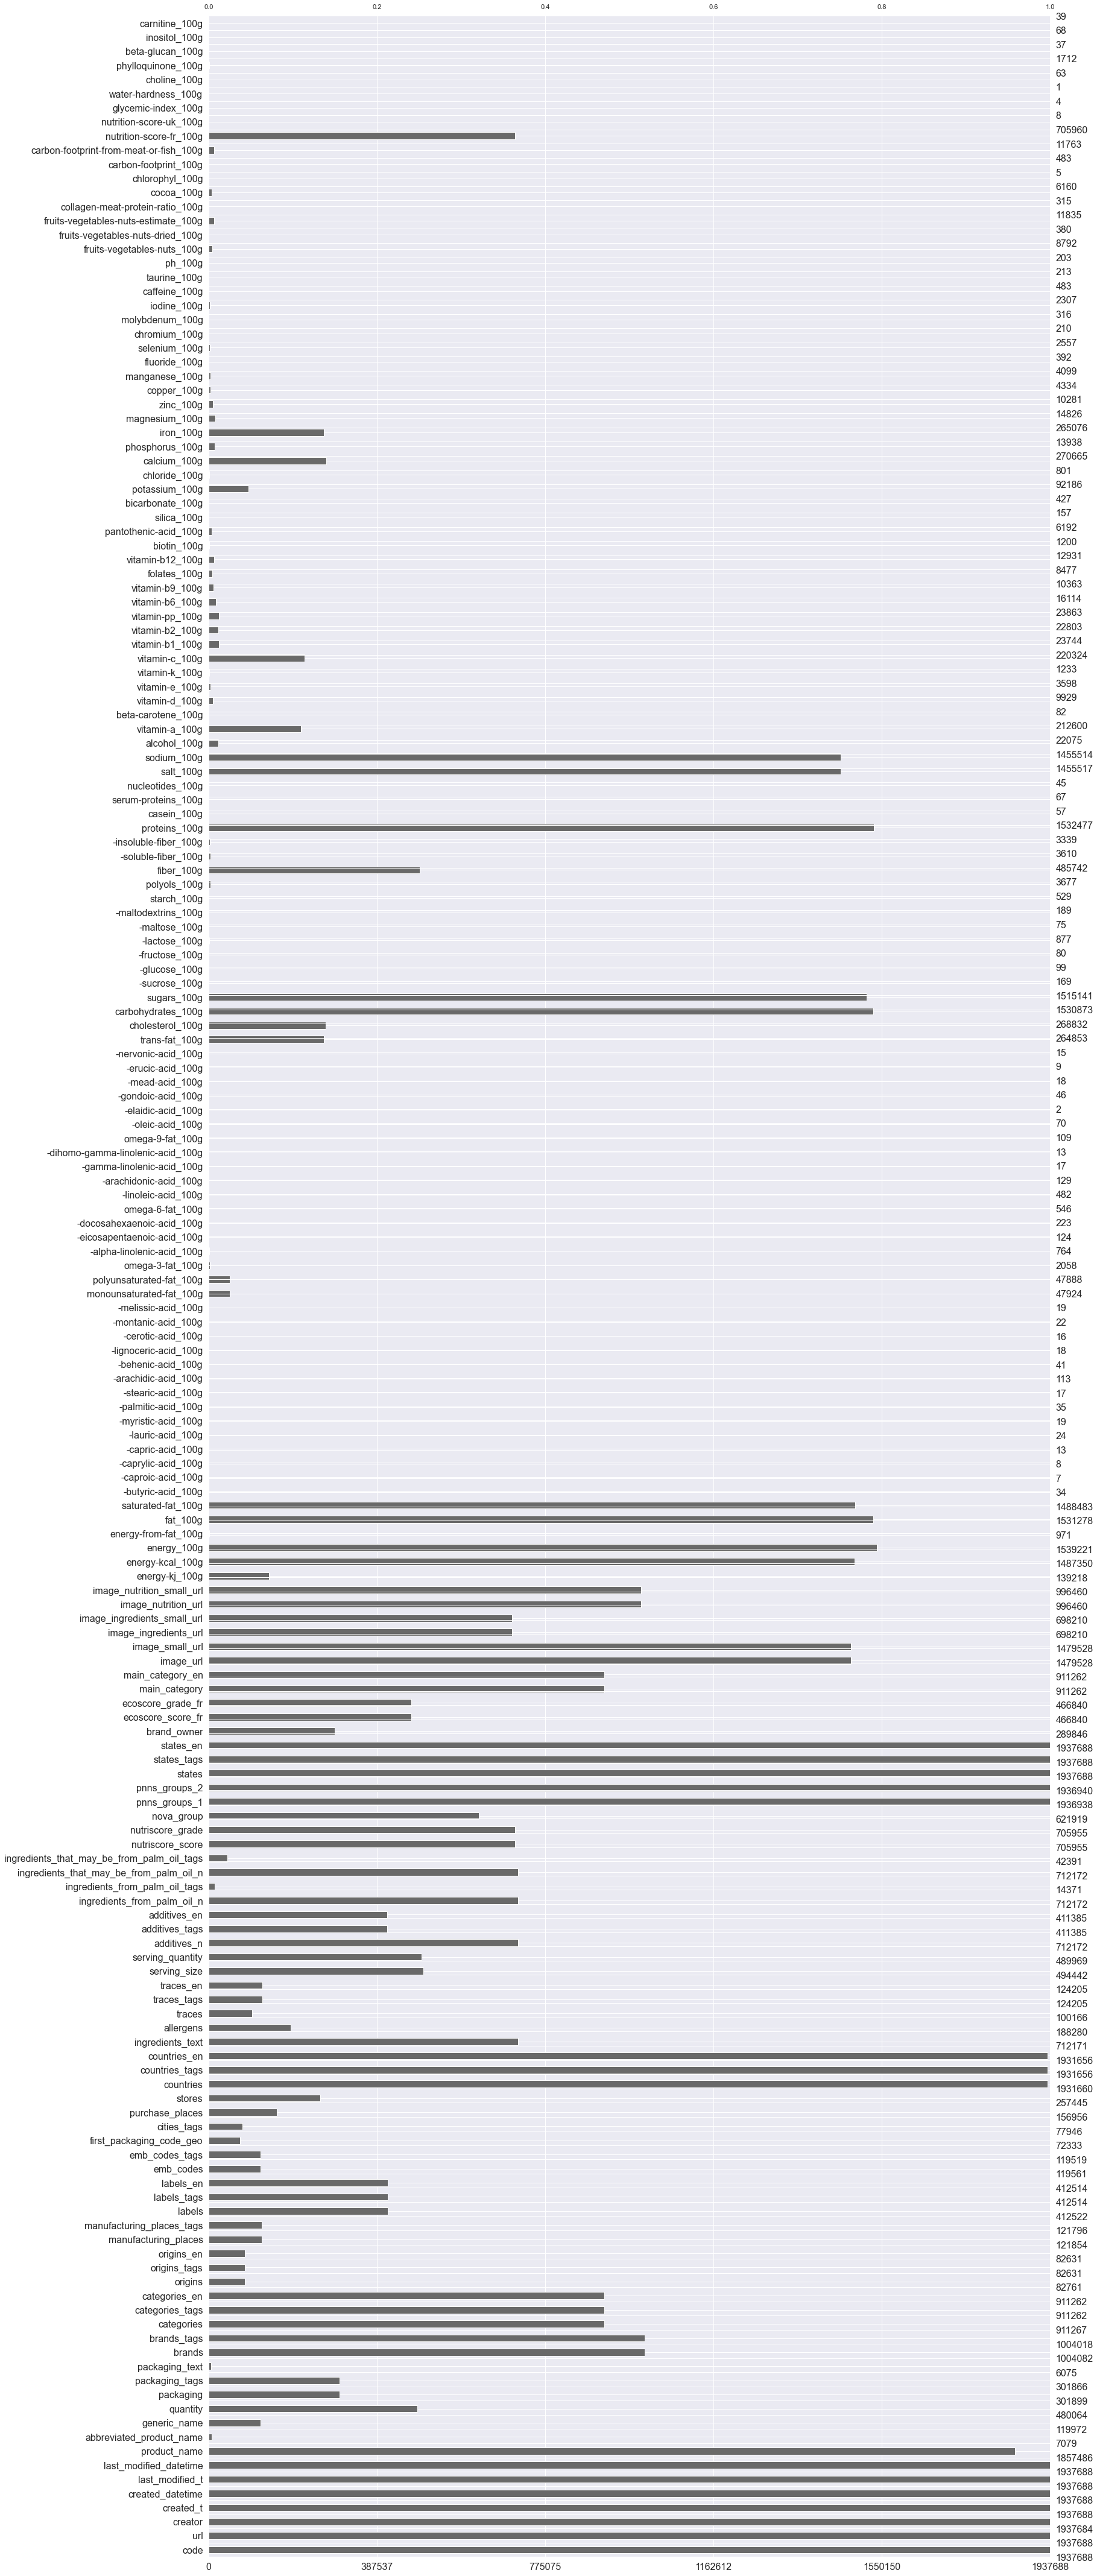

In [102]:
# Check missing values
msno.bar(df_products)

# Data cleaning

## 1. Functional cleaning 

180 columns
1937688 rows
Rate of missing values in df : 79.09635606970785 %


<AxesSubplot:>

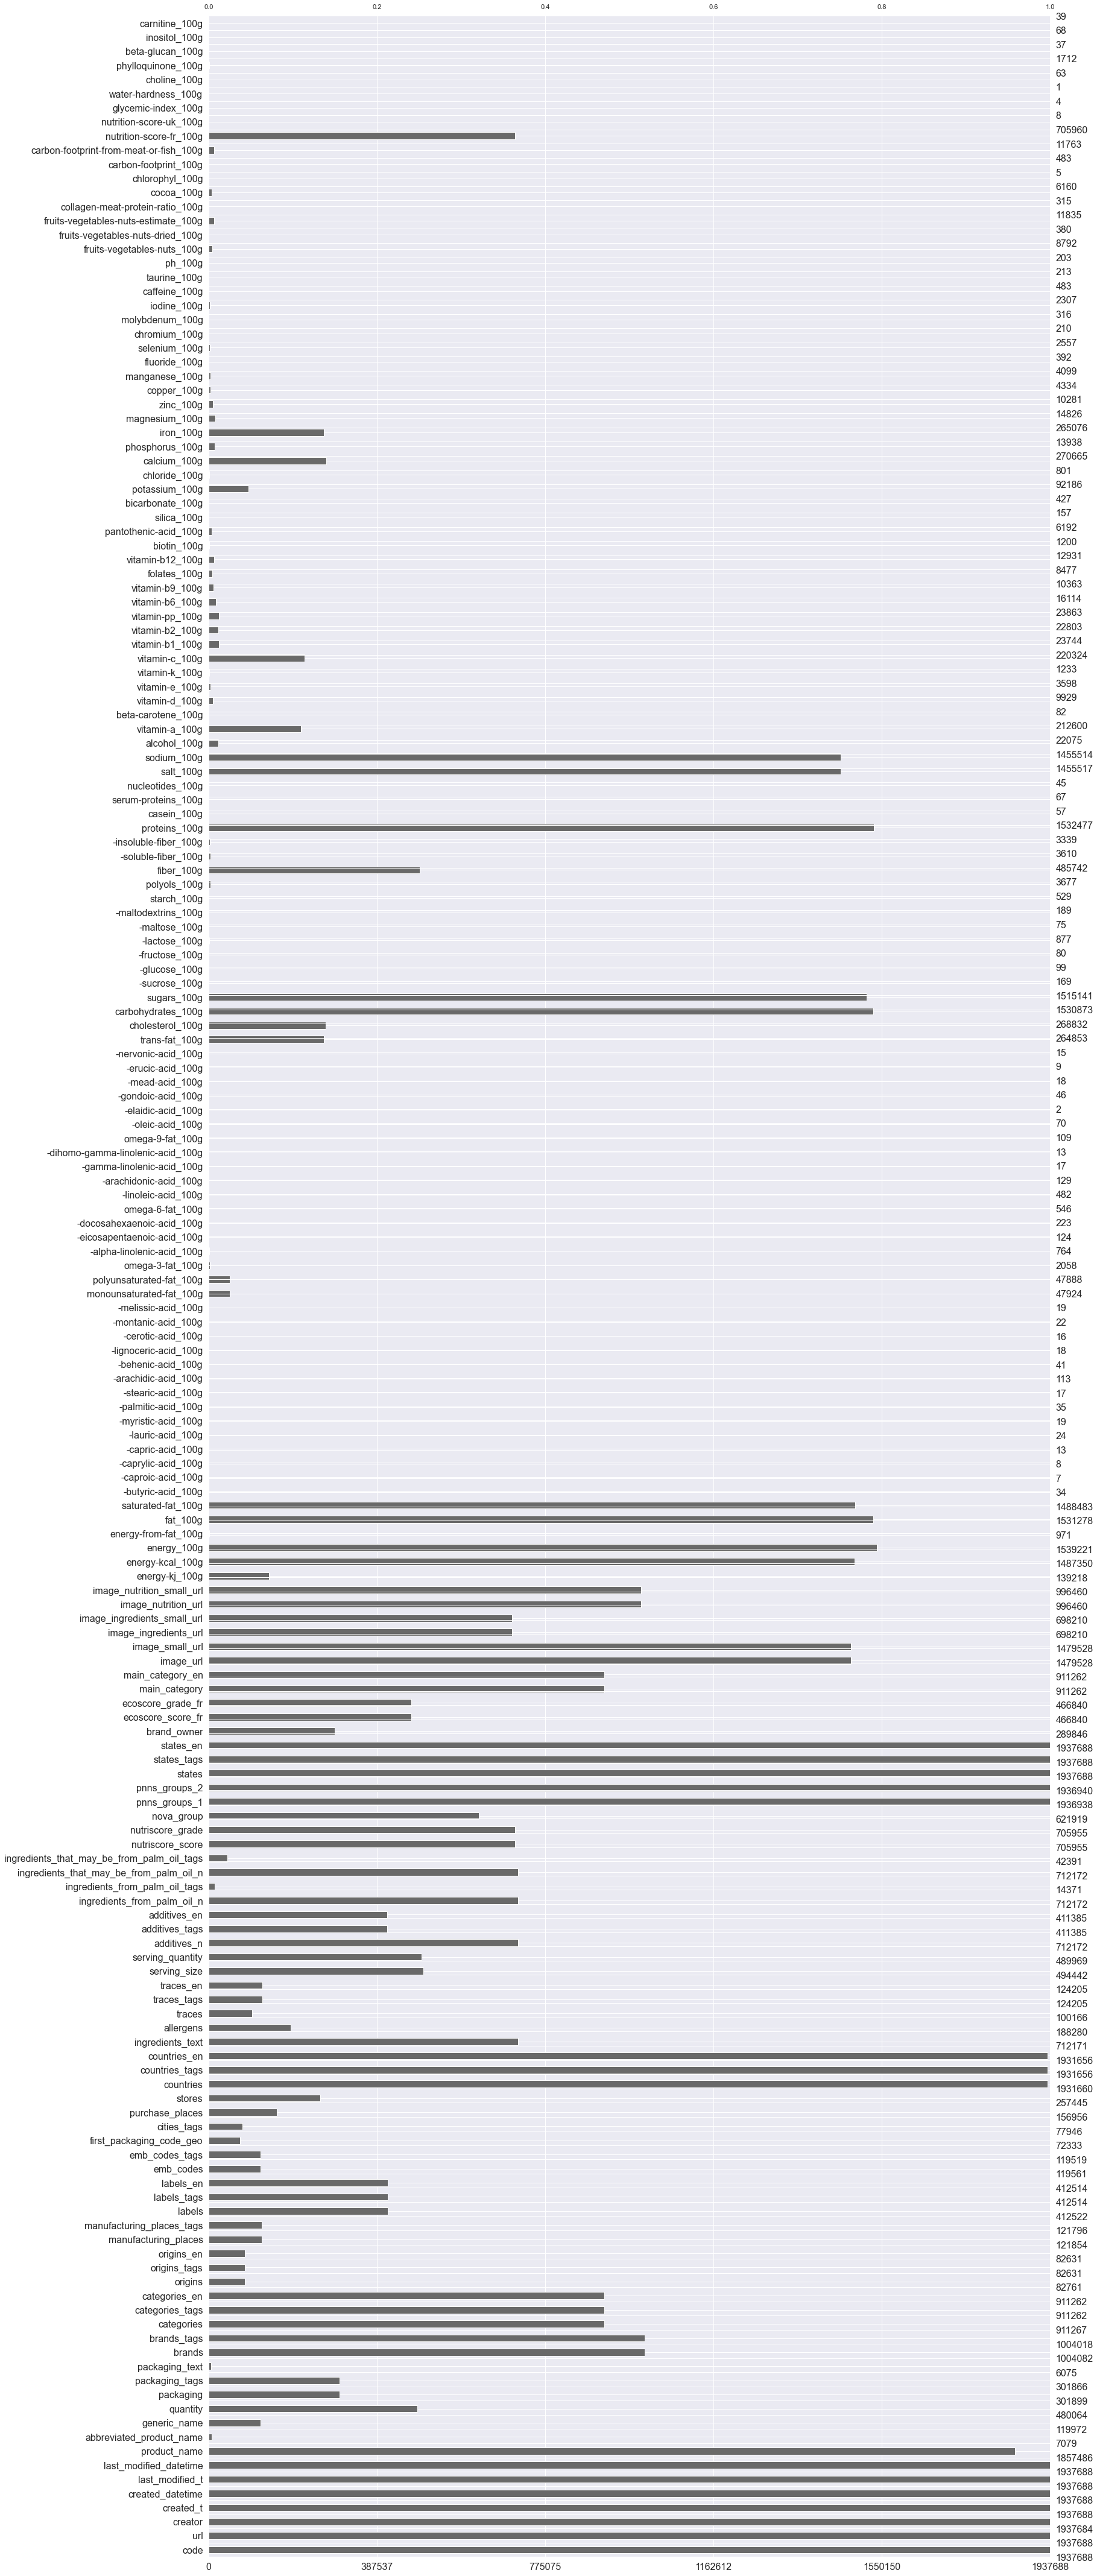

In [103]:
# Drop empty columns and rows 
df_products.dropna(axis=1, how="all", thresh=None, subset=None, inplace=True)
df_products.dropna(axis=0, how="all", thresh=None, subset=None, inplace=True)

# Show parameters
info(df_products)

# Check missing values
msno.bar(df_products)

### a. Indicators analysis

In [104]:
# Analysis of "serving" related variables 
# indicator_search_regex is defined in utils.py
search_countries_serving = indicator_search_regex(df_products, "serving") 

# Show
search_countries_serving

['serving_size', 'serving_quantity']

In [105]:
# Checking the rate of missong values for each variable related to "serving" keyword
for variable in search_countries_serving:
    print(variable + ", missing values: " + str(df_products[variable].isnull().mean()*100) + " %")
 

serving_size, missing values: 74.48288888613646 %
serving_quantity, missing values: 74.71373100313363 %


<AxesSubplot:>

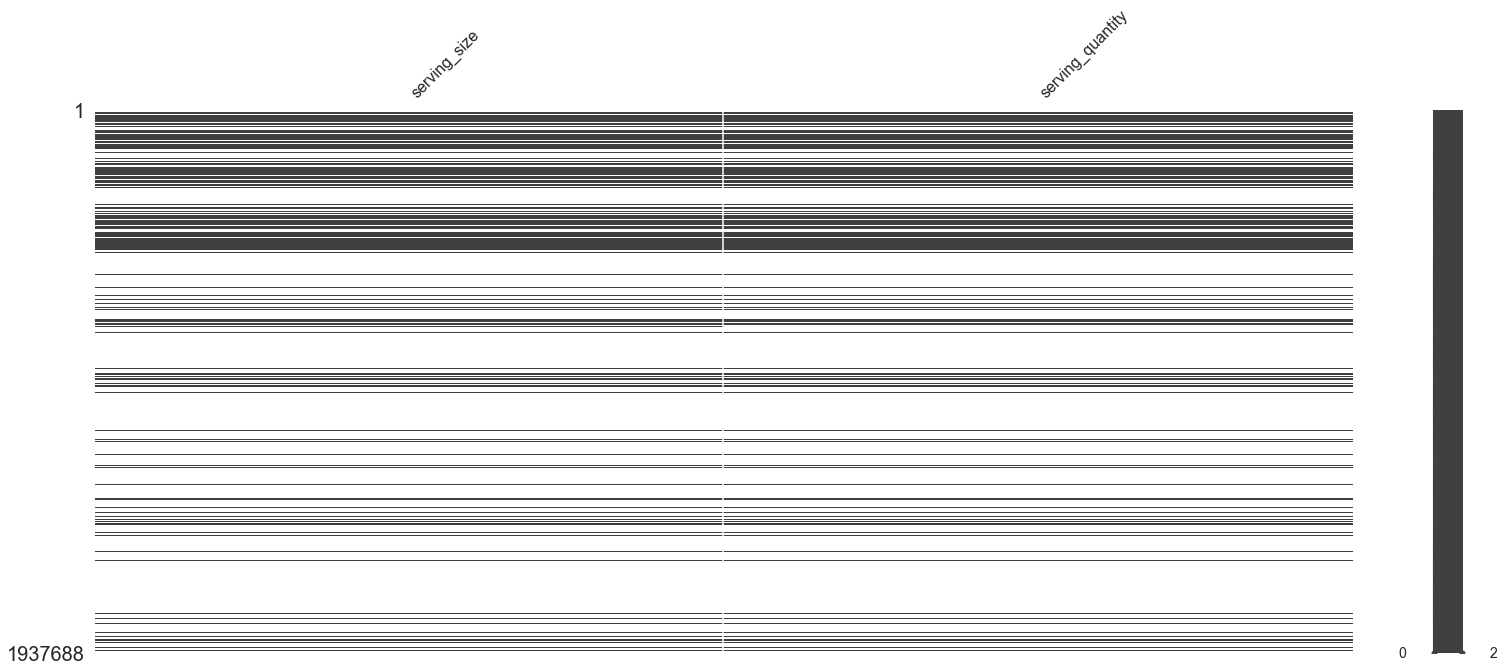

In [106]:
# Display the repartition of missing values
msno.matrix(df_products[search_countries_serving])

In [107]:
# Both variable have the exact same missing values repartition. We will pick 'countries' variable for simplicity sake (name)
# We might pick any of those variables 

In [108]:
# Analysis  of "countries" related variables 
# indicator_search_regex() is defined in utils.py
search_countries = indicator_search_regex(df_products, "countries")

# Show
search_countries


['countries', 'countries_tags', 'countries_en']

In [109]:
# Checking the rate of missong values for each variable related to "countries" keyword
for variable in search_countries:
    print(variable + ", missing values: " + str(df_products[variable].isnull().mean()*100) + " %")
 

countries, missing values: 0.31109239464764193 %
countries_tags, missing values: 0.3112988262300226 %
countries_en, missing values: 0.3112988262300226 %


<AxesSubplot:>

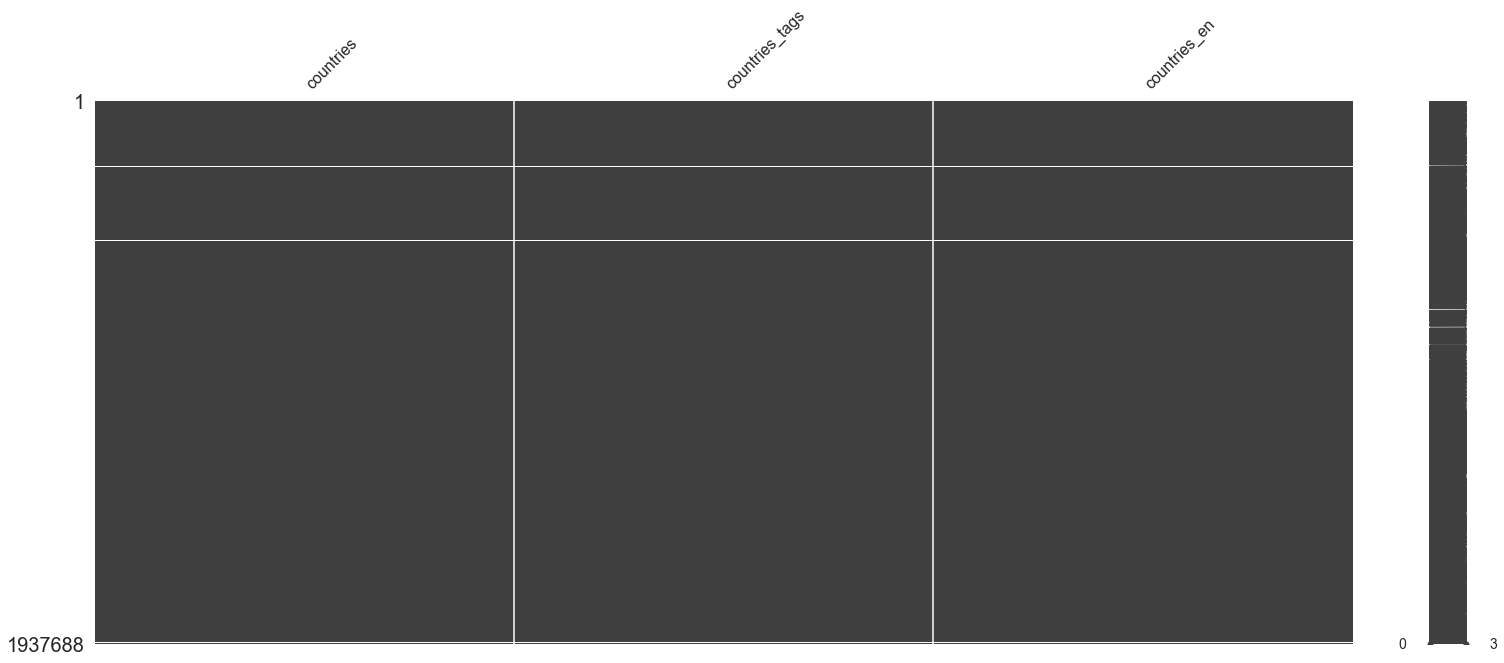

In [110]:
# Display the repartition of missing values
msno.matrix(df_products[search_countries])

In [111]:
# All variable have the exact same missing values repartition. We will pick 'countries' variable for simplicity sake (name)

In [112]:
# Analysis of "energy" related variables 
# indicator_search_regex() is defined in utils.py
search_energy = indicator_search_regex(df_products, "energy")

# Show
search_energy


['energy-kj_100g', 'energy-kcal_100g', 'energy_100g', 'energy-from-fat_100g']

In [113]:
# Checking the rate of missong values for each variable related to "countries" keyword
for variable in search_energy:
    print(variable + ", missing values: " + str(df_products[variable].isnull().mean()*100) + " %")
    

energy-kj_100g, missing values: 92.81525199103261 %
energy-kcal_100g, missing values: 23.240996486534467 %
energy_100g, missing values: 20.564043334117773 %
energy-from-fat_100g, missing values: 99.94988873337711 %


<AxesSubplot:>

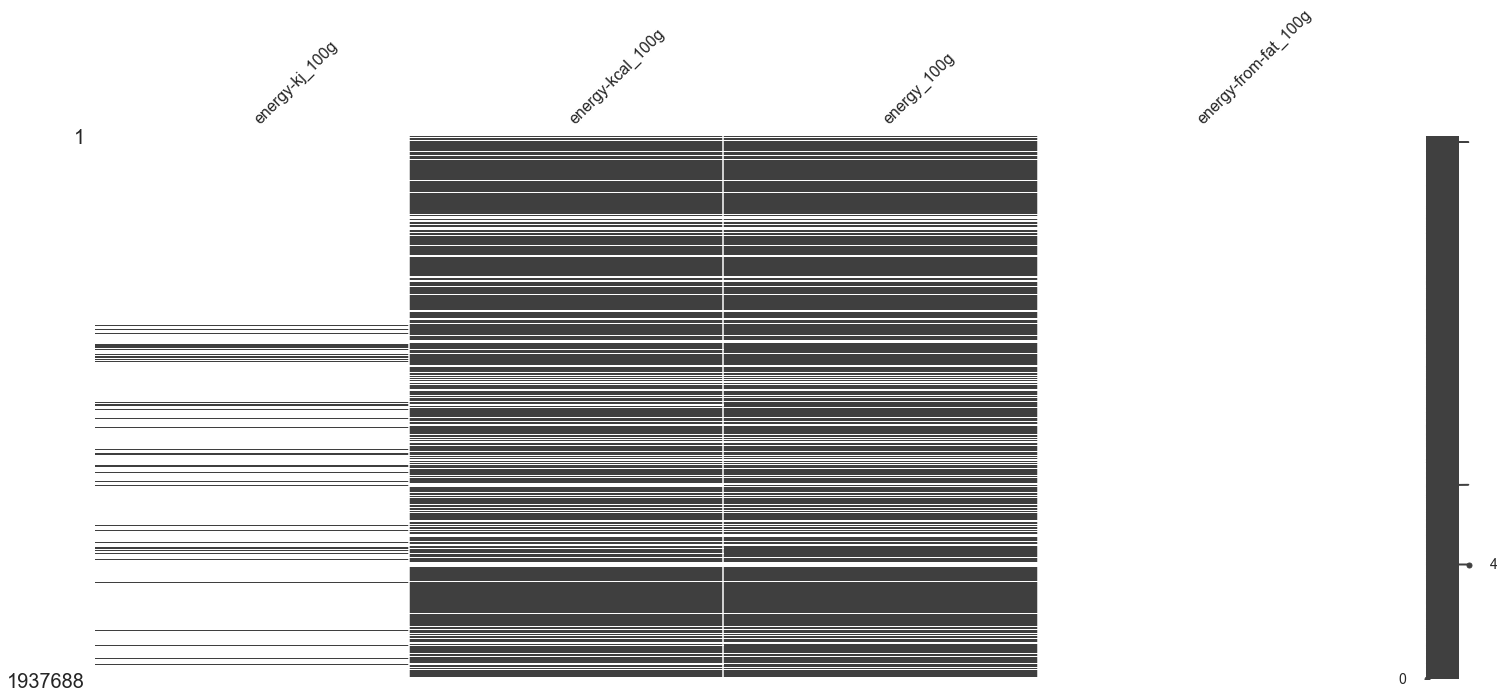

In [114]:
# Display the repartition of missing values
msno.matrix(df_products[search_energy])

In [115]:
# Both 'energy-kcal_100g' and 'energy_100g' are highly and seemingly populated. We will retain 'energy-kcal_100g' as this variable is more commonly used 

In [116]:
# "Fat" related variables analysis
# indicator_search_regex() is defined in utils.py
search_fat = indicator_search_regex(df_products, "fat")
search_fat

['energy-from-fat_100g',
 'fat_100g',
 'saturated-fat_100g',
 'monounsaturated-fat_100g',
 'polyunsaturated-fat_100g',
 'omega-3-fat_100g',
 'omega-6-fat_100g',
 'omega-9-fat_100g',
 'trans-fat_100g']

In [117]:
# Checking the rate of missong values for each variable related to "countries" keyword
for variable in search_fat:
    print(variable + ", missing values: " + str(df_products[variable].isnull().mean()*100) + " %")

energy-from-fat_100g, missing values: 99.94988873337711 %
fat_100g, missing values: 20.97396484883015 %
saturated-fat_100g, missing values: 23.182524740825148 %
monounsaturated-fat_100g, missing values: 97.52674321149742 %
polyunsaturated-fat_100g, missing values: 97.52860109573885 %
omega-3-fat_100g, missing values: 99.89379095086515 %
omega-6-fat_100g, missing values: 99.97182208900503 %
omega-9-fat_100g, missing values: 99.99437473938013 %
trans-fat_100g, missing values: 86.33149402793433 %


<AxesSubplot:>

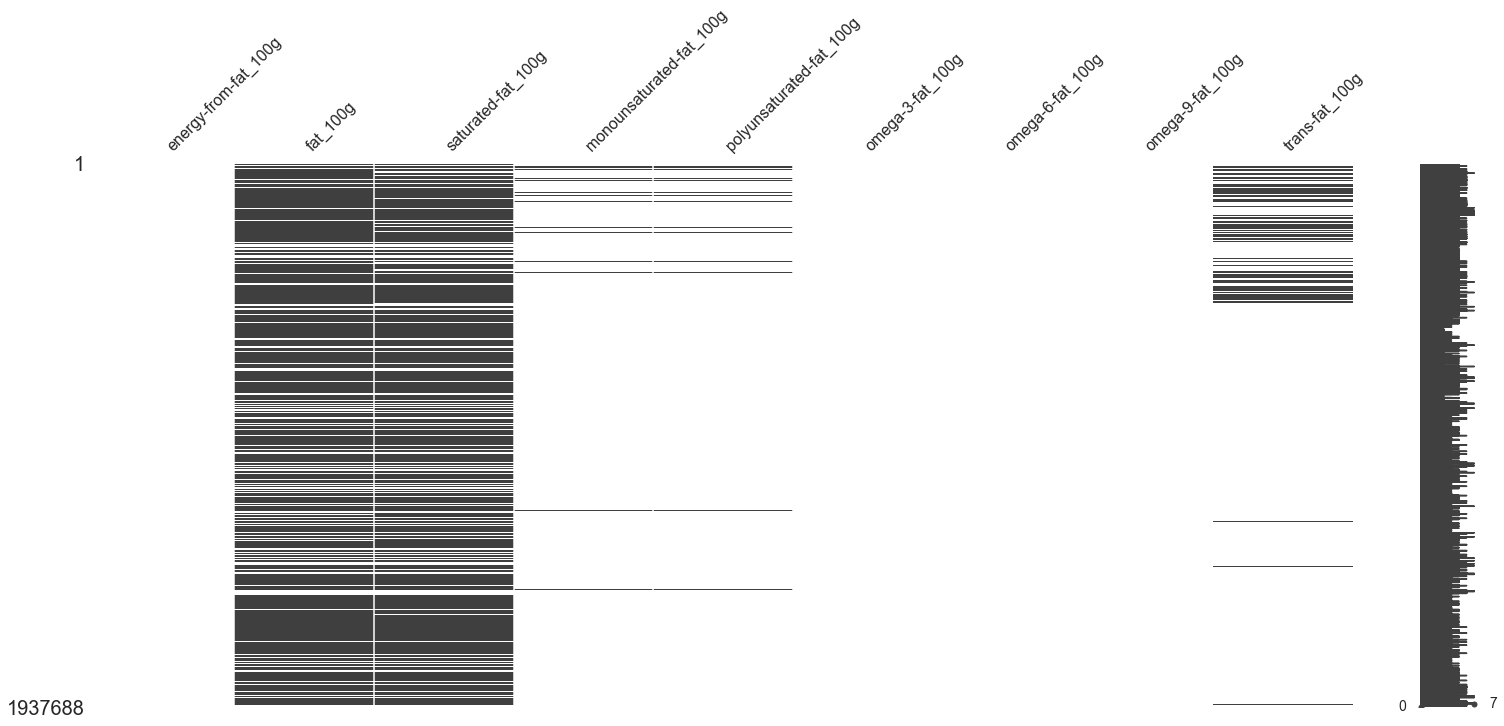

In [118]:
# Display the repartition of missing values
msno.matrix(df_products[search_fat])

In [119]:
# Both 'fatl_100g' and 'saturated_fat_100g' are higly and seemingly populated
# We will pick both as both are common in nutrition facts

In [120]:
# "Nutriscore" related variables analysis
# indicator_search_regex() is defined in utils.py
search_nutriscore = indicator_search_regex(df_products, "nutriscore") 

In [121]:
# Checking the rate of missong values for each variable related to "countries" keyword
for variable in search_nutriscore:
    print(variable + ", missing values: " + str(df_products[variable].isnull().mean()*100) + " %")

nutriscore_score, missing values: 63.567148065116776 %
nutriscore_grade, missing values: 63.567148065116776 %


<AxesSubplot:>

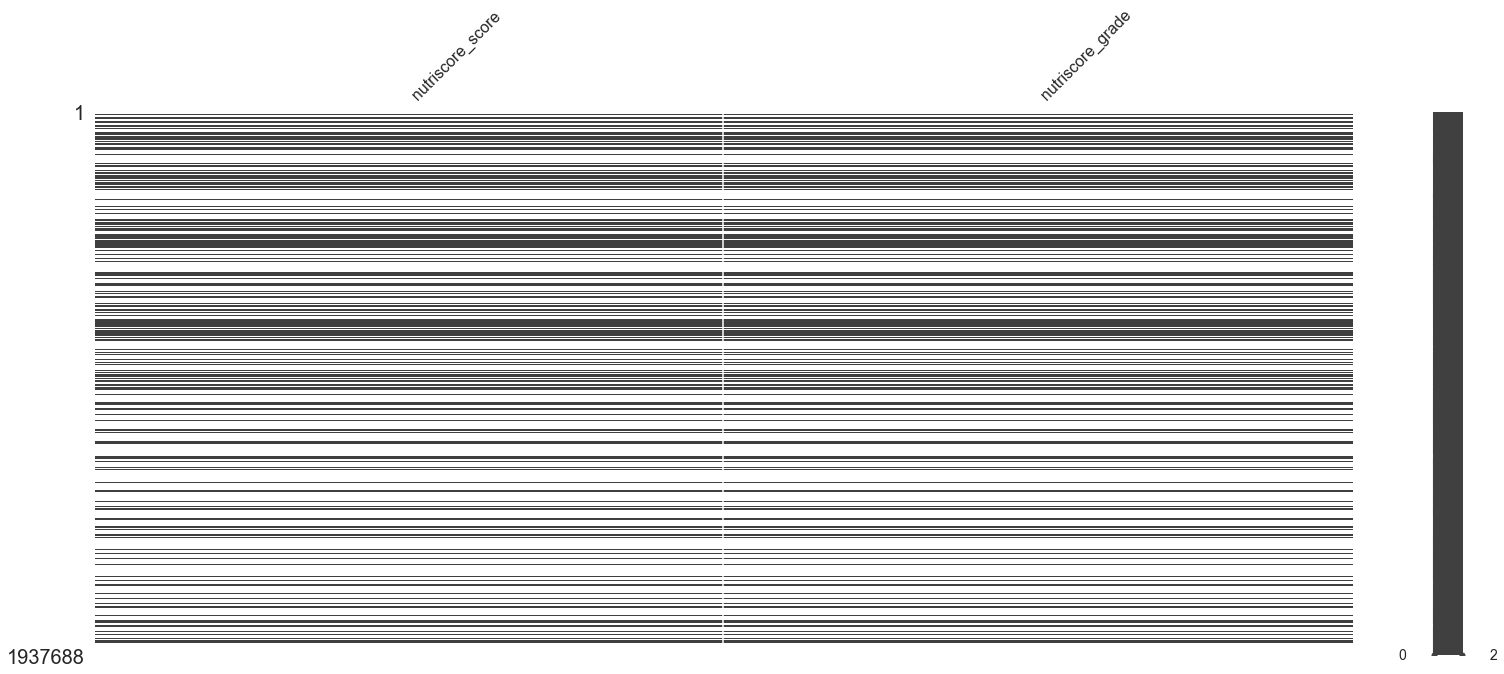

In [122]:
# Display the repartition of missing values
msno.matrix(df_products[search_nutriscore])

In [123]:
# Both 'nutriscore_grade' and 'nutriscore_score' are seemingly populated
# We will pick the categorial variable nutriscore_grade

### b. Indicators selection

In [124]:
# indicator_search_regex() is defined in utils.py
search_100g = indicator_search_regex(df_products, "_100g") 

# Display
search_100g

['energy-kj_100g',
 'energy-kcal_100g',
 'energy_100g',
 'energy-from-fat_100g',
 'fat_100g',
 'saturated-fat_100g',
 '-butyric-acid_100g',
 '-caproic-acid_100g',
 '-caprylic-acid_100g',
 '-capric-acid_100g',
 '-lauric-acid_100g',
 '-myristic-acid_100g',
 '-palmitic-acid_100g',
 '-stearic-acid_100g',
 '-arachidic-acid_100g',
 '-behenic-acid_100g',
 '-lignoceric-acid_100g',
 '-cerotic-acid_100g',
 '-montanic-acid_100g',
 '-melissic-acid_100g',
 'monounsaturated-fat_100g',
 'polyunsaturated-fat_100g',
 'omega-3-fat_100g',
 '-alpha-linolenic-acid_100g',
 '-eicosapentaenoic-acid_100g',
 '-docosahexaenoic-acid_100g',
 'omega-6-fat_100g',
 '-linoleic-acid_100g',
 '-arachidonic-acid_100g',
 '-gamma-linolenic-acid_100g',
 '-dihomo-gamma-linolenic-acid_100g',
 'omega-9-fat_100g',
 '-oleic-acid_100g',
 '-elaidic-acid_100g',
 '-gondoic-acid_100g',
 '-mead-acid_100g',
 '-erucic-acid_100g',
 '-nervonic-acid_100g',
 'trans-fat_100g',
 'cholesterol_100g',
 'carbohydrates_100g',
 'sugars_100g',
 '-suc

<AxesSubplot:>

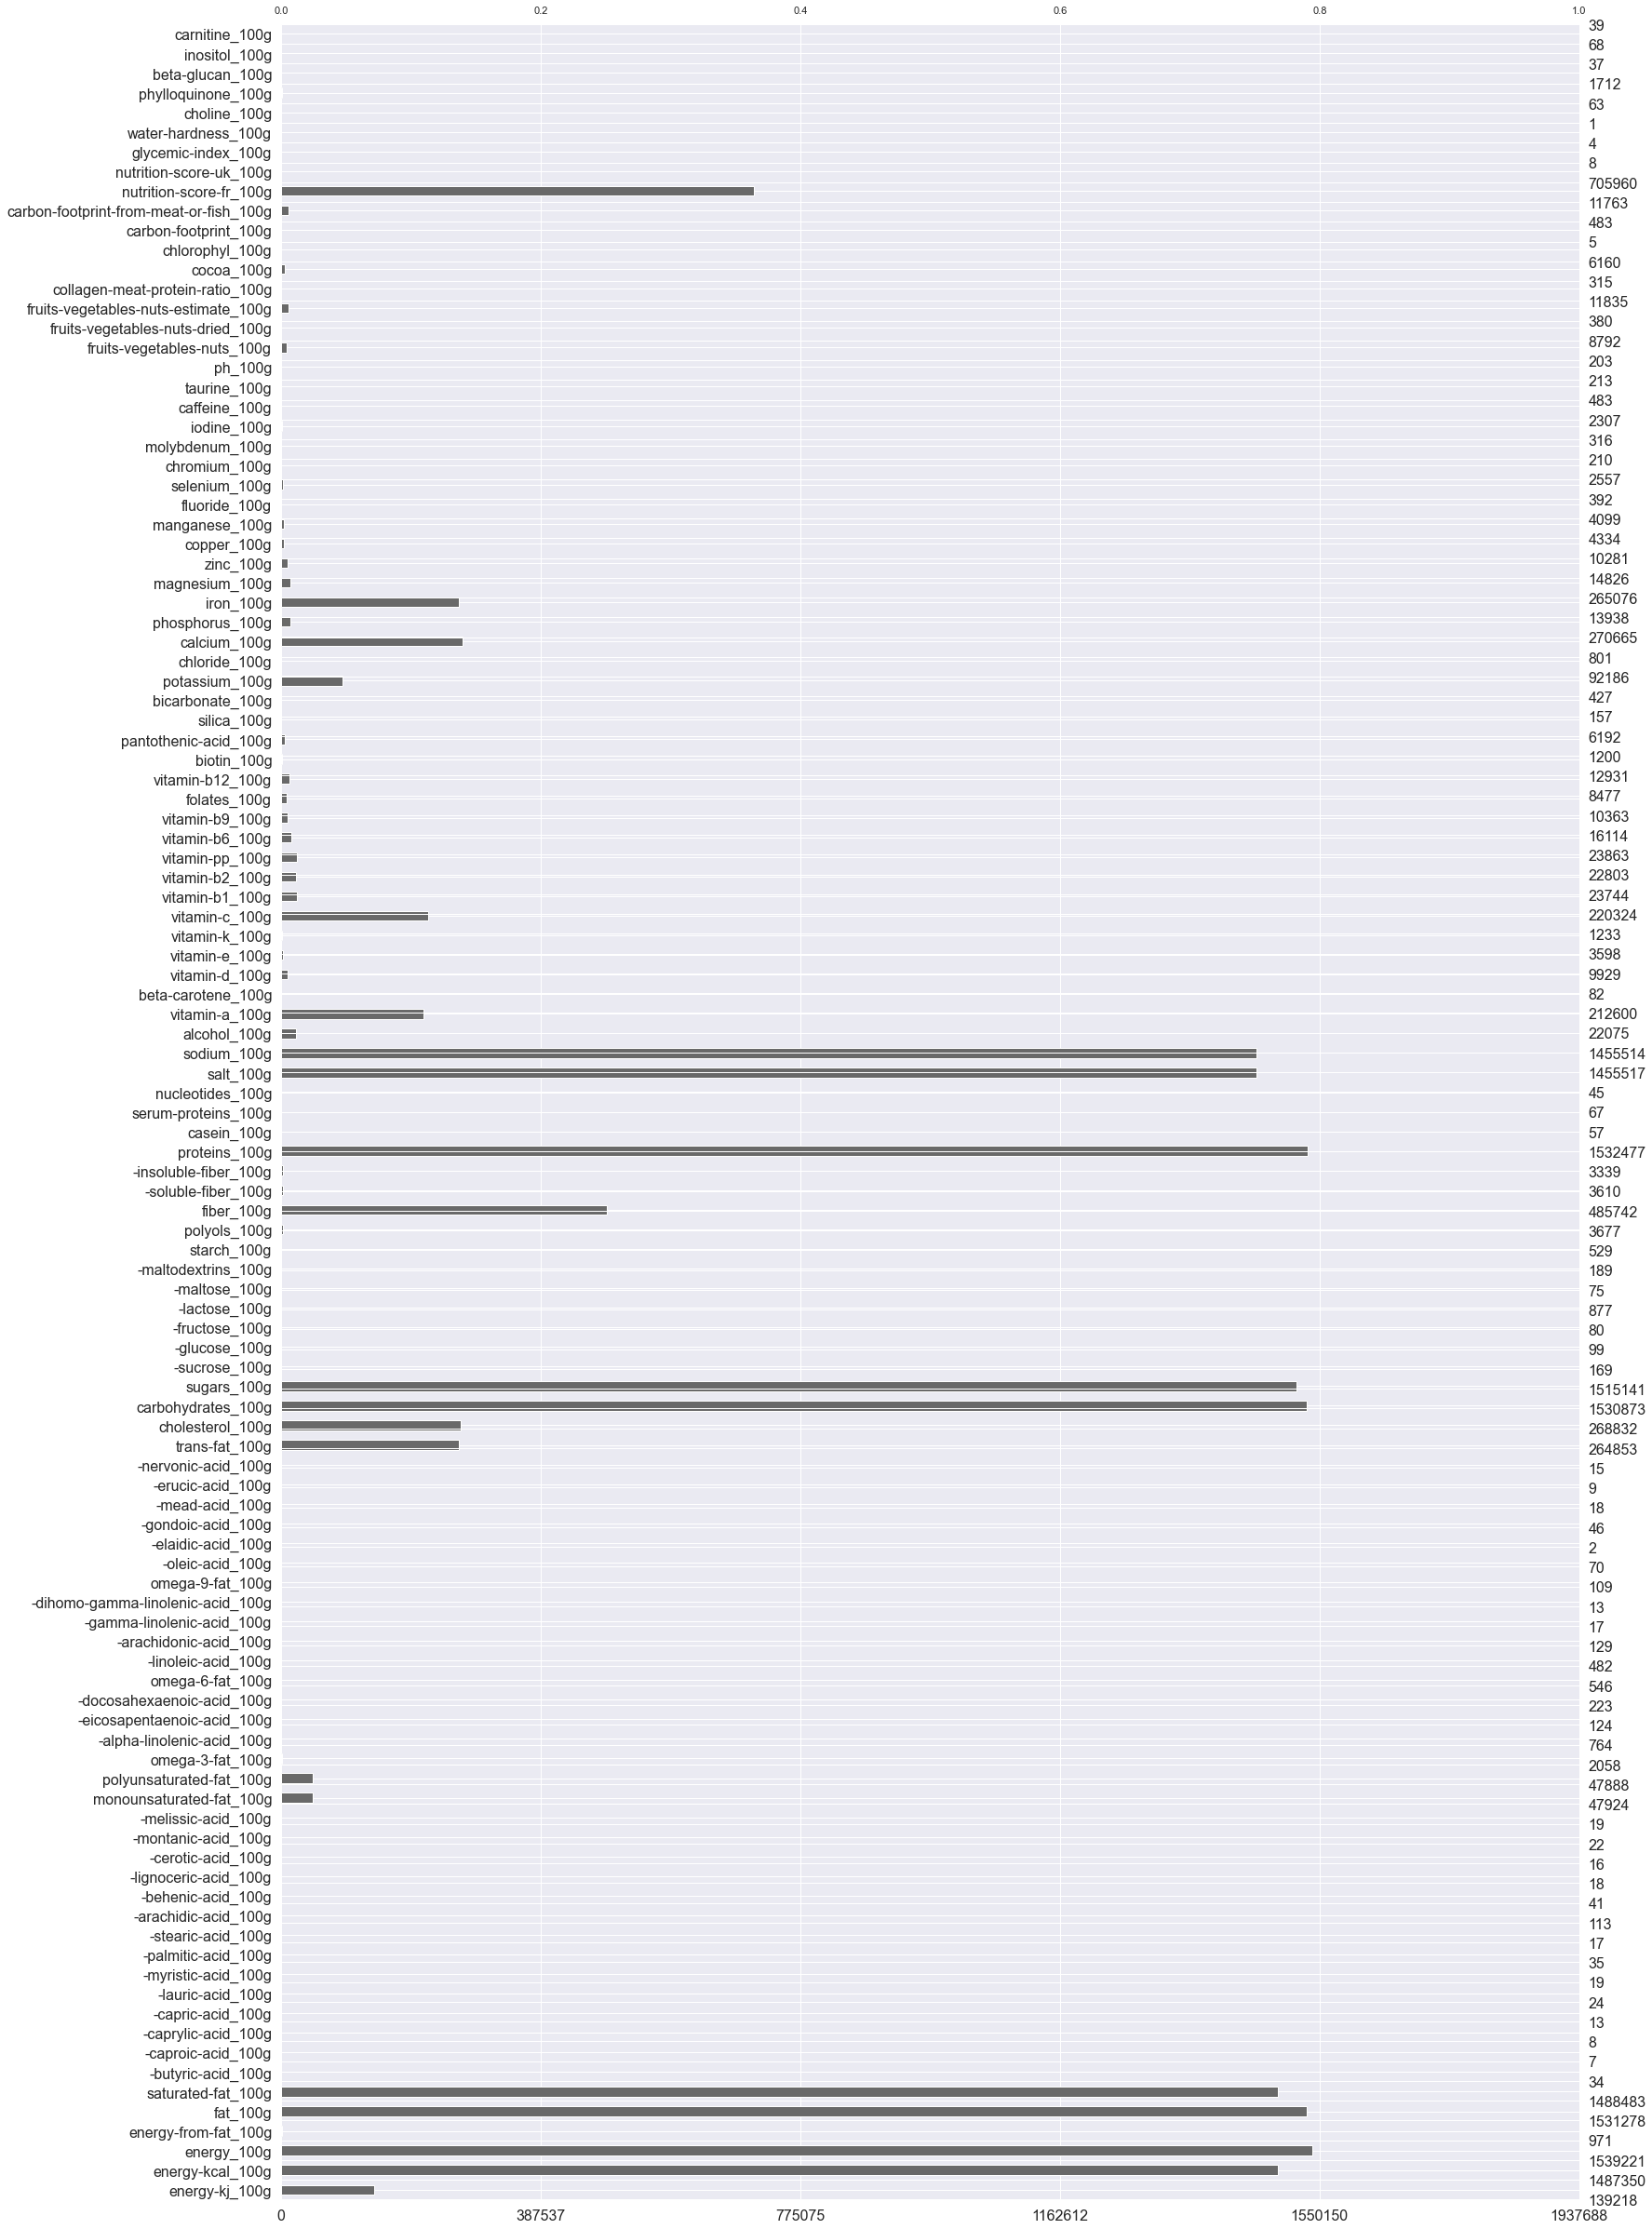

In [125]:
# Check missing data
msno.bar(df_products[search_100g])

In [126]:
# Selected variables
list_indicators = ['code',
                   'product_name',
                   'brands',
                   'countries',          
                   'energy-kcal_100g',
                   'proteins_100g',
                   'carbohydrates_100g',
                   'fat_100g',
                   'saturated-fat_100g',                 
                   'sugars_100g',
                   'salt_100g',
                   'fiber_100g',
                   'calcium_100g',
                   'magnesium_100g',
                   'potassium_100g',
                   'iron_100g',
                   'vitamin-a_100g',
                   'vitamin-d_100g',
                   'vitamin-b9_100g',
                   'vitamin-c_100g',
                   'nutriscore_grade'
                   ]

# Filtering by selected variables
df_products_select = df_products[list_indicators]

# Show
df_products_select

code                            product_name  \
0           00000000000000225                          jeunes pousses   
1        00000000000003429145                                 L.casei   
2               0000000000017                        Vitória crackers   
3               0000000000031                                   Cacao   
4          000000000003327986               Filetes de pollo empanado   
...                       ...                                     ...   
1937683         9999999910128  Sandwich club Rillette poisson combava   
1937684             999999999                 Thé noir BIO Darjeeling   
1937685         9999999990397                                    Fati   
1937686         9999999999994               Light & Free SKYR A BOIRE   
1937687       999999999999999                       Signal Toothpaste   

          brands  countries  energy-kcal_100g  proteins_100g  \
0        endives  en:france               NaN            NaN   
1            NaN      Spain               NaN            2.7   
2            NaN     France             375.0            7.8   
3            NaN     France               NaN            NaN   
4            NaN    Espagne             163.9           15.3   
...          ...        ...               ...            ...   
1937683      NaN      en:re               NaN            NaN   
1937684    Pagès  en:france               NaN            NaN   
1937685      NaN      en:be              24.0            1.6   
1937686      NaN  en:france               0.0            5.5   
1937687      NaN     France               NaN            NaN   

         carbohydrates_100g  fat_100g  saturated-fat_100g  sugars_100g  \
0                       NaN       NaN                 NaN          NaN   
1                       9.8       1.4                0.90          9.8   
2                      70.1       7.0                3.08         15.0   
3                       NaN       NaN                 NaN          NaN   
4                       NaN       1.9                1.00          NaN   
...                     ...       ...                 ...          ...   
1937683                 NaN       NaN                 NaN          NaN   
1937684                 NaN       NaN                 NaN          NaN   
1937685                 2.4       0.3                0.00          0.6   
1937686                 8.0       0.2                0.10          7.8   
1937687                 NaN       NaN                 NaN          NaN   

         salt_100g  fiber_100g  calcium_100g  magnesium_100g  potassium_100g  \
0              NaN         NaN           NaN             NaN             NaN   
1             0.10         NaN           NaN             NaN             NaN   
2             1.40         NaN           NaN             NaN             NaN   
3              NaN         NaN           NaN             NaN             NaN   
4             1.10         NaN           NaN             NaN             NaN   
...            ...         ...           ...             ...             ...   
1937683        NaN         NaN           NaN             NaN             NaN   
1937684        NaN         NaN           NaN             NaN             NaN   
1937685       0.64         NaN           NaN             NaN             NaN   
1937686       0.15         NaN           NaN             NaN             NaN   
1937687        NaN         NaN           NaN             NaN             NaN   

         iron_100g  vitamin-a_100g  vitamin-d_100g  vitamin-b9_100g  \
0              NaN             NaN             NaN              NaN   
1              NaN             NaN             NaN              NaN   
2              NaN             NaN             NaN              NaN   
3              NaN             NaN             NaN              NaN   
4              NaN             NaN             NaN              NaN   
...            ...             ...             ...              ...   
1937683        NaN             N

<AxesSubplot:>

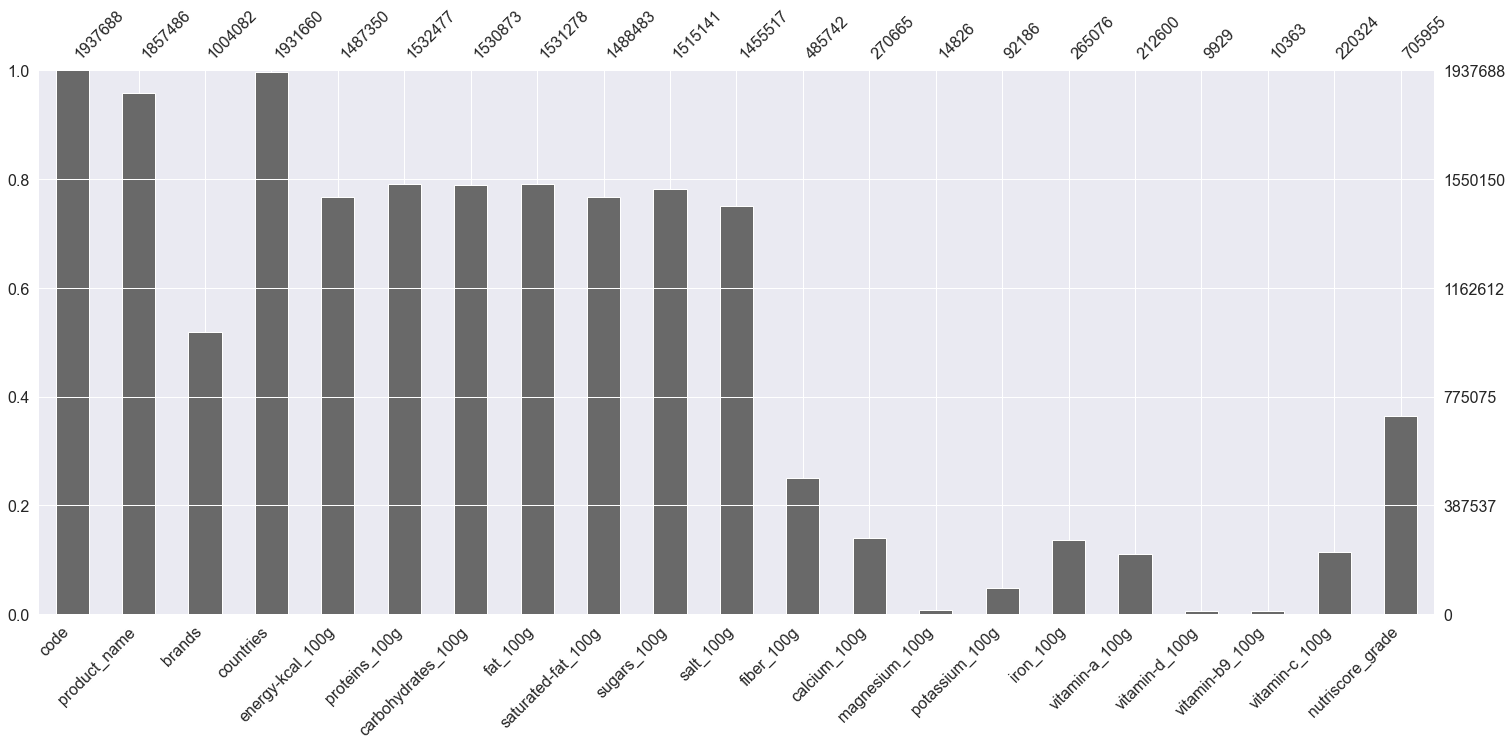

In [127]:
# Check missing values
msno.bar(df_products_select)


### c. Filtering by countries: France

In [128]:
# Filter for list of tuples containing "fra" for France
df_products_select = df_products_select[df_products_select.countries.str.contains("fra", case=False, na=False)]

# Dismiss duplicated products
df_products_select.drop_duplicates("code")

# Show
df_products_select

code                  product_name         brands  \
0           00000000000000225                jeunes pousses        endives   
2               0000000000017              Vitória crackers            NaN   
3               0000000000031                         Cacao            NaN   
6               0000000000100   moutarde au moût de raisin   courte paille   
7        00000000001111111111                       Sfiudwx           Watt   
...                       ...                           ...            ...   
1937677         9999999004360                Minis beignets            NaN   
1937680              99999995                    Faux filet            NaN   
1937684             999999999       Thé noir BIO Darjeeling          Pagès   
1937686         9999999999994     Light & Free SKYR A BOIRE            NaN   
1937687       999999999999999             Signal Toothpaste            NaN   

         countries  energy-kcal_100g  proteins_100g  carbohydrates_100g  \
0        en:france               NaN            NaN                 NaN   
2           France             375.0            7.8                70.1   
3           France               NaN            NaN                 NaN   
6           France               NaN            5.1                29.0   
7        en:France               NaN            NaN                 NaN   
...            ...               ...            ...                 ...   
1937677     France             333.0            7.4                30.9   
1937680     France             131.0           21.5                 0.0   
1937684  en:france               NaN            NaN                 NaN   
1937686  en:france               0.0            5.5                 8.0   
1937687     France               NaN            NaN                 NaN   

         fat_100g  saturated-fat_100g  sugars_100g  salt_100g  fiber_100g  \
0             NaN                 NaN          NaN        NaN         NaN   
2             7.0                3.08         15.0       1.40         NaN   
3             NaN                 NaN          NaN        NaN         NaN   
6             8.2                2.20         22.0       4.60         0.0   
7             NaN                 NaN          NaN        NaN         NaN   
...           ...                 ...          ...        ...         ...   
1937677      20.2                6.00         10.4       1.10         NaN   
1937680       5.0                2.30          0.0       0.18         NaN   
1937684       NaN                 NaN          NaN        NaN         NaN   
1937686       0.2                0.10          7.8       0.15         NaN   
1937687       NaN                 NaN          NaN        NaN         NaN   

         calcium_100g  magnesium_100g  potassium_100g  iron_100g  \
0                 NaN             NaN             NaN        NaN   
2                 NaN             NaN             NaN        NaN   
3                 NaN             NaN             NaN        NaN   
6                 NaN             NaN             NaN        NaN   
7                 NaN             NaN             NaN        NaN   
...               ...             ...             ...        ...   
1937677           NaN             NaN             NaN        NaN   
1937680           NaN             NaN             NaN        NaN   
1937684           NaN             NaN             NaN        NaN   
1937686           NaN             NaN             NaN        NaN   
1937687           NaN             NaN             NaN        NaN   

         vitamin-a_100g  vitamin-d_100g  vitamin-b9_100g  vitamin-c_100g  \
0                   NaN             NaN              NaN             NaN   
2                   NaN             NaN              NaN             NaN   
3                   NaN             NaN              NaN             NaN   
6                   NaN             NaN              NaN             NaN   
7                   NaN             NaN              NaN         

21 columns
606673 rows
Rate of missing values in df : 52.88167713790743 %


<AxesSubplot:>

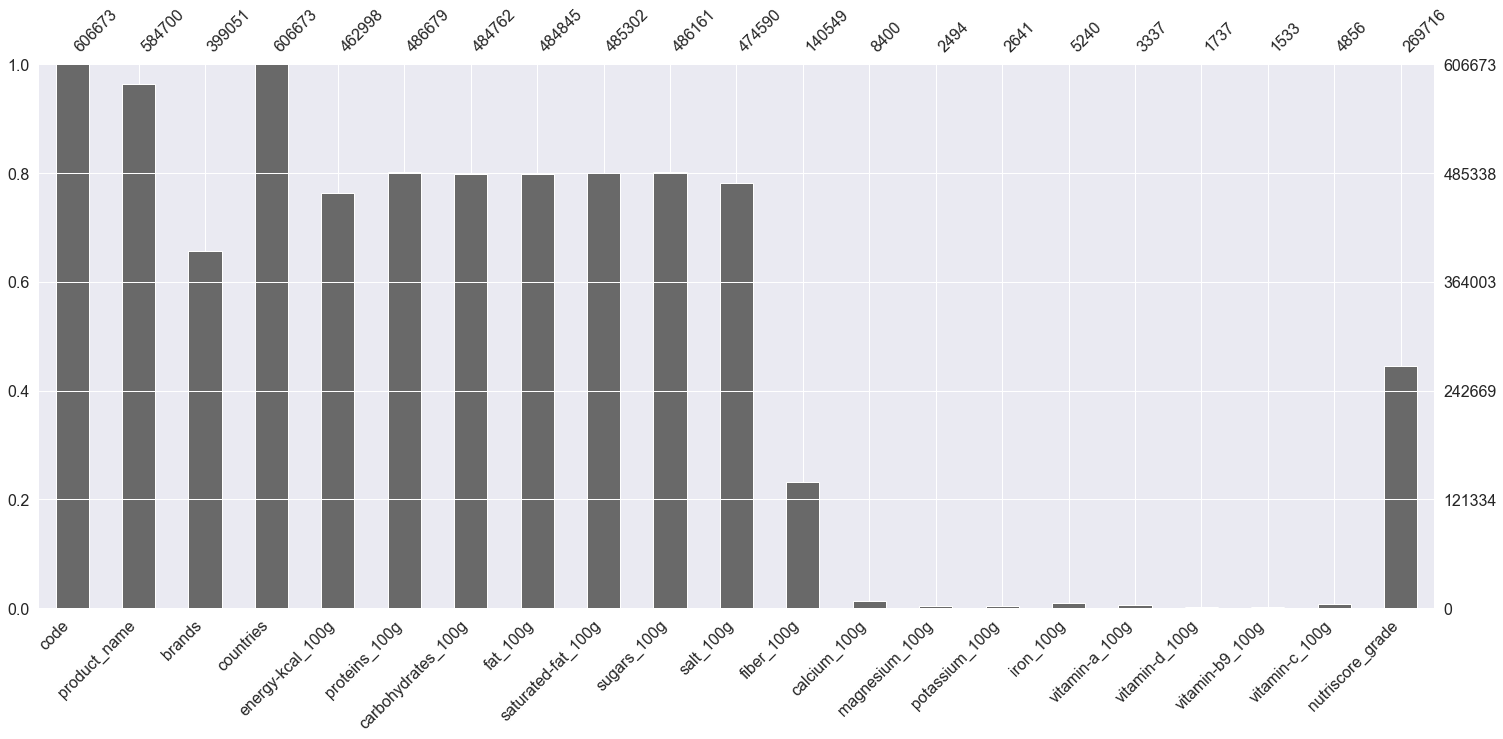

In [129]:
# Check rate of missing values
info(df_products_select)

# Check missing data after filtering by country
msno.bar(df_products_select) 

### d. Index setting

<AxesSubplot:>

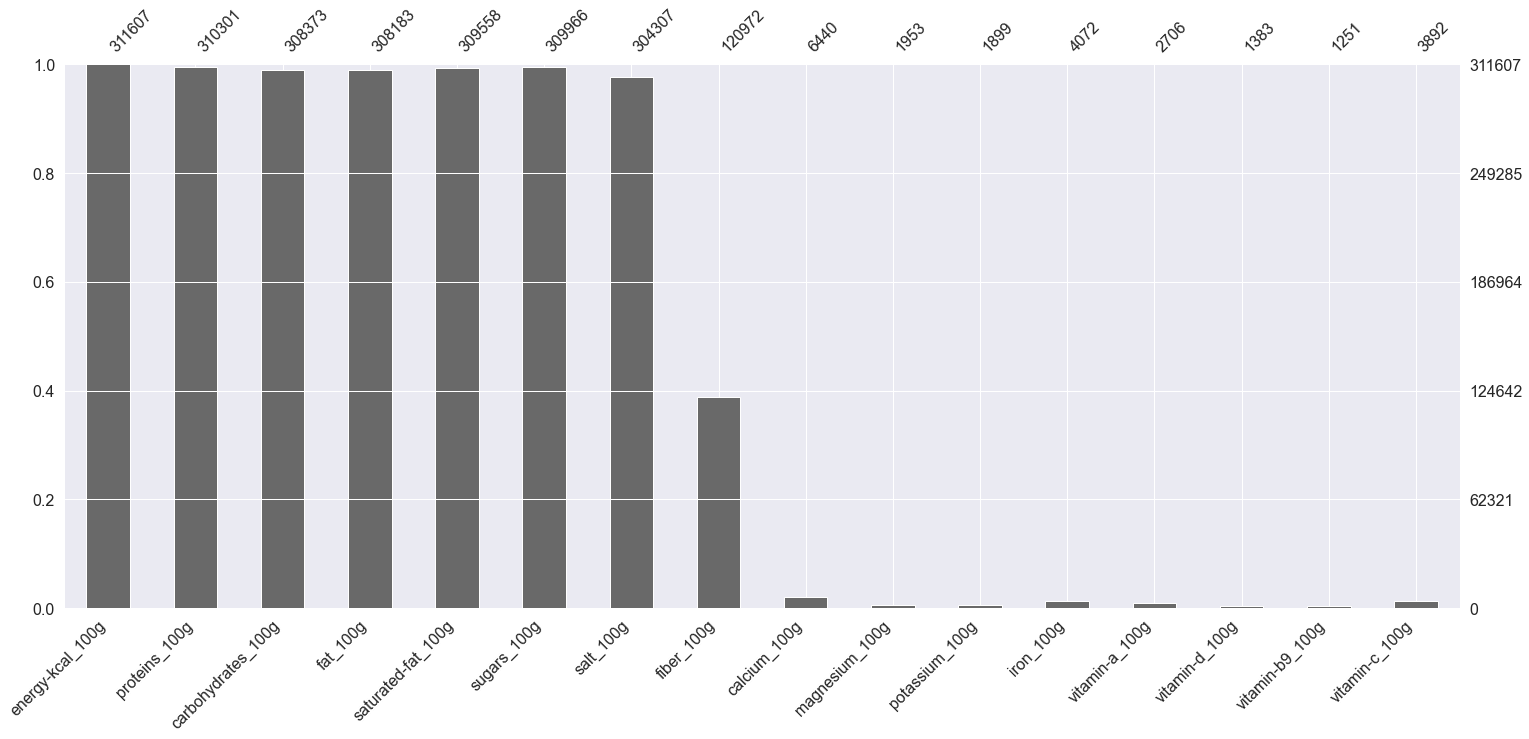

In [130]:
# Select rows with 'product_name', 'brands and 'countries' filled
df_products_select = df_products_select[df_products_select['product_name'].notna() & df_products_select['brands'].notna() & df_products_select['energy-kcal_100g'].notna()]

# Set index with non-numerical variables
df_products_select.set_index(['code','product_name','brands','countries','nutriscore_grade'], inplace = True)

# Check missing values
msno.bar(df_products_select)


## 2. Statistical cleaning 

### a. Outliers

In [131]:
# Create new datframe variable for treatment of outliers
df_products_outliers = df_products_select.copy(deep=True)

# Show
df_products_outliers.head()


energy-kcal_100g  \
code          product_name           brands                  countries nutriscore_grade                     
0000000001199 Solène céréales poulet CROUS                   France    NaN                          219.0   
0000000001281 Tarte noix de coco     Crous Resto',Crous      France    d                            381.0   
0000000001663 Crème dessert chocolat Ferme De La Frémondière France    NaN                            0.0   
0000000001885 Compote de poire       Crous                   France    a                            157.0   
0000000002264 Baguette Poitevin      Crous resto             France    NaN                          207.0   

                                                                                         proteins_100g  \
code          product_name           brands                  countries nutriscore_grade                  
0000000001199 Solène céréales poulet CROUS                   France    NaN                         9.7   
0000000001281 Tarte noix de coco     Crous Resto',Crous      France    d                           4.6   
0000000001663 Crème dessert chocolat Ferme De La Frémondière France    NaN                         0.0   
0000000001885 Compote de poire       Crous                   France    a                           0.6   
0000000002264 Baguette Poitevin      Crous resto             France    NaN                         8.9   

                                                                                         carbohydrates_100g  \
code          product_name           brands                  countries nutriscore_grade                       
0000000001199 Solène céréales poulet CROUS                   France    NaN                             30.3   
0000000001281 Tarte noix de coco     Crous Resto',Crous      France    d                               27.3   
0000000001663 Crème dessert chocolat Ferme De La Frémondière France    NaN                              0.0   
0000000001885 Compote de poire       Crous                   France    a                               36.0   
0000000002264 Baguette Poitevin      Crous resto             France    NaN                             27.5   

                                                                                         fat_100g  \
code          product_name           brands                  countries nutriscore_grade             
0000000001199 Solène céréales poulet CROUS                   France    NaN                    5.9   
0000000001281 Tarte noix de coco     Crous Resto',Crous      France    d                     22.0   
0000000001663 Crème dessert chocolat Ferme De La Frémondière France    NaN                    0.0   
0000000001885 Compote de poire       Crous                   France    a                      0.0   
0000000002264 Baguette Poitevin      Crous resto             France    NaN                    6.7   

                                                                                         saturated-fat_100g  \
code          product_name           brands                  countries nutriscore_grade                       
0000000001199 Solène céréales poulet CROUS                   France    NaN                              0.5   
0000000001281 Tarte noix de coco     Crous Resto',Crous      France    d                               15.5   
0000000001663 Crème dessert chocolat Ferme De La Frémondière France    NaN                              0.0   
0000000001885 Compote de poire       Crous                   France    a                                0.0   
0000000002264 Baguette Poitevin      Crous resto             France    NaN                              3.8   

                                                                                         sugars_100g  \
code          product_name           brands                  countries nutriscore_grade                
0000000001199 Solène céréales poulet CROUS                   France    NaN                       1.7   
000000

In [132]:
# Check stats
df_products_outliers.describe()

energy-kcal_100g  proteins_100g  carbohydrates_100g       fat_100g  \
count      3.116070e+05  310301.000000       308373.000000  308183.000000   
mean       2.766052e+02       8.431517           28.592151      13.697009   
std        2.444838e+03     131.380840          346.853577      55.078115   
min        0.000000e+00       0.000000           -0.500000       0.000000   
25%        1.040000e+02       1.300000            3.400000       0.880000   
50%        2.550000e+02       5.800000           14.900000       6.800000   
75%        4.000000e+02      11.200000           53.400000      21.200000   
max        1.360000e+06   73000.000000       192000.000000   29000.000000   

       saturated-fat_100g    sugars_100g      salt_100g     fiber_100g  \
count       309558.000000  309966.000000  304307.000000  120972.000000   
mean             5.259308      14.216969       1.204916       3.076702   
std              8.924145      52.482041      25.785597       5.178955   
min              0.000000      -1.000000       0.000000       0.000000   
25%              0.200000       0.800000       0.050000       0.100000   
50%              1.800000       4.000000       0.420000       1.700000   
75%              7.300000      20.900000       1.200000       3.800000   
max           2000.000000   27000.000000   14000.000000     200.000000   

       calcium_100g  magnesium_100g  potassium_100g    iron_100g  \
count   6440.000000     1953.000000     1899.000000  4072.000000   
mean       1.007902        0.981501        1.226531     0.102480   
std       18.801214       15.101949       19.808800     2.191515   
min        0.000000        0.000000        0.000000     0.000000   
25%        0.036000        0.028900        0.080000     0.000828   
50%        0.120000        0.087000        0.191000     0.002650   
75%        0.200000        0.147000        0.467000     0.006258   
max      930.000000      506.000000      696.000000   120.000000   

       vitamin-a_100g  vitamin-d_100g  vitamin-b9_100g  vitamin-c_100g  
count     2706.000000    1.383000e+03      1251.000000     3892.000000  
mean         0.495153    3.124897e-02         0.483534        0.211552  
std         14.440343    4.283723e-01         9.166595        3.077992  
min          0.000000    0.000000e+00         0.000000        0.000000  
25%          0.000000    7.500000e-07         0.000030        0.000000  
50%          0.000015    1.500000e-06         0.000112        0.010900  
75%          0.000200    7.500000e-06         0.000170        0.024000  
max        585.000000    1.200000e+01       300.000000      120.000000

#### Checking-out outliers - Before treatment

##### Plot 1 - Line

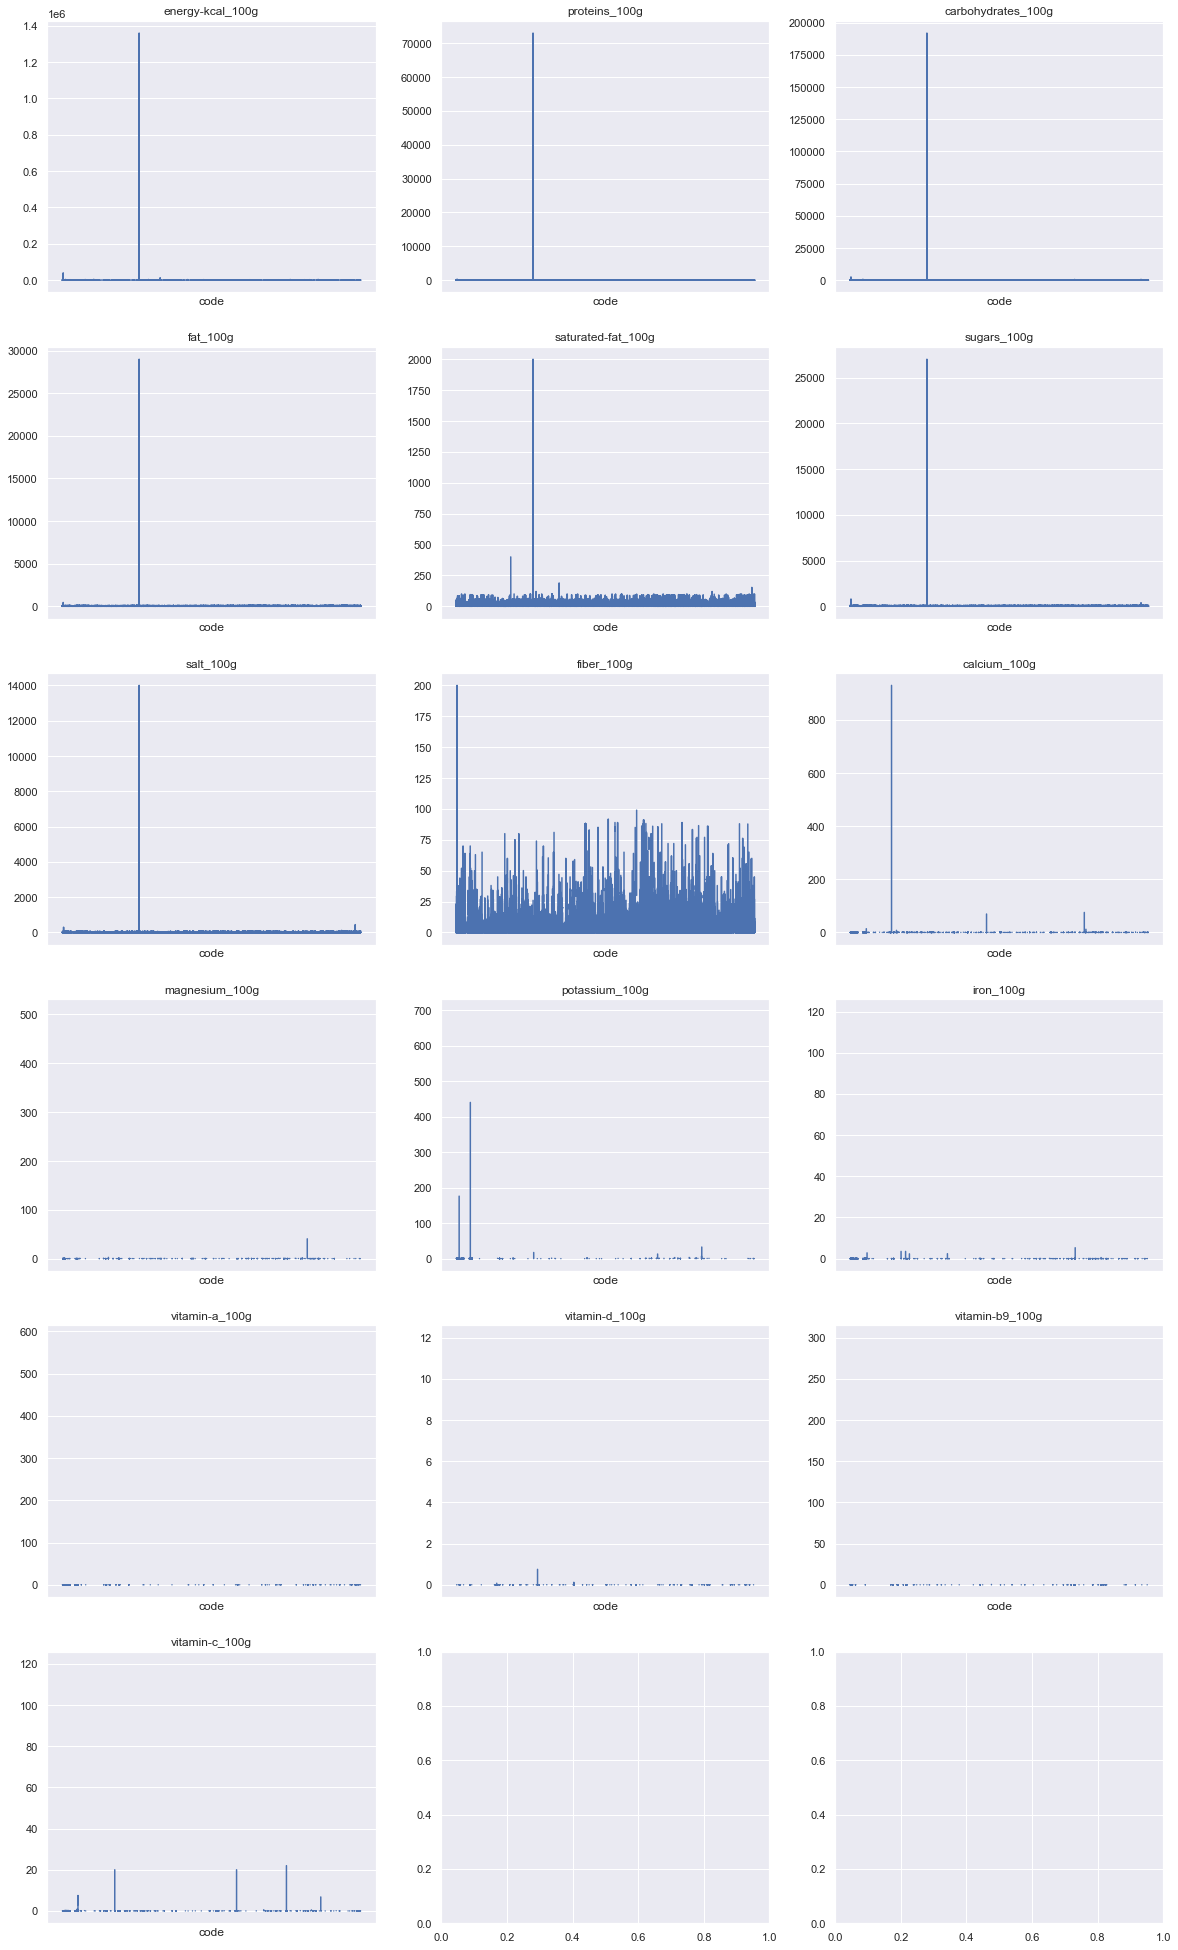

In [133]:
# Checking out outliers with line plot
# Compute number of rows needed
rows = math.ceil(len(df_products_outliers.columns)/3)

# Plot by calling plot_grid() defined in utils.py
plot_grid(rows, 3, (df_products_outliers.reset_index(['product_name','brands','countries','nutriscore_grade'])).drop(columns=['product_name','brands','countries','nutriscore_grade']), "line") 

# x-axis: products index


##### Plot 2 - Box

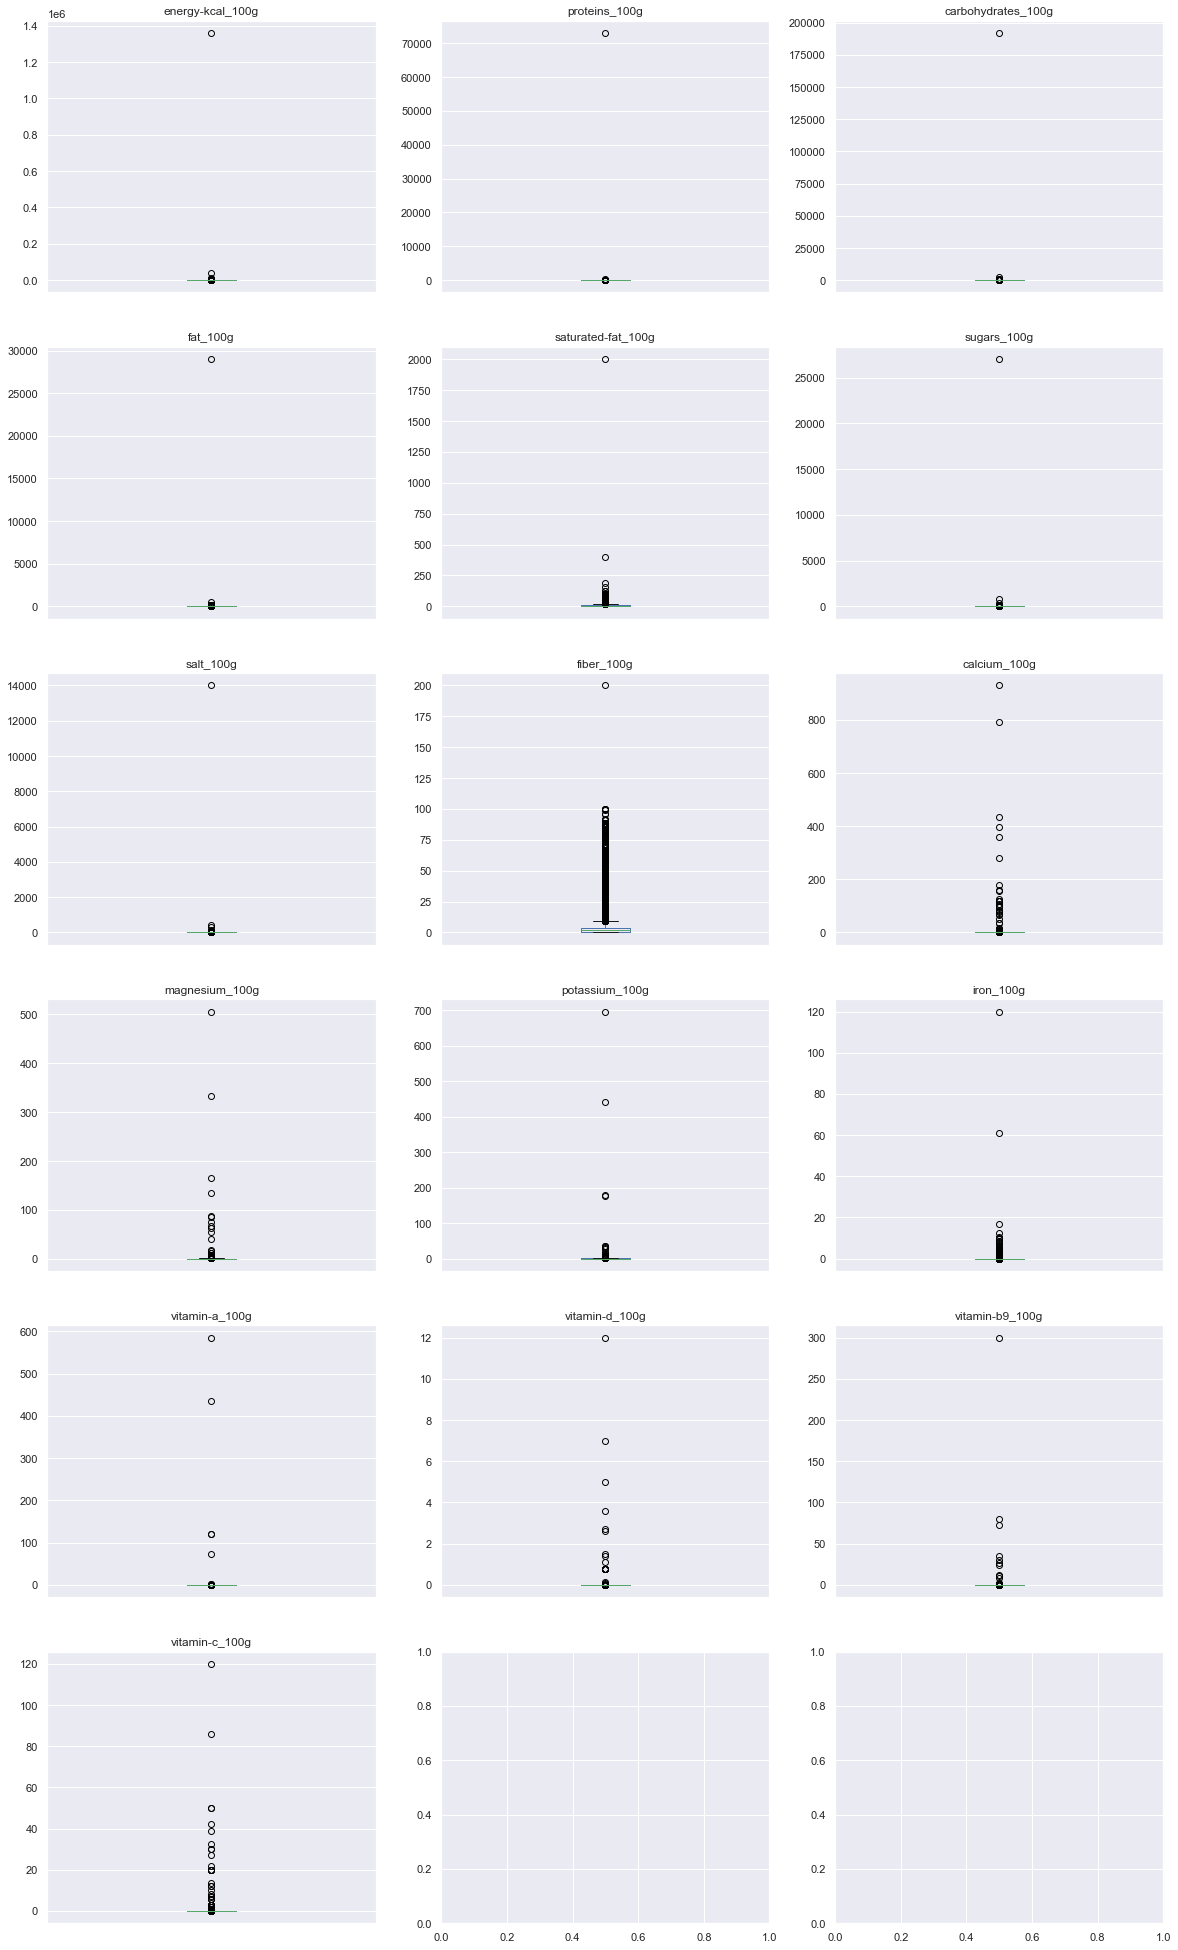

In [134]:
# Checking out outliers with box plot
# Plot by calling plot_grid() defined in utils.py
plot_grid(rows, 3, df_products_outliers, "box") 


#### Treatment 1 - Interquartile method

In [135]:
# Interquartile method (IQR = Q3 - Q1)
# This method takes into account the median and quartiles and isn't sensistive to outilers as are the mean and standard deviation

# Compute inter-quartile value
q1 = df_products_outliers.quantile(0.25)
q3 = df_products_outliers.quantile(0.75)
iqr = q3 - q1

# Remove outliers above 1.5*iqr from 75th quantile and below 1.5*iqr from 25th quantile
df_products_outliers = df_products_outliers[(df_products_outliers >= q1 - 1.5*iqr) 
                                            & (df_products_outliers <= q3 + 1.5*iqr)                                
                                           ]

# Show stats
info(df_products_outliers)
df_products_outliers.describe()


16 columns
311607 rows
Rate of missing values in df : 55.85258434502434 %


energy-kcal_100g  proteins_100g  carbohydrates_100g       fat_100g  \
count     308765.000000  298044.000000       308361.000000  296822.000000   
mean         265.518256       6.968641           27.952172      11.256715   
std          182.383020       6.679093           27.833837      12.539505   
min            0.000000       0.000000           -0.500000       0.000000   
25%          103.000000       1.100000            3.400000       0.700000   
50%          252.000000       5.500000           14.900000       6.000000   
75%          396.000000      10.000000           53.400000      19.100000   
max          844.000000      26.020000          125.000000      51.610000   

       saturated-fat_100g    sugars_100g      salt_100g     fiber_100g  \
count       283648.000000  285002.000000  286067.000000  113023.000000   
mean             3.439462       9.615801       0.612167       2.113404   
std              4.524822      13.073170       0.679676       2.277113   
min              0.000000      -1.000000       0.000000       0.000000   
25%              0.100000       0.700000       0.030000       0.000000   
50%              1.300000       3.200000       0.310000       1.500000   
75%              5.000000      13.000000       1.000000       3.200000   
max             17.950000      51.050000       2.920000       9.300000   

       calcium_100g  magnesium_100g  potassium_100g    iron_100g  \
count   5560.000000     1842.000000     1791.000000  3775.000000   
mean       0.106374        0.092170        0.258105     0.003280   
std        0.094794        0.076231        0.245490     0.003256   
min        0.000000        0.000000        0.000000     0.000000   
25%        0.020000        0.026075        0.073000     0.000690   
50%        0.119650        0.081550        0.180000     0.002400   
75%        0.136000        0.133000        0.388250     0.004800   
max        0.444000        0.322000        1.040000     0.014400   

       vitamin-a_100g  vitamin-d_100g  vitamin-b9_100g  vitamin-c_100g  
count     2335.000000    1.285000e+03      1173.000000     3570.000000  
mean         0.000074    3.195682e-06         0.000106        0.012084  
std          0.000119    3.300543e-06         0.000080        0.014218  
min          0.000000    0.000000e+00         0.000000        0.000000  
25%          0.000000    7.500000e-07         0.000030        0.000000  
50%          0.000000    1.450000e-06         0.000097        0.008000  
75%          0.000120    5.000000e-06         0.000166        0.020000  
max          0.000500    1.750000e-05         0.000380        0.060000

####  Treatment 2 - Results adjustment (0, 100) 

In [136]:
# Dismissing negative values and above 100 values for any "_100g" indicator
df_products_outliers.loc[:, df_products_outliers.columns != 'energy-kcal_100g'] = df_products_outliers.loc[:, df_products_outliers.columns != 'energy-kcal_100g'][(df_products_outliers.loc[:, df_products_outliers.columns != 'energy-kcal_100g'] >= 0) & (df_products_outliers.loc[:, df_products_outliers.columns != 'energy-kcal_100g'] <= 100)]

# Show stats
df_products_outliers.describe()


energy-kcal_100g  proteins_100g  carbohydrates_100g       fat_100g  \
count     308765.000000  298044.000000       308355.000000  296822.000000   
mean         265.518256       6.968641           27.950955      11.256715   
std          182.383020       6.679093           27.832142      12.539505   
min            0.000000       0.000000            0.000000       0.000000   
25%          103.000000       1.100000            3.400000       0.700000   
50%          252.000000       5.500000           14.900000       6.000000   
75%          396.000000      10.000000           53.400000      19.100000   
max          844.000000      26.020000          100.000000      51.610000   

       saturated-fat_100g    sugars_100g      salt_100g     fiber_100g  \
count       283648.000000  285000.000000  286067.000000  113023.000000   
mean             3.439462       9.615874       0.612167       2.113404   
std              4.524822      13.073187       0.679676       2.277113   
min              0.000000       0.000000       0.000000       0.000000   
25%              0.100000       0.700000       0.030000       0.000000   
50%              1.300000       3.200000       0.310000       1.500000   
75%              5.000000      13.000000       1.000000       3.200000   
max             17.950000      51.050000       2.920000       9.300000   

       calcium_100g  magnesium_100g  potassium_100g    iron_100g  \
count   5560.000000     1842.000000     1791.000000  3775.000000   
mean       0.106374        0.092170        0.258105     0.003280   
std        0.094794        0.076231        0.245490     0.003256   
min        0.000000        0.000000        0.000000     0.000000   
25%        0.020000        0.026075        0.073000     0.000690   
50%        0.119650        0.081550        0.180000     0.002400   
75%        0.136000        0.133000        0.388250     0.004800   
max        0.444000        0.322000        1.040000     0.014400   

       vitamin-a_100g  vitamin-d_100g  vitamin-b9_100g  vitamin-c_100g  
count     2335.000000    1.285000e+03      1173.000000     3570.000000  
mean         0.000074    3.195682e-06         0.000106        0.012084  
std          0.000119    3.300543e-06         0.000080        0.014218  
min          0.000000    0.000000e+00         0.000000        0.000000  
25%          0.000000    7.500000e-07         0.000030        0.000000  
50%          0.000000    1.450000e-06         0.000097        0.008000  
75%          0.000120    5.000000e-06         0.000166        0.020000  
max          0.000500    1.750000e-05         0.000380        0.060000

In [137]:
# Show stats
len(df_products_outliers)   

311607

#### Checking out outliers - After treatment

##### Plot 1' - Line

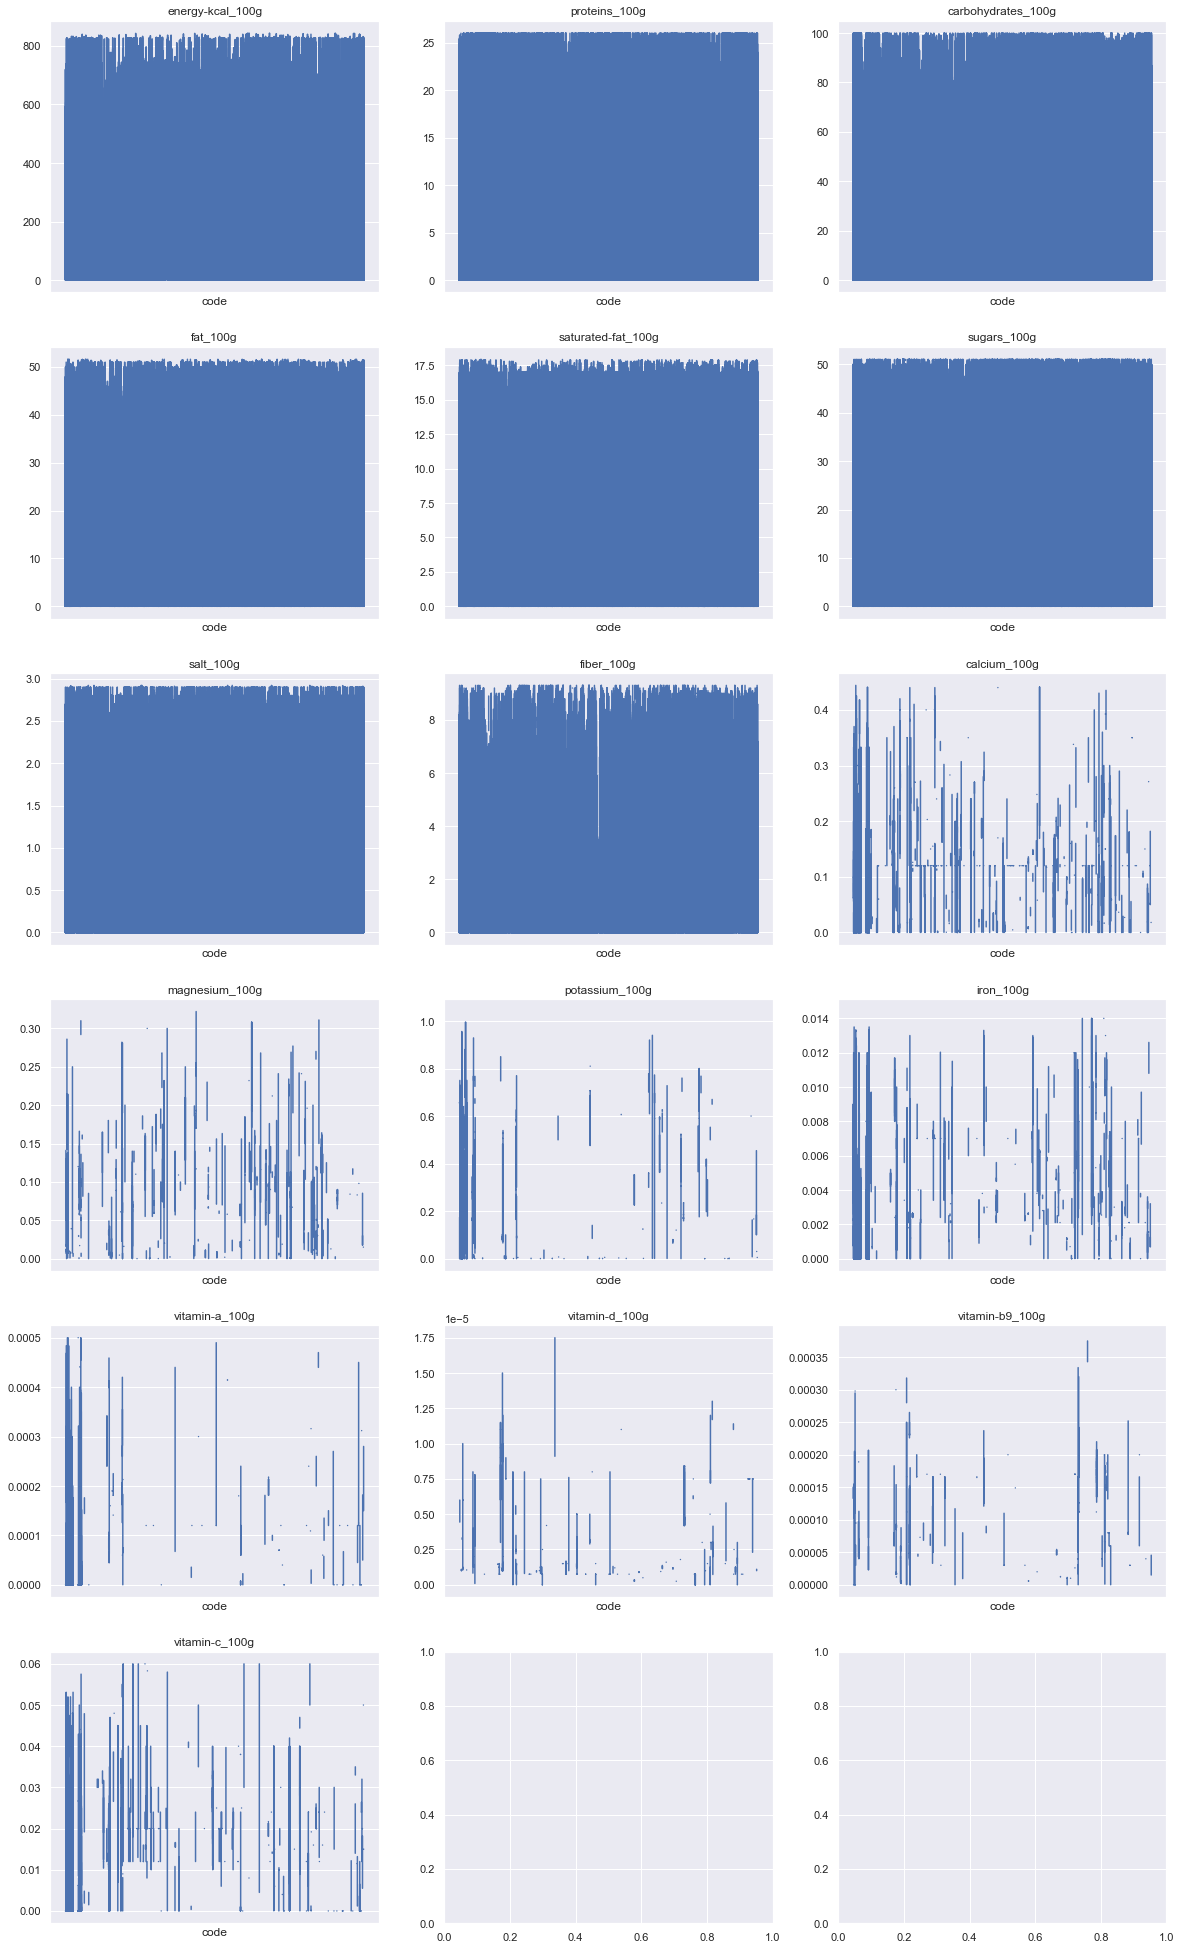

In [138]:
# Checking out outliers with line plot
# Plot by calling plot_grid() defined in utils.py
plot_grid(rows, 3, (df_products_outliers.reset_index(['product_name','brands','countries','nutriscore_grade'])).drop(columns=['product_name','brands','countries','nutriscore_grade']), "line") 

# x-axis: products index


##### Plot 2' - Box

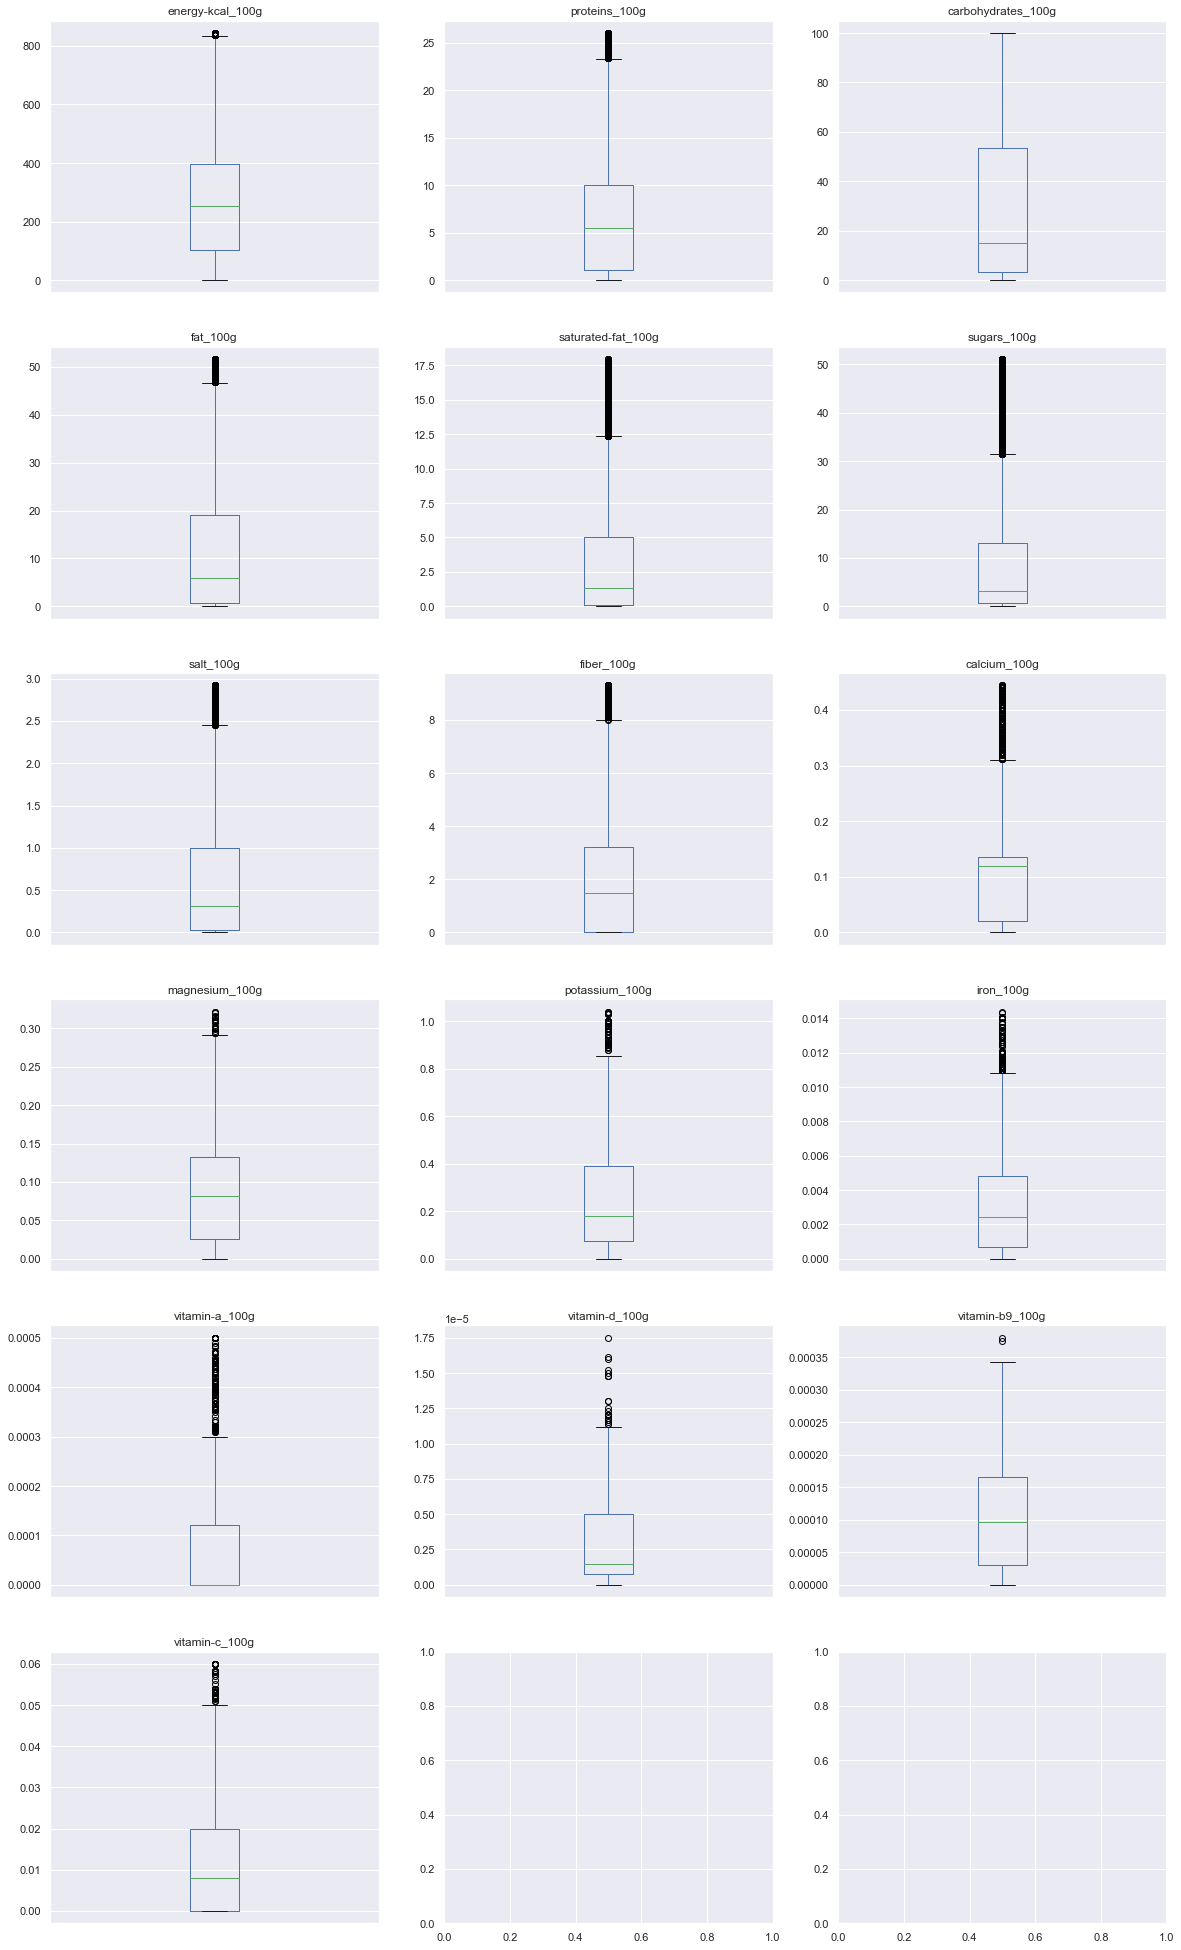

In [139]:
# Checking out outliers with box plot
# Plot by calling plot_grid() defined in utils.py
plot_grid(rows, 3, df_products_outliers, "box")  


##### Plot 3 - Cumulative Hist 

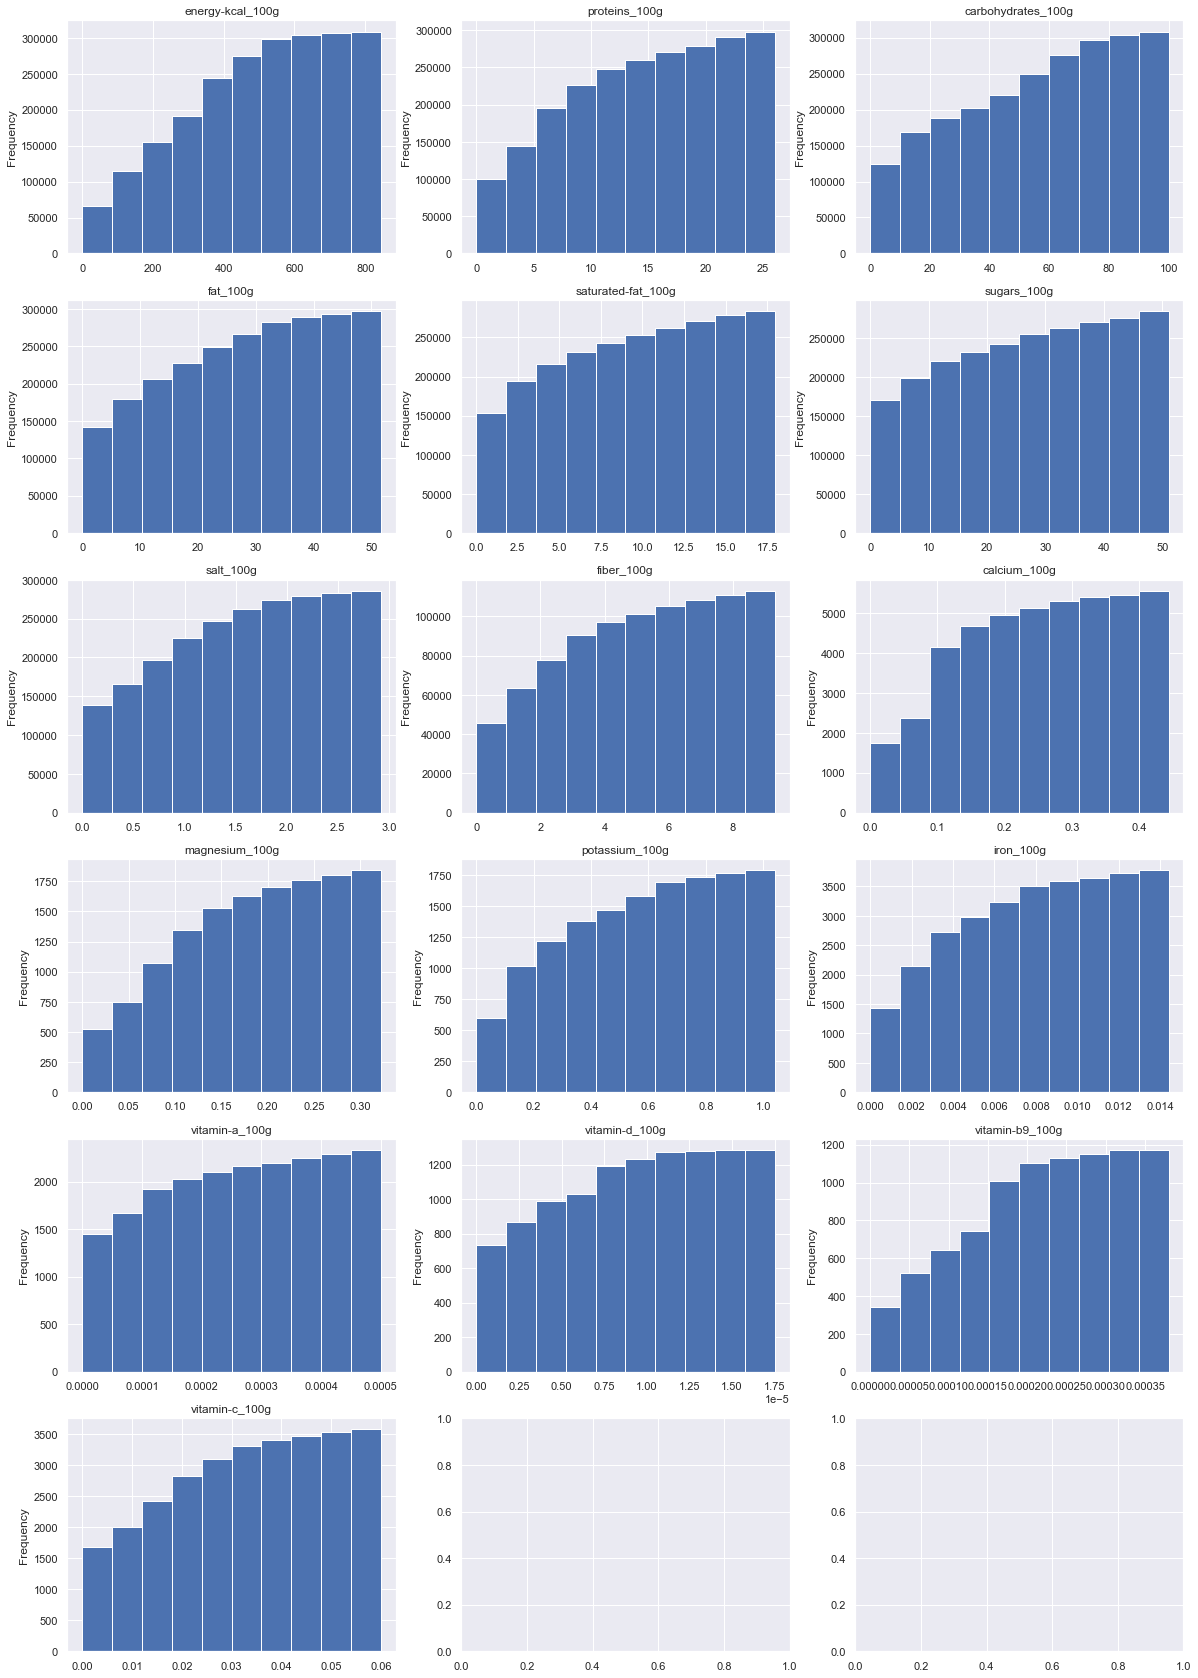

In [140]:
# Most variables' cumulative histogram ends up flat meaning we get most of the values despite our interval restriction
# Plot by calling plot_grid_hist_cumulative() defined in utils.py
plot_grid_hist_cumulative(rows, 3, df_products_outliers)


In [141]:
# Checking rate of dataframe's missing values
print(df_products_outliers.isnull().mean().mean())

# Checking number of remaining products 
print(len(df_products_outliers))


0.5585274480355062
311607


### b. Missing data

#### Initial analysis

<AxesSubplot:>

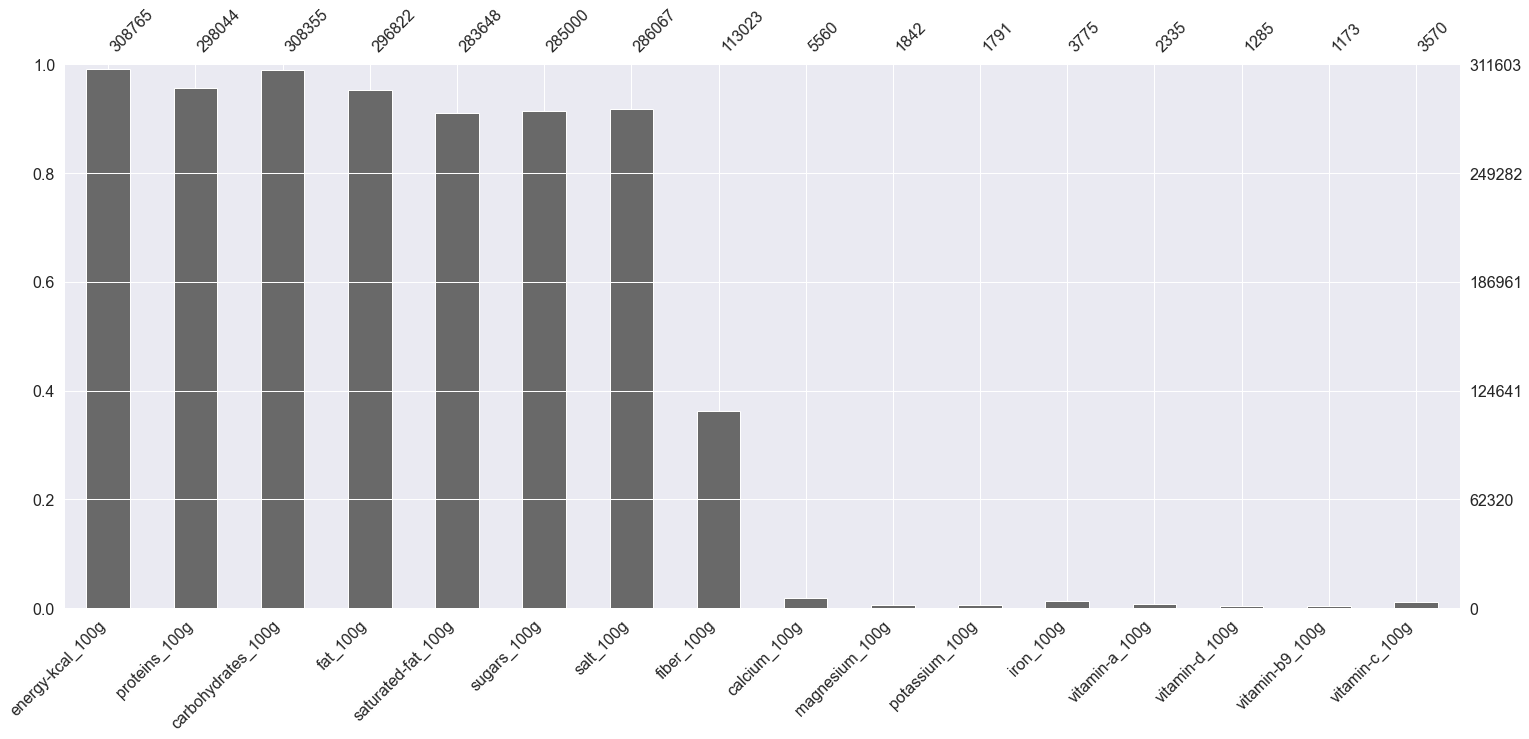

In [194]:
# Creating dataframe for treatment of missing numerical data 
df_products_missing_data = df_products_outliers.copy(deep = True)

# Dismissing rows with no data
df_products_missing_data.dropna(axis = 0, how = 'all', inplace = True)

# Checking missing data
msno.bar(df_products_missing_data)


#### Variables correlation analysis

nutriscore_grade      0.650831
energy-kcal_100g      0.990892
proteins_100g         0.956486
carbohydrates_100g    0.989576
fat_100g              0.952565
saturated-fat_100g    0.910286
sugars_100g           0.914625
salt_100g             0.918050
fiber_100g            0.362715
calcium_100g          0.017843
magnesium_100g        0.005911
potassium_100g        0.005748
iron_100g             0.012115
vitamin-a_100g        0.007494
vitamin-d_100g        0.004124
vitamin-b9_100g       0.003764
vitamin-c_100g        0.011457
dtype: float64


<AxesSubplot:>

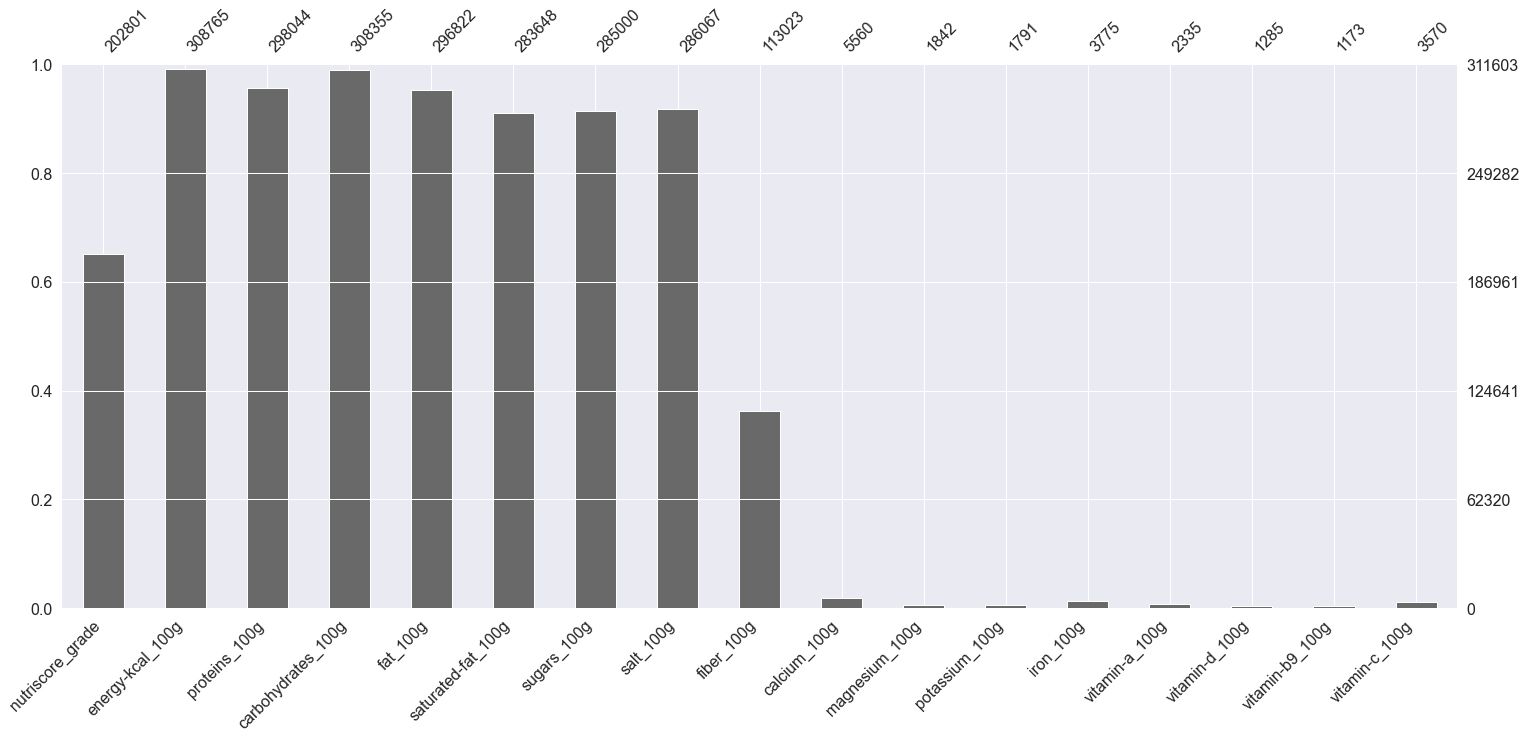

In [195]:
df_products_missing_data.reset_index(['nutriscore_grade'], inplace = True)

# Checking completion per column
list_initial_rate_of_missing_values = df_products_missing_data.notna().mean()

# Show list
print(list_initial_rate_of_missing_values)

# Checking missing data
msno.bar(df_products_missing_data)

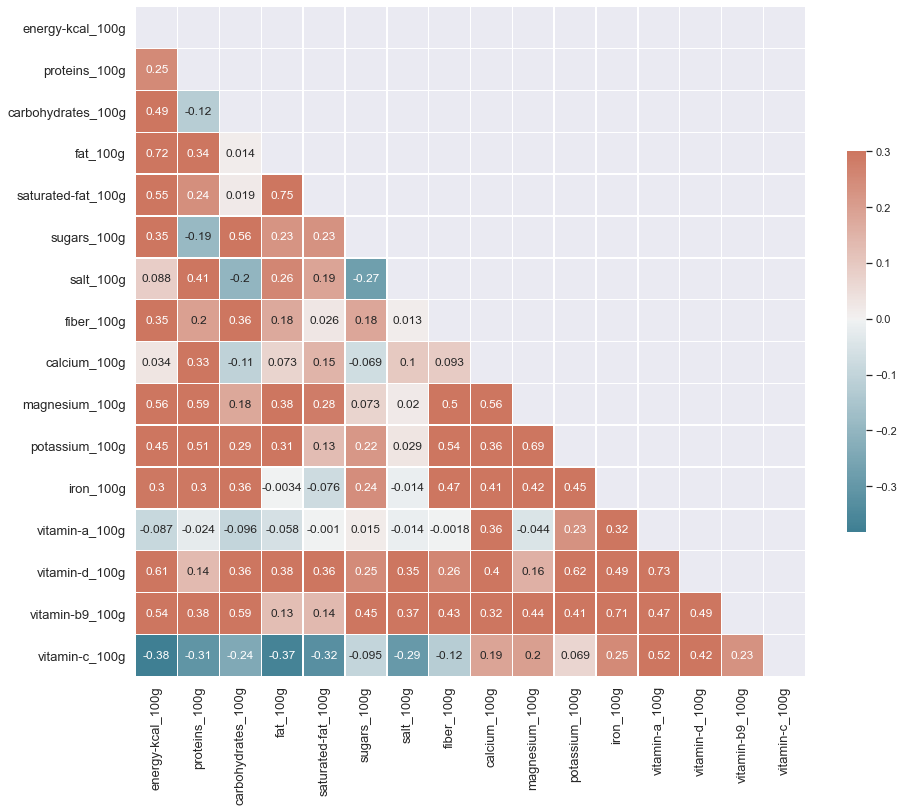

In [196]:
# Plot seaborn correlation graph
dataframe_correlation_graph(df_products_missing_data)

In [145]:
# Selection of variables for next treatments
list_features_treatments_knn = {'energy-kcal_100g',
                     'proteins_100g',
                     'carbohydrates_100g',
                     'fat_100g',
                     'saturated-fat_100g',
                     'sugars_100g',
                     'salt_100g'}
df_products_missing_data_treatments_knn = df_products_missing_data[list_features_treatments_knn].copy(deep=True)

# Show
df_products_missing_data_treatments_knn.head()

salt_100g  \
code          product_name           brands                  countries              
0000000001199 Solène céréales poulet CROUS                   France         0.464   
0000000001281 Tarte noix de coco     Crous Resto',Crous      France         0.100   
0000000001663 Crème dessert chocolat Ferme De La Frémondière France         0.000   
0000000001885 Compote de poire       Crous                   France         0.000   
0000000002264 Baguette Poitevin      Crous resto             France         0.400   

                                                                        fat_100g  \
code          product_name           brands                  countries             
0000000001199 Solène céréales poulet CROUS                   France          5.9   
0000000001281 Tarte noix de coco     Crous Resto',Crous      France         22.0   
0000000001663 Crème dessert chocolat Ferme De La Frémondière France          0.0   
0000000001885 Compote de poire       Crous                   France          0.0   
0000000002264 Baguette Poitevin      Crous resto             France          6.7   

                                                                        sugars_100g  \
code          product_name           brands                  countries                
0000000001199 Solène céréales poulet CROUS                   France             1.7   
0000000001281 Tarte noix de coco     Crous Resto',Crous      France            21.9   
0000000001663 Crème dessert chocolat Ferme De La Frémondière France             0.0   
0000000001885 Compote de poire       Crous                   France            27.0   
0000000002264 Baguette Poitevin      Crous resto             France             0.6   

                                                                        saturated-fat_100g  \
code          product_name           brands                  countries                       
0000000001199 Solène céréales poulet CROUS                   France                    0.5   
0000000001281 Tarte noix de coco     Crous Resto',Crous      France                   15.5   
0000000001663 Crème dessert chocolat Ferme De La Frémondière France                    0.0   
0000000001885 Compote de poire       Crous                   France                    0.0   
0000000002264 Baguette Poitevin      Crous resto             France                    3.8   

                                                                        carbohydrates_100g  \
code          product_name           brands                  countries                       
0000000001199 Solène céréales poulet CROUS                   France                   30.3   
0000000001281 Tarte noix de coco     Crous Resto',Crous      France                   27.3   
0000000001663 Crème dessert chocolat Ferme De La Frémondière France                    0.0   
0000000001885 Compote de poire       Crous                   France                   36.0   
0000000002264 Baguette Poitevin      Crous resto             France                   27.5   

                                                                        proteins_100g  \
code          product_name           brands                  countries                  
0000000001199 Solène céréales poulet CROUS                   France               9.7   
0000000001281 Tarte noix de coco     Crous Resto',Crous      France               4.6   
0000000001663 Crème dessert chocolat Ferme De La Frémondière France               0.0   
0000000001885 Compote de poire       Crous                   France               0.6   
0000000002264 Baguette Poitevin      Crous resto             France               8.9   

                                                                        energy-kcal_100g  
code          product_name           brands                  countries                    
0000000001199 Solène céréales poulet CROUS                   France                219.0  
0000000001281 Tarte noix de coco     Crous Resto',Crous      F

<AxesSubplot:>

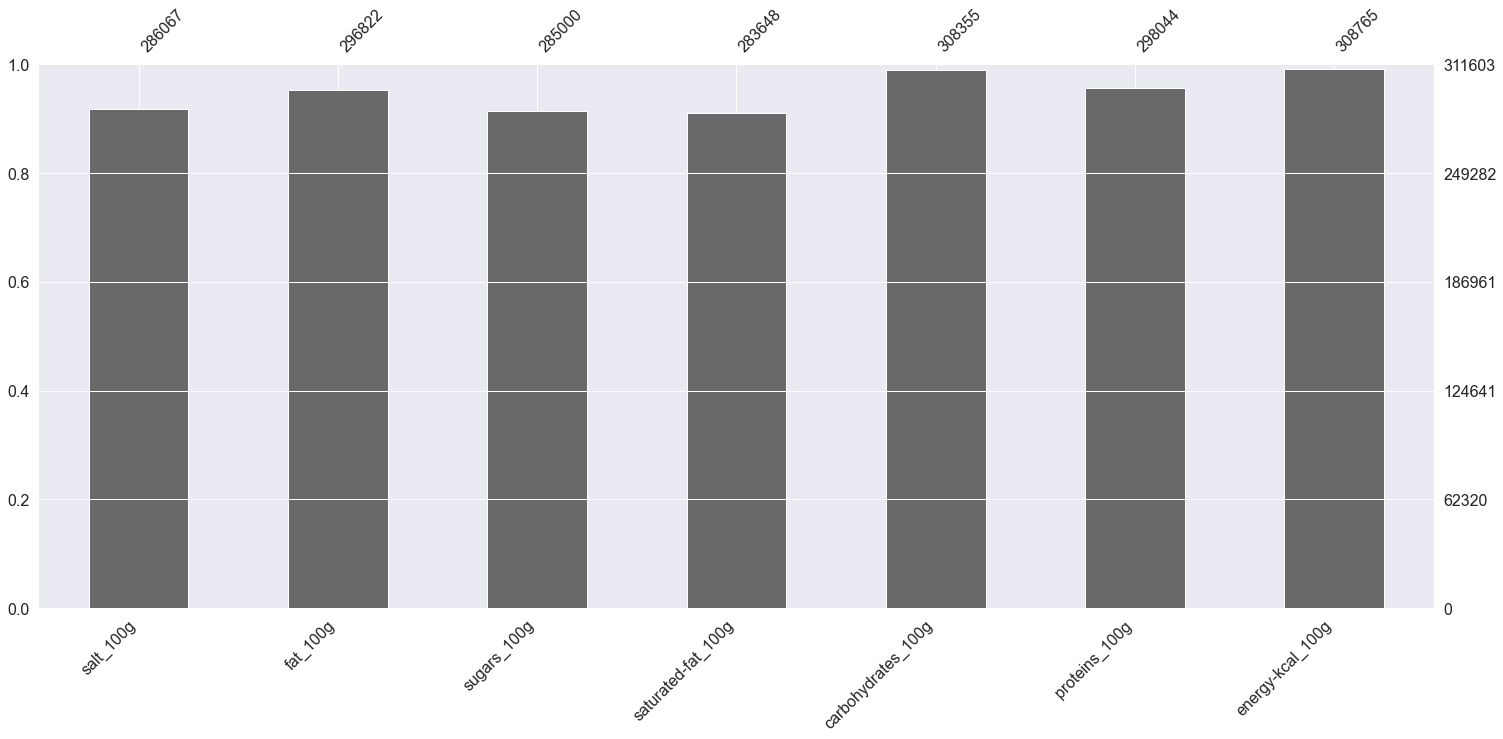

In [146]:
# Checking missing data
msno.bar(df_products_missing_data_treatments_knn)


#### KNeighborsRegressor

In [147]:
# Our 7 variables are continuous
# We will use a KNeighborsRegressor 


##### proteins_100g

In [148]:
# Creating dataframe made of rows with missing data for "proteins_100g" (KNN target) and fully filled other columns (input)
df_products_missing_data_knn_to_predict_proteins = df_products_missing_data_treatments_knn[df_products_missing_data_treatments_knn['proteins_100g'].isna() 
                                                                                & df_products_missing_data_treatments_knn['energy-kcal_100g'].notna()
                                                                                & df_products_missing_data_treatments_knn['carbohydrates_100g'].notna()
                                                                                & df_products_missing_data_treatments_knn['fat_100g'].notna()
                                                                                & df_products_missing_data_treatments_knn['saturated-fat_100g'].notna()    
                                                                                & df_products_missing_data_treatments_knn['sugars_100g'].notna()
                                                                                & df_products_missing_data_treatments_knn['salt_100g'].notna()
                                                                               ]
                                                                                             
# Show
df_products_missing_data_knn_to_predict_proteins


salt_100g  \
code          product_name                                       brands            countries              
000039365     Pure Whey Protein Berries & Cream                  Bulk Powders      France        0.3700   
000039681     Pure Whey Protein™ Chocolate Peanut                Bulk Powders      France        0.3510   
000126630     Vegan Protein Powder                               Bulk,Bulk Powders France        1.3200   
0001390000007 Espirulina En Comprimidos Ecologica Salud Viva     Salud Viva        France        1.1000   
00061         Choux frisé en poudre                              Good nutrition    en:France     0.6100   
...                                                                                                 ...   
96181089      Fruit & nut bar protein packed with chocolate a... Eat Natural       France        0.3800   
9782757828960 Superlevure                                        Gayelord Hauser   France        0.5000   
98            Cassoulet du pays occitan aux saucisses de toul... ffdd              France        0.0002   
9900000000424 Feves decortiquees                                 Biosic            France        0.3000   
9950014911001 Oignons jaunes 40/60                               Ferme De L'artois France        0.2000   

                                                                                              fat_100g  \
code          product_name                                       brands            countries             
000039365     Pure Whey Protein Berries & Cream                  Bulk Powders      France         8.33   
000039681     Pure Whey Protein™ Chocolate Peanut                Bulk Powders      France         7.50   
000126630     Vegan Protein Powder                               Bulk,Bulk Powders France         6.00   
0001390000007 Espirulina En Comprimidos Ecologica Salud Viva     Salud Viva        France         8.20   
00061         Choux frisé en poudre                              Good nutrition    en:France      6.14   
...                                                                                                ...   
96181089      Fruit & nut bar protein packed with chocolate a... Eat Natural       France        28.50   
9782757828960 Superlevure                                        Gayelord Hauser   France         5.00   
98            Cassoulet du pays occitan aux saucisses de toul... ffdd              France        41.00   
9900000000424 Feves decortiquees                                 Biosic            France         3.00   
9950014911001 Oignons jaunes 40/60                               Ferme De L'artois France         5.00   

                                                                                              sugars_100g  \
code          product_name                                       brands            countries                
000039365     Pure Whey Protein Berries & Cream                  Bulk Powders      France            8.67   
000039681     Pure Whey Protein™ Chocolate Peanut                Bulk Powders      France           10.00   
000126630     Vegan Protein Powder                               Bulk,Bulk Powders France            1.50   
0001390000007 Espirulina En Comprimidos Ecologica Salud Viva     Salud Viva        France            3.00   
00061         Choux frisé en poudre                              Good nutrition    en:France        15.80   
...                                                                                                   ...   
96181089      Fruit & nut bar protein packed with chocolate a... Eat Natural       France           18.40   
9782757828960 Superlevure                                        Gayelord Hauser   France            8.00   
98            Cassoulet du pays occitan aux saucisses de toul... ffdd              France           37.00   
9900000000424 Feves decortiquees                                 Biosic            France            4.90   
9950014911001 O

In [149]:
# Getting knn proteins classifier 
# knn_function function is defined in utils.py
knn_proteins = knn_function("proteins_100g", df_products_missing_data_treatments_knn, 3, 5) 


Cross validation accuracy: 85.8138097452071 %
Root Mean Squared Error: 2.1763320894375204


##### fat_100g

In [150]:
# Creating dataframe made of rows with missing values for "proteins_100g" (KNN target) and fully filled other columns (input)
df_products_missing_data_knn_to_predict_fat = df_products_missing_data_treatments_knn[df_products_missing_data_treatments_knn['fat_100g'].isna() 
                                                                            & df_products_missing_data_treatments_knn['energy-kcal_100g'].notna()
                                                                            & df_products_missing_data_treatments_knn['carbohydrates_100g'].notna()
                                                                            & df_products_missing_data_treatments_knn['saturated-fat_100g'].notna() 
                                                                            & df_products_missing_data_treatments_knn['proteins_100g'].notna()
                                                                            & df_products_missing_data_treatments_knn['sugars_100g'].notna()
                                                                            & df_products_missing_data_treatments_knn['salt_100g'].notna()
                                                                          ]
                                                                                             
# Show
df_products_missing_data_knn_to_predict_fat


salt_100g  \
code          product_name                                     brands          countries                             
0000005016    pesto                                            Kazidomi        France,Belgique               2.700   
00051446      0% Fat Greek style yogurt                        Marks & Spencer France                        0.200   
00079952      Raw Almonds                                      Trader Joe's    France, United States         0.000   
00091534      Spicy Cajun Mayo                                 Marks & Spencer France                        0.980   
14113210362   Amandes grillées salées                          Wonderful       France                        0.800   
...                                                                                                            ...   
9415102100533 Lité - Olive oil                                 Olivani         France                        0.360   
9415748008699 Energy Spread : Pumpkin, Sunflower Seed & Almond Ceres Organics  France, Nouvelle-Zélande      0.204   
9421009030019 Olivado huile Avocats Extra Virgin 250ml         Olivado         en:france                     0.000   
9470270184747 huile de colza                                   eco+            France                        0.000   
9556041131940 Sauce curry                                      Ayam            France                        2.500   

                                                                                                         fat_100g  \
code          product_name                                     brands          countries                            
0000005016    pesto                                            Kazidomi        France,Belgique                NaN   
00051446      0% Fat Greek style yogurt                        Marks & Spencer France                         NaN   
00079952      Raw Almonds                                      Trader Joe's    France, United States          NaN   
00091534      Spicy Cajun Mayo                                 Marks & Spencer France                         NaN   
14113210362   Amandes grillées salées                          Wonderful       France                         NaN   
...                                                                                                           ...   
9415102100533 Lité - Olive oil                                 Olivani         France                         NaN   
9415748008699 Energy Spread : Pumpkin, Sunflower Seed & Almond Ceres Organics  France, Nouvelle-Zélande       NaN   
9421009030019 Olivado huile Avocats Extra Virgin 250ml         Olivado         en:france                      NaN   
9470270184747 huile de colza                                   eco+            France                         NaN   
9556041131940 Sauce curry                                      Ayam            France                         NaN   

                                                                                                         sugars_100g  \
code          product_name                                     brands          countries                               
0000005016    pesto                                            Kazidomi        France,Belgique                   0.5   
00051446      0% Fat Greek style yogurt                        Marks & Spencer France                            4.8   
00079952      Raw Almonds                                      Trader Joe's    France, United States             3.5   
00091534      Spicy Cajun Mayo                                 Marks & Spencer France                            2.5   
14113210362   Amandes grillées salées                          Wonderful       France                            4.9   
...                                                                                                              ...   
9415102100533 Lité - Olive oil                                 Olivani         France   

In [151]:
# Getting knn fat classifier 
# knn_function function is defined in utils.py
knn_fat = knn_function('fat_100g', df_products_missing_data_treatments_knn, 3, 5) 


Cross validation accuracy: 92.98160828270048 %
Root Mean Squared Error: 2.663662314626468


##### sugars_100g

In [152]:
# Create dataframe made of rows with missing values for "sugars_100g" (KNN target) and fully filled other columns (input)
df_products_missing_data_knn_to_predict_sugars = df_products_missing_data_treatments_knn[df_products_missing_data_treatments_knn['sugars_100g'].isna() 
                                                                            & df_products_missing_data_treatments_knn['energy-kcal_100g'].notna()
                                                                            & df_products_missing_data_treatments_knn['carbohydrates_100g'].notna()
                                                                            & df_products_missing_data_treatments_knn['proteins_100g'].notna()
                                                                            & df_products_missing_data_treatments_knn['fat_100g'].notna()
                                                                            & df_products_missing_data_treatments_knn['saturated-fat_100g'].notna() 
                                                                            & df_products_missing_data_treatments_knn['salt_100g'].notna()
                                                                          ]
                                                                                             
# Show
df_products_missing_data_knn_to_predict_sugars

salt_100g  \
code          product_name                                    brands                   countries              
0000000811613 Dragées aux amandes                             Marque Repère Plantation France          0.02   
0000003075647 Coeurs chocolat tte couleur                     Agora                    France          0.01   
0000009125124 Compote de Pomme                                Mx3                      France          0.02   
0000009336247 Bonbons acidulés Raisin Fraise                  Wonka,Nerds              France          0.00   
0000010166352 Glaçage fondant                                 Alice Délice             France          0.00   
...                                                                                                     ...   
9556296318417 Lot 100 Fizzi Lemon Sour Candy 120G             Fizzi                    France          0.00   
96033180      Instant Hot Chocolate                           Cadbury                  France          1.60   
96121283      Calendrier de l'Avent avec 24 Chocolats au Lait Disney                   France          0.28   
96174395      Sweet freedom                                   Fruit Syrup              France          0.00   
9753185833239 Mélange à cuisson pour brownies                 Leev                     France          0.19   

                                                                                                  fat_100g  \
code          product_name                                    brands                   countries             
0000000811613 Dragées aux amandes                             Marque Repère Plantation France          7.3   
0000003075647 Coeurs chocolat tte couleur                     Agora                    France         15.0   
0000009125124 Compote de Pomme                                Mx3                      France          0.5   
0000009336247 Bonbons acidulés Raisin Fraise                  Wonka,Nerds              France          0.0   
0000010166352 Glaçage fondant                                 Alice Délice             France          1.0   
...                                                                                                    ...   
9556296318417 Lot 100 Fizzi Lemon Sour Candy 120G             Fizzi                    France          0.0   
96033180      Instant Hot Chocolate                           Cadbury                  France          9.3   
96121283      Calendrier de l'Avent avec 24 Chocolats au Lait Disney                   France         28.6   
96174395      Sweet freedom                                   Fruit Syrup              France          0.0   
9753185833239 Mélange à cuisson pour brownies                 Leev                     France          5.1   

                                                                                                  sugars_100g  \
code          product_name                                    brands                   countries                
0000000811613 Dragées aux amandes                             Marque Repère Plantation France             NaN   
0000003075647 Coeurs chocolat tte couleur                     Agora                    France             NaN   
0000009125124 Compote de Pomme                                Mx3                      France             NaN   
0000009336247 Bonbons acidulés Raisin Fraise                  Wonka,Nerds              France             NaN   
0000010166352 Glaçage fondant                                 Alice Délice             France             NaN   
...                                                                                                       ...   
9556296318417 Lot 100 Fizzi Lemon Sour Candy 120G             Fizzi                    France             NaN   
96033180      Instant Hot Chocolate                           Cadbury                  France             NaN   
96121283      Calendrier de l'Avent avec 24 Chocolats au Lait Disney                   France

In [153]:
# Getting knn fat classifier 
# knn_function function is defined in utils.py
knn_sugars = knn_function('sugars_100g', df_products_missing_data_treatments_knn, 3, 5) 


Cross validation accuracy: 72.19135279854403 %
Root Mean Squared Error: 6.097249886902896


##### salt_100g

In [154]:
# Creating dataframe made of rows with missing values for "salt_100g" (KNN target) and fully filled other columns (input)
df_products_missing_data_knn_to_predict_salt = df_products_missing_data_treatments_knn[df_products_missing_data_treatments_knn['salt_100g'].isna() 
                                                                            & df_products_missing_data_treatments_knn['energy-kcal_100g'].notna()
                                                                            & df_products_missing_data_treatments_knn['carbohydrates_100g'].notna()
                                                                            & df_products_missing_data_treatments_knn['proteins_100g'].notna()
                                                                            & df_products_missing_data_treatments_knn['fat_100g'].notna()
                                                                            & df_products_missing_data_treatments_knn['saturated-fat_100g'].notna() 
                                                                            & df_products_missing_data_treatments_knn['sugars_100g'].notna()
                                                                          ]
                                                                                             
# Show
df_products_missing_data_knn_to_predict_salt

salt_100g  \
code          product_name                              brands            countries                          
0000000003827 Suedois saumon                            Crous             France                       NaN   
0000000005272 Sandwich solene céréales sicilien         Crous             France                       NaN   
0000000020114 Naturablue original                       Natura4Ever       France                       NaN   
0000000038706 Moelleux                                  Unfi              France, United States        NaN   
0000069162176 Quenelles de brochet sauce Nantua         Bofrost           France                       NaN   
...                                                                                                    ...   
9557519301438 Pâte de curry Rendang                     World Foods       France                       NaN   
956701        cérébos                                   Cérébos           France                       NaN   
96107775      Colman's Original English Squeezy Mustard Unilever,Colman's France,United Kingdom        NaN   
96963333      Farine de blé T65                         Casino            France                       NaN   
9782210753617 Pudding à la crème Auchan                 Auchan            France                       NaN   

                                                                                                 fat_100g  \
code          product_name                              brands            countries                         
0000000003827 Suedois saumon                            Crous             France                      4.4   
0000000005272 Sandwich solene céréales sicilien         Crous             France                      6.2   
0000000020114 Naturablue original                       Natura4Ever       France                      0.0   
0000000038706 Moelleux                                  Unfi              France, United States       8.5   
0000069162176 Quenelles de brochet sauce Nantua         Bofrost           France                     11.0   
...                                                                                                   ...   
9557519301438 Pâte de curry Rendang                     World Foods       France                      5.5   
956701        cérébos                                   Cérébos           France                      0.0   
96107775      Colman's Original English Squeezy Mustard Unilever,Colman's France,United Kingdom      12.0   
96963333      Farine de blé T65                         Casino            France                      1.1   
9782210753617 Pudding à la crème Auchan                 Auchan            France                     10.0   

                                                                                                 sugars_100g  \
code          product_name                              brands            countries                            
0000000003827 Suedois saumon                            Crous             France                         4.6   
0000000005272 Sandwich solene céréales sicilien         Crous             France                         1.7   
0000000020114 Naturablue original                       Natura4Ever       France                         0.0   
0000000038706 Moelleux                                  Unfi              France, United States          1.6   
0000069162176 Quenelles de brochet sauce Nantua         Bofrost           France                         0.6   
...                                                                                                      ...   
9557519301438 Pâte de curry Rendang                     World Foods       France                        11.0   
956701        cérébos                                   Cérébos           France                         0.0   
96107775      Colman's Original English Squeezy Mustard Unilever,Colman's France,United Kingdom         13.0   
96963333      Fa

In [155]:
# Getting knn salt classifier 
# knn_function function is defined in utils.py
knn_salt = knn_function('salt_100g', df_products_missing_data_treatments_knn, 3, 5) 

Cross validation accuracy: 50.19270549518825 %
Root Mean Squared Error: 0.43651710340002264


##### saturated-fat_100g

In [156]:
# Creating dataframe made of rows with missing values for "saturated_fat_100g" (KNN target) and fully filled other columns (input)
df_products_missing_data_knn_to_predict_saturated_fat = df_products_missing_data_treatments_knn[df_products_missing_data_treatments_knn['saturated-fat_100g'].isna() 
                                                                            & df_products_missing_data_treatments_knn['energy-kcal_100g'].notna()
                                                                            & df_products_missing_data_treatments_knn['carbohydrates_100g'].notna()
                                                                            & df_products_missing_data_treatments_knn['proteins_100g'].notna()
                                                                            & df_products_missing_data_treatments_knn['fat_100g'].notna()
                                                                            & df_products_missing_data_treatments_knn['salt_100g'].notna() 
                                                                            & df_products_missing_data_treatments_knn['sugars_100g'].notna()
                                                                          ]
                                                                                             
# Show
df_products_missing_data_knn_to_predict_saturated_fat

salt_100g  \
code          product_name                               brands        countries                          
0000000031141 Moelleux au chocolat                       Golden Temple États-Unis, en:france       1.30   
0000010218341 Chocolat lait noisette                     Alice Délice  France                      0.70   
0000012269518 Chocolat noir amandes caramelisées         Cyril Lignac  France                      0.06   
00008902      Raclette                                   Pâturages     France                      1.80   
00019101      Highland Shortbread All Butter Fingers     Sainsbury's   France, Royaume-Uni         0.60   
...                                                                                                 ...   
9556041609944 Crème de Coco                              Ayam          Belgium,France              0.07   
9556041614245 Lait de coco                               Ayam          France                      0.05   
96019955      Eat Natural Blueberry Cashew & Yoghurt Bar Eat natural   France                      0.07   
9647978410441 Noir dessert                               Fin Carré     France                      0.00   
9999900002553 Chocolat de Couverture Noir                Barry         France                      0.03   

                                                                                              fat_100g  \
code          product_name                               brands        countries                         
0000000031141 Moelleux au chocolat                       Golden Temple États-Unis, en:france     28.60   
0000010218341 Chocolat lait noisette                     Alice Délice  France                    40.92   
0000012269518 Chocolat noir amandes caramelisées         Cyril Lignac  France                    37.00   
00008902      Raclette                                   Pâturages     France                    28.00   
00019101      Highland Shortbread All Butter Fingers     Sainsbury's   France, Royaume-Uni       28.30   
...                                                                                                ...   
9556041609944 Crème de Coco                              Ayam          Belgium,France            20.00   
9556041614245 Lait de coco                               Ayam          France                    21.00   
96019955      Eat Natural Blueberry Cashew & Yoghurt Bar Eat natural   France                    26.70   
9647978410441 Noir dessert                               Fin Carré     France                    35.00   
9999900002553 Chocolat de Couverture Noir                Barry         France                    46.90   

                                                                                              sugars_100g  \
code          product_name                               brands        countries                            
0000000031141 Moelleux au chocolat                       Golden Temple États-Unis, en:france        32.30   
0000010218341 Chocolat lait noisette                     Alice Délice  France                       43.67   
0000012269518 Chocolat noir amandes caramelisées         Cyril Lignac  France                       36.00   
00008902      Raclette                                   Pâturages     France                        0.50   
00019101      Highland Shortbread All Butter Fingers     Sainsbury's   France, Royaume-Uni          14.80   
...                                                                                                   ...   
9556041609944 Crème de Coco                              Ayam          Belgium,France                2.50   
9556041614245 Lait de coco                               Ayam          France                        2.10   
96019955      Eat Natural Blueberry Cashew & Yoghurt Bar Eat natural   France                       36.30   
9647978410441 Noir dessert                               Fin Carré     France                       45.60   
9999900002553 C

In [157]:
# Getting knn saturated-fat classifier 
# knn_function function is defined in utils.py
knn_saturated_fat = knn_function('saturated-fat_100g', df_products_missing_data_treatments_knn, 3, 5) 

Cross validation accuracy: 73.50085755293063 %
Root Mean Squared Error: 1.9975944579870244


##### carbohydrates_100g

In [158]:
# Creating dataframe made of rows with missing values for "carbohydrates_100g" (KNN target) and fully filled other columns (input)
df_products_missing_data_knn_to_predict_carbohydrates = df_products_missing_data_treatments_knn[df_products_missing_data_treatments_knn['carbohydrates_100g'].isna() 
                                                                            & df_products_missing_data_treatments_knn['energy-kcal_100g'].notna()
                                                                            & df_products_missing_data_treatments_knn['salt_100g'].notna()
                                                                            & df_products_missing_data_treatments_knn['proteins_100g'].notna()
                                                                            & df_products_missing_data_treatments_knn['fat_100g'].notna()
                                                                            & df_products_missing_data_treatments_knn['saturated-fat_100g'].notna() 
                                                                            & df_products_missing_data_treatments_knn['sugars_100g'].notna()
                                                                          ]
                                                                                             
# Show
df_products_missing_data_knn_to_predict_carbohydrates

salt_100g  \
code          product_name                                    brands                         countries                                                       
210649033721  Saucisse Toulouse                               Jean Rozé                      en:France                                            2.100000   
07317583      cannelle en poudre                              sevenhills                     France                                               0.000000   
17279925      fromage blanc bio                               paturages                      France                                               0.100000   
17761620      Oui                                             Yoplait                        United States, France                                0.000000   
19194080      figues moelleuse                                Auchan                         en:France                                            0.200000   
2201266027291 Aiguillettes de dinde Monoprix                  Monoprix                       en:France                                            0.100000   
2224658065336 Souris D'agneau Confite                         Tendre&Plus                    France                                               1.300000   
2291847075575 jambon fumé cuit                                aux produits saugeais          France                                               1.760000   
24540124      Galettes RIZ COMPLET                            Carrefour Bio                  en:France                                            0.020000   
2600289043101 Mélange bien être                               grand frais                    en:France                                            0.160000   
26032498      Mont d'or AOP                                   Goubault,Savencia              France                                               1.500000   
3119780258529 Bière blonde d'Alsace                           Fischer                        France                                               0.000000   
3119780265701 bière                                           heineken                       France                                               0.010000   
3211200037469 Pinot Noir Grande Réserve Maison Castel         Maison Castel                  en:France                                            0.000000   
3222473909773 Thon blanc au naturel                           Casino                         France                                               1.000000   
3245390045164 2 Véritables Andouillettes de Troyes            Reflets de France,Carrefour    France                                               1.500000   
3245390140388 Thon blanc élaboré en Bretagne                  Reflets de France              France                                               0.975000   
3245390163424 Soupe de Poissons                               Reflets de France              France                                               0.930000   
3250390303237 La Viande Hachée (15 % MG) - Pur Bœuf           Jean roze                      France                                               0.000000   
3270160729890 Raviolis vietnamiens aux légumes                Picard                         France                                               1.960000   
3291331404224 yop                                             yoplait                        France, Guadeloupe                                   0.130000   
3292590831257 Legume du soleil a la plancha                   Thiriet                        France                                               1.510000   
3307902040101 Pavé du Vivarois (20% MG)                       Fromagerie guilloteau          France                                               1.500000   
3328481290008 Les Florentins ® Chocolat lait et orange        Michel Chatillon               France                                               0.000000   
3350033232723 Risotto Poulet Mozzarel

In [159]:
# Getting knn saturated-fat classifier 
# knn_function function is defined in utils.py
knn_saturated_carbohydrates = knn_function('carbohydrates_100g', df_products_missing_data_treatments_knn, 3, 5) 

Cross validation accuracy: 92.85613674933477 %
Root Mean Squared Error: 6.43551868680645


##### energy-kcal_100g

In [160]:
# Creating dataframe made of rows with missing values for "proteins_100g" (KNN target) and fully filled other columns (input)
df_products_missing_data_knn_to_predict_energy = df_products_missing_data_treatments_knn[df_products_missing_data_treatments_knn['energy-kcal_100g'].isna() 
                                                                            & df_products_missing_data_treatments_knn['carbohydrates_100g'].notna()
                                                                            & df_products_missing_data_treatments_knn['salt_100g'].notna()
                                                                            & df_products_missing_data_treatments_knn['proteins_100g'].notna()
                                                                            & df_products_missing_data_treatments_knn['fat_100g'].notna()
                                                                            & df_products_missing_data_treatments_knn['saturated-fat_100g'].notna() 
                                                                            & df_products_missing_data_treatments_knn['sugars_100g'].notna()
                                                                          ]
                                                                                             
# Show
df_products_missing_data_knn_to_predict_energy

salt_100g  \
code          product_name                         brands                      countries                                  
00053990      Dinde,farce et bacon sandwich        Marks & Spencer             France                             1.000   
0008346026357 Slim fast shake mix                  Slim fast                   en:france                          0.000   
0012656707387 Crown Peanut Butter Chunky           crown                       France,New Caledonia               0.390   
156318        Dark Chocolate Corn Thins 4 x (130g) Sainsbury’s, By sainsbury's France, Spain, United Kingdom      0.370   
252751        White sourdough                      Sainsbury's                 France, United Kingdom             0.680   
...                                                                                                                 ...   
9300601448920 Mighty grain                         Coles                       France                             0.889   
9414742036264 Home Brand Sandwich Bread Wheatmeal  Home brand                  France                             0.385   
9414987000426 Molenberg Toast Bread Original       Molenberg                   France                             0.900   
9780446310789 Ricola                               Ricola                      en:france                          0.000   
9782290215661 test                                 Autres                      France                             0.800   

                                                                                                              fat_100g  \
code          product_name                         brands                      countries                                 
00053990      Dinde,farce et bacon sandwich        Marks & Spencer             France                             6.70   
0008346026357 Slim fast shake mix                  Slim fast                   en:france                         15.40   
0012656707387 Crown Peanut Butter Chunky           crown                       France,New Caledonia              47.00   
156318        Dark Chocolate Corn Thins 4 x (130g) Sainsbury’s, By sainsbury's France, Spain, United Kingdom     17.70   
252751        White sourdough                      Sainsbury's                 France, United Kingdom             2.90   
...                                                                                                                ...   
9300601448920 Mighty grain                         Coles                       France                             1.33   
9414742036264 Home Brand Sandwich Bread Wheatmeal  Home brand                  France                             2.30   
9414987000426 Molenberg Toast Bread Original       Molenberg                   France                             2.50   
9780446310789 Ricola                               Ricola                      en:france                          4.00   
9782290215661 test                                 Autres                      France                            11.70   

                                                                                                              sugars_100g  \
code          product_name                         brands                      countries                                    
00053990      Dinde,farce et bacon sandwich        Marks & Spencer             France                                 5.9   
0008346026357 Slim fast shake mix                  Slim fast                   en:france                             38.5   
0012656707387 Crown Peanut Butter Chunky           crown                       France,New Caledonia                  11.0   
156318        Dark Chocolate Corn Thins 4 x (130g) Sainsbury’s, By sainsbury's France, Spain, United Kingdom         23.0   
252751        White sourdough                      Sainsbury's                 France, United Kingdom                 2.9   
...                                             

In [161]:
# Getting knn saturated-fat classifier 
# knn_function function is defined in utils.py
knn_saturated_energy = knn_function('energy-kcal_100g', df_products_missing_data_treatments_knn, 3, 5) 

Cross validation accuracy: 89.58835677096678 %
Root Mean Squared Error: 52.72694240295568


##### Updating of initial dataframe with KNN predicted values

In [162]:
# Update the different dataframes' columns with previous results
df_products_missing_data_knn_to_predict_proteins["proteins_100g"] = df_products_missing_data_knn_to_predict_proteins.apply(lambda x: knn_proteins.predict(df_products_missing_data_knn_to_predict_proteins.drop(columns=['proteins_100g'])))
df_products_missing_data_knn_to_predict_fat["fat_100g"] = df_products_missing_data_knn_to_predict_fat.apply(lambda x: knn_fat.predict(df_products_missing_data_knn_to_predict_fat.drop(columns=['fat_100g'])))
df_products_missing_data_knn_to_predict_sugars["sugars_100g"] = df_products_missing_data_knn_to_predict_sugars.apply(lambda x: knn_sugars.predict(df_products_missing_data_knn_to_predict_sugars.drop(columns=['sugars_100g'])))
df_products_missing_data_knn_to_predict_salt["salt_100g"] = df_products_missing_data_knn_to_predict_salt.apply(lambda x: knn_salt.predict(df_products_missing_data_knn_to_predict_salt.drop(columns=['salt_100g'])))
df_products_missing_data_knn_to_predict_saturated_fat["saturated-fat_100g"] = df_products_missing_data_knn_to_predict_saturated_fat.apply(lambda x: knn_saturated_fat.predict(df_products_missing_data_knn_to_predict_saturated_fat.drop(columns=['saturated-fat_100g'])))


# Update initial dataframe with previous dataframes
df_products_missing_data_treatments_knn.update(df_products_missing_data_knn_to_predict_proteins)
df_products_missing_data_treatments_knn.update(df_products_missing_data_knn_to_predict_fat)
df_products_missing_data_treatments_knn["sugars_100g"].fillna(df_products_missing_data_knn_to_predict_sugars["sugars_100g"], inplace = True)
df_products_missing_data_treatments_knn['salt_100g'].fillna(df_products_missing_data_knn_to_predict_salt['salt_100g'], inplace = True)
df_products_missing_data_treatments_knn['saturated-fat_100g'].fillna(df_products_missing_data_knn_to_predict_saturated_fat['saturated-fat_100g'], inplace = True)
df_products_missing_data.update(df_products_missing_data_treatments_knn)

# Checking rate of missing values per column after treatment
list_final_rate_of_missing_values_knn = df_products_missing_data.notna().mean()
print("Columns completion rate after KNN treatment: (%)\n" + str(list_final_rate_of_missing_values_knn*100) + "\n\n")

# Checking improvement rate of missing value per columns after treatment
print("Columns completion rate improvement after KNN treatment: (+%)\n" + str((list_final_rate_of_missing_values_knn - list_initial_rate_of_missing_values)*100/list_initial_rate_of_missing_values))


Columns completion rate after KNN treatment: (%)
nutriscore_grade      65.083135
energy-kcal_100g      99.089226
proteins_100g         97.408562
carbohydrates_100g    98.957648
fat_100g              96.949323
saturated-fat_100g    96.248431
sugars_100g           98.345010
salt_100g             97.607854
fiber_100g            36.271474
calcium_100g           1.784322
magnesium_100g         0.591137
potassium_100g         0.574770
iron_100g              1.211477
vitamin-a_100g         0.749351
vitamin-d_100g         0.412384
vitamin-b9_100g        0.376441
vitamin-c_100g         1.145689
dtype: float64


Columns completion rate improvement after KNN treatment: (+%)
nutriscore_grade      0.000000
energy-kcal_100g      0.000000
proteins_100g         1.839997
carbohydrates_100g    0.000000
fat_100g              1.777159
saturated-fat_100g    5.734220
sugars_100g           7.524912
salt_100g             6.320897
fiber_100g            0.000000
calcium_100g          0.000000
magnesium_100g    

<AxesSubplot:>

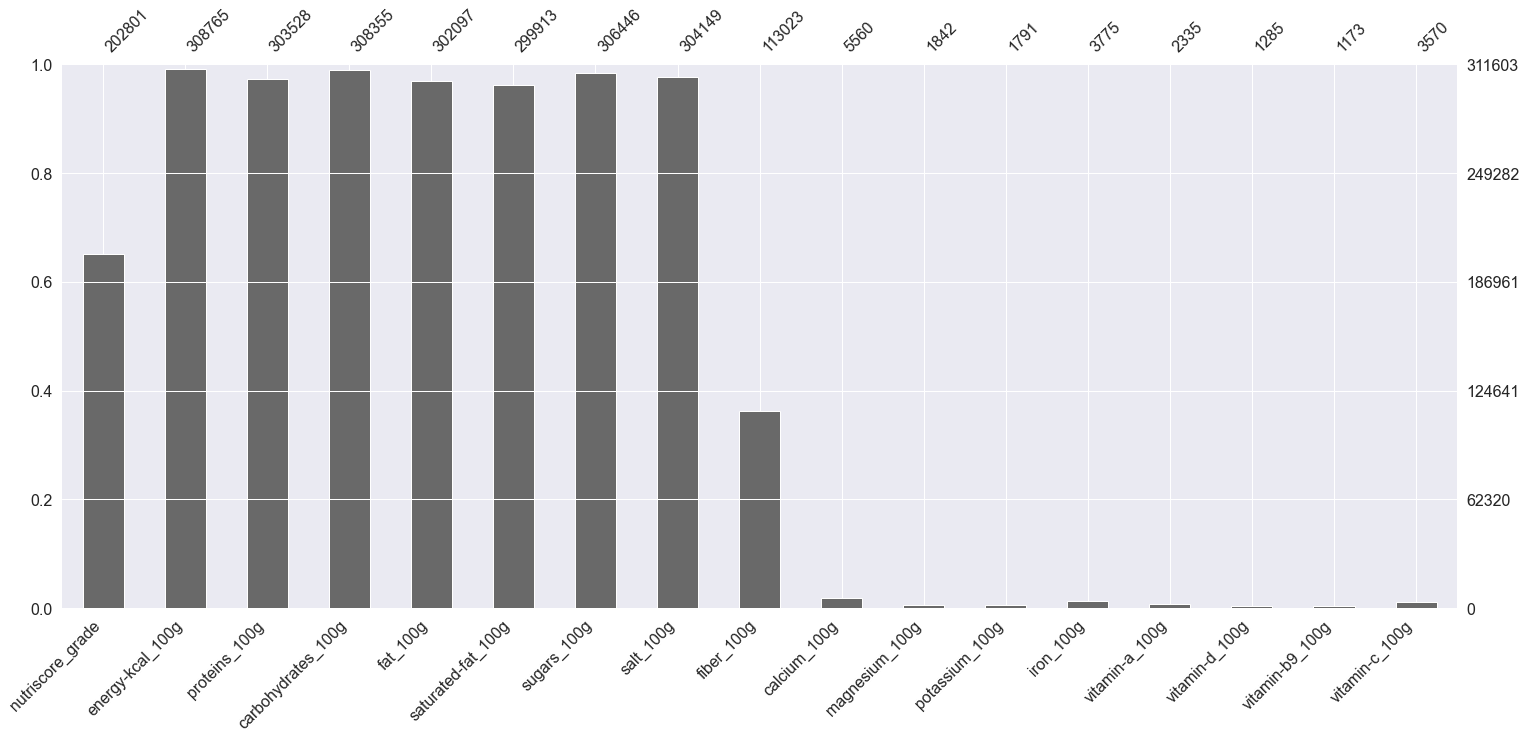

In [163]:
# Check missing data
msno.bar(df_products_missing_data)

#### RandomForestClassifier

In [164]:
# Nutriscore grade is a categorial variable
# We will use a RandomForest classifier

In [165]:

# Selection of variables for next treatments
list_features_treatments_rf = {'nutriscore_grade',
                                 'energy-kcal_100g',
                                 'proteins_100g',
                                 'carbohydrates_100g',
                                 'fat_100g',
                                 'saturated-fat_100g',
                                 'sugars_100g',
                                 'salt_100g'}


# Creating and preparing dataframe for next treatments
df_iterative_imputer = df_products_missing_data.copy()
df_iterative_imputer = df_iterative_imputer[list_features_treatments_rf]                                       
# Checking initial completion rate for nutriscore_grade column
print("Initial completion rate for nutriscore grade: (%)\n" + str(df_iterative_imputer.nutriscore_grade.notna().mean()))

Initial completion rate for nutriscore grade: (%)
0.6508313462964093


<AxesSubplot:>

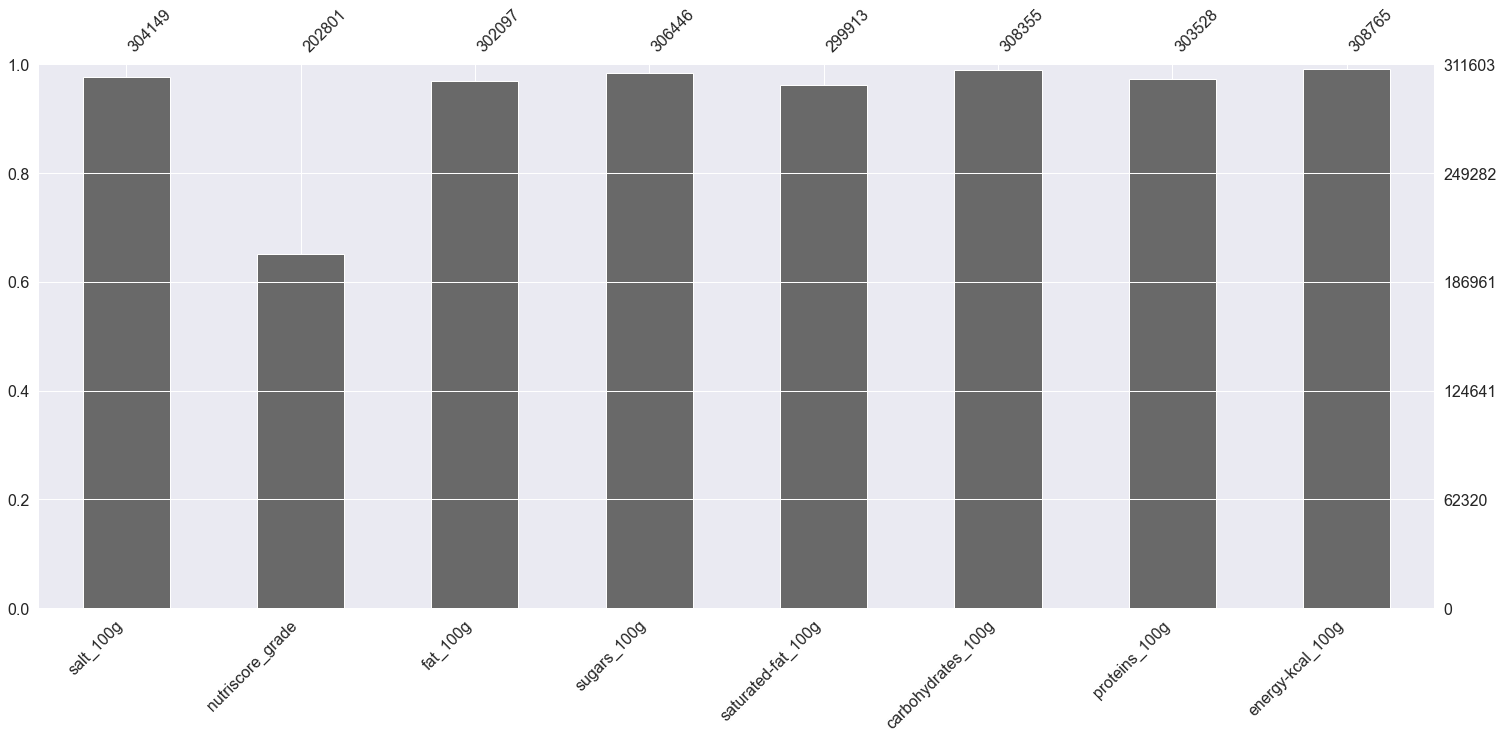

In [166]:
# Checking missing data
msno.bar(df_iterative_imputer)

In [167]:
# # Creating and preparing dataframe for next plot
df_iterative_imputer_graph = df_iterative_imputer.copy()

# Imputing missing values with "NaN" string
df_iterative_imputer_graph["nutriscore_grade"].fillna("NaN", inplace=True)

# Changing grades to uppercase for next plot
df_iterative_imputer_graph['nutriscore_grade'] = df_iterative_imputer_graph['nutriscore_grade'].apply(lambda x: x.upper())

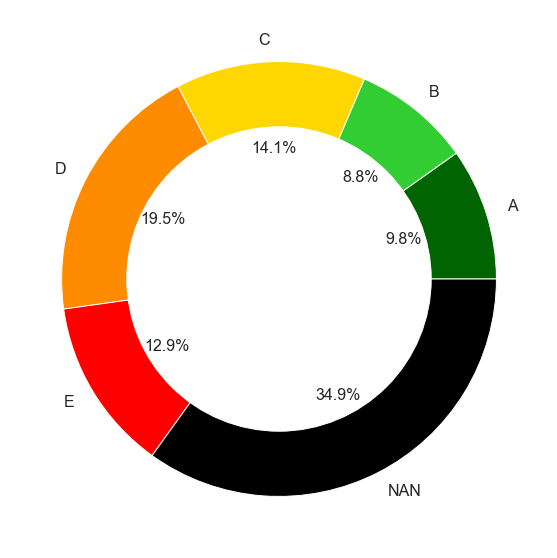

In [168]:
# Subplot
fig, ax = plt.subplots(figsize=(10,10))
fig.set_facecolor('white')

# Plot
pie = df_iterative_imputer_graph.groupby('nutriscore_grade').size()
pie.plot(kind = "pie",          
         #title = "Prodcuts nutriscore grade repartition - France",
         xlabel = "",
         ylabel= "",
         autopct = '%1.1f%%',
         colors = ["darkgreen","limegreen","gold","darkorange","red","black"],
         textprops={'fontsize': 16},
         ax = ax)

# Adding white circle for styling purposes
my_circle = plt.Circle((0,0), 0.7, color='white')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

<AxesSubplot:>

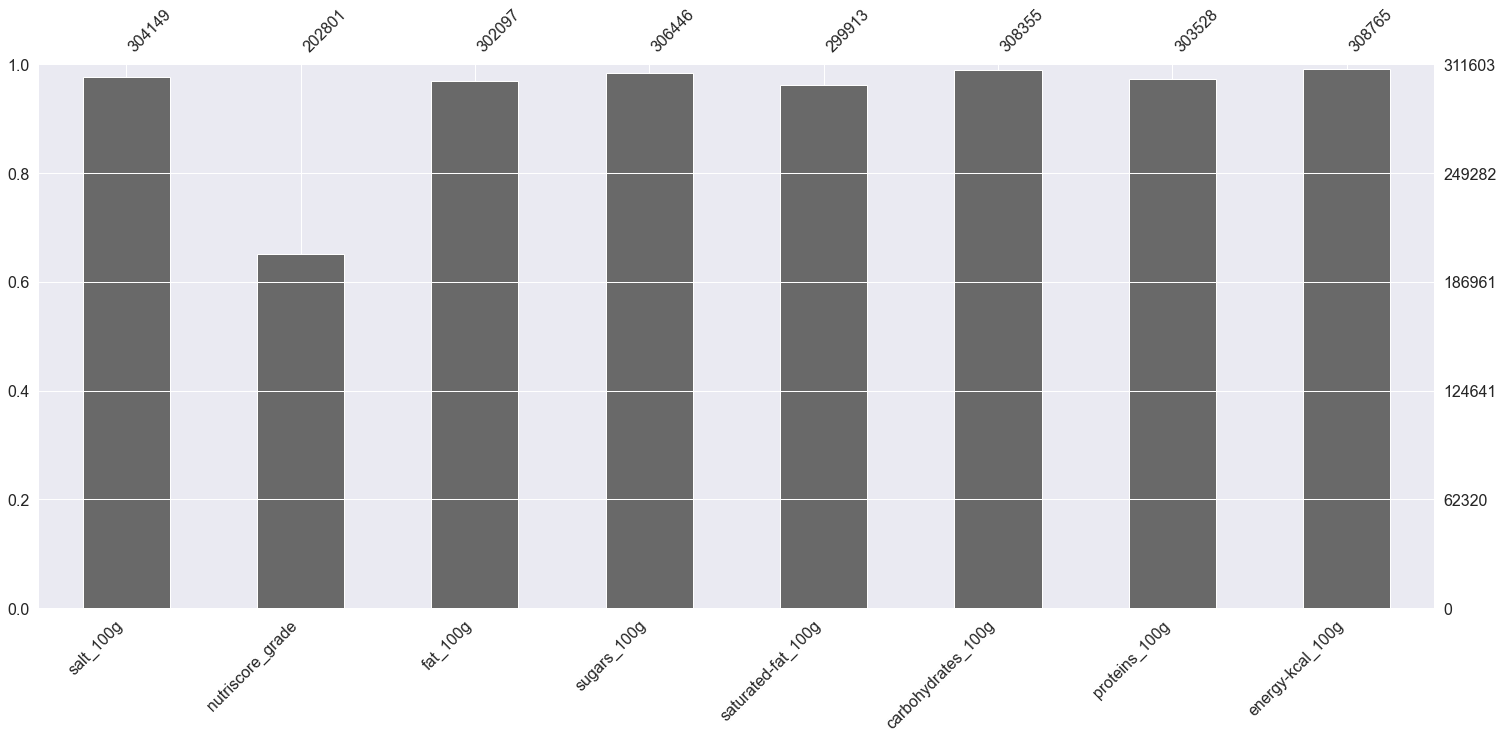

In [169]:
msno.bar(df_iterative_imputer)

In [170]:
# Create a training dataframe fully filled for input columns as well as for the target column
df_products_missing_data_iterativeimputer_training = df_iterative_imputer.dropna(axis = 0, how = 'any')

# Separate input and target values
X = df_products_missing_data_iterativeimputer_training.drop(columns=['nutriscore_grade'])
y = df_products_missing_data_iterativeimputer_training['nutriscore_grade']

# Split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Define modeling pipeline
model = RandomForestClassifier()
imputer = IterativeImputer()
pipeline = Pipeline(steps=[('imputer', imputer), ('model', model)])

# fit the model
pipeline.fit(X_train, y_train)

# Define model evaluation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# Evaluate model
scores = cross_val_score(pipeline, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean Accuracy: 0.774 (0.004)


In [171]:
# Prediction
# Define new data
x_input = df_iterative_imputer.drop(columns=['nutriscore_grade']).values

# Make prediction
output_predicted_column = pipeline.predict(x_input)

# Show predicted values
output_predicted_column

array(['a', 'd', 'b', ..., 'e', 'e', 'b'], dtype=object)

##### Update of initial dataframe with predicted values

In [172]:
# Updating dataframe 
df_iterative_imputer['nutriscore_grade'] = output_predicted_column

# Changing grades to uppercase
df_iterative_imputer['nutriscore_grade'] = df_iterative_imputer['nutriscore_grade'].apply(lambda x: x.upper())

# Checking completion rate 
final_completion_rate_nutriscore_grade = df_iterative_imputer.nutriscore_grade.notna().mean()
print("Final completion rate for nutriscore grade: (%)\n" + str(final_completion_rate_nutriscore_grade*100))


Final completion rate for nutriscore grade: (%)
100.0


<AxesSubplot:>

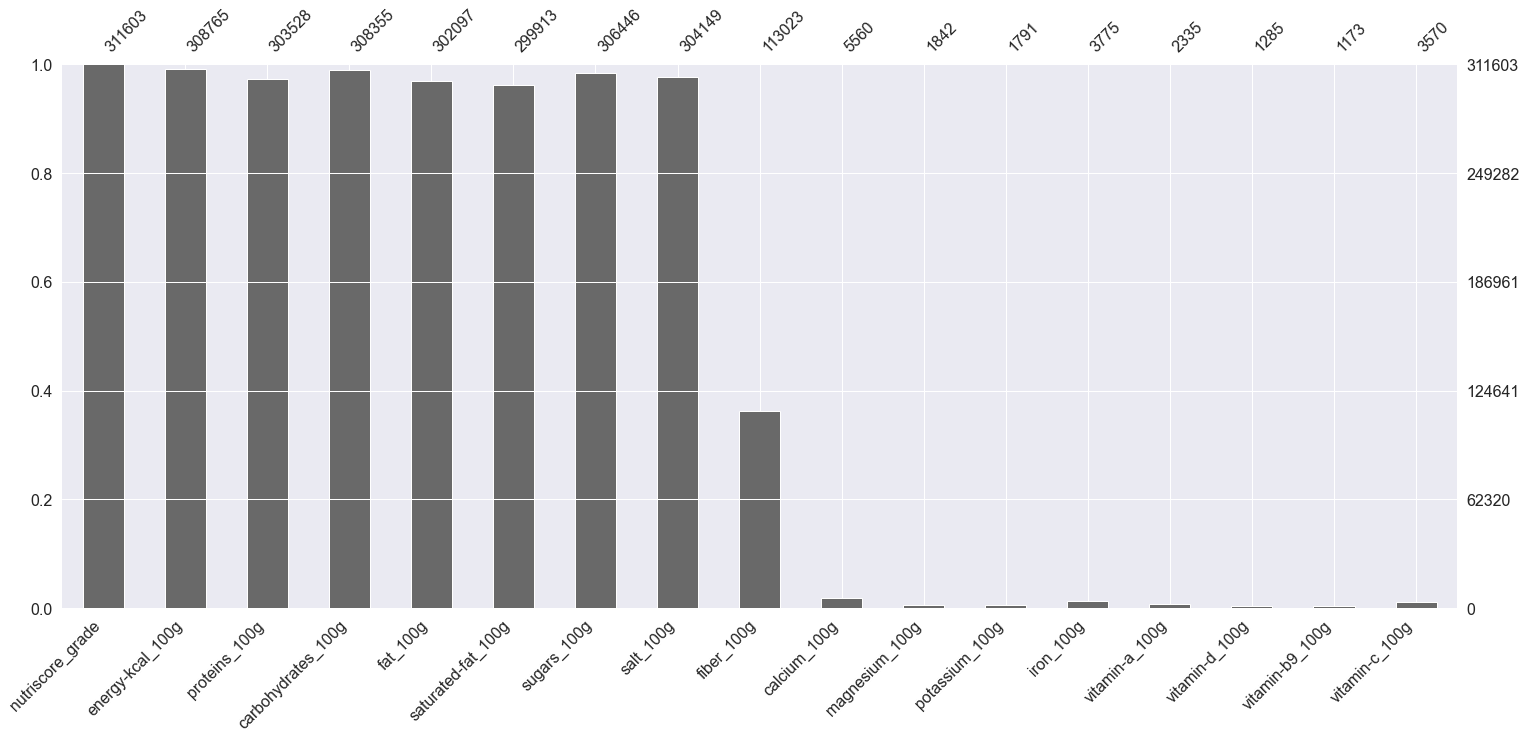

In [173]:
# Update datframe with previous datframe
df_products_missing_data.nutriscore_grade.fillna(df_iterative_imputer.nutriscore_grade, inplace = True)

# Show missing data
msno.bar(df_products_missing_data)

In [174]:
# Check dataframe stats
info(df_products_missing_data)

17 columns
311603 rows
Rate of missing values in df : 51.31040609553899 %


##### Graph repartition of predicted grades

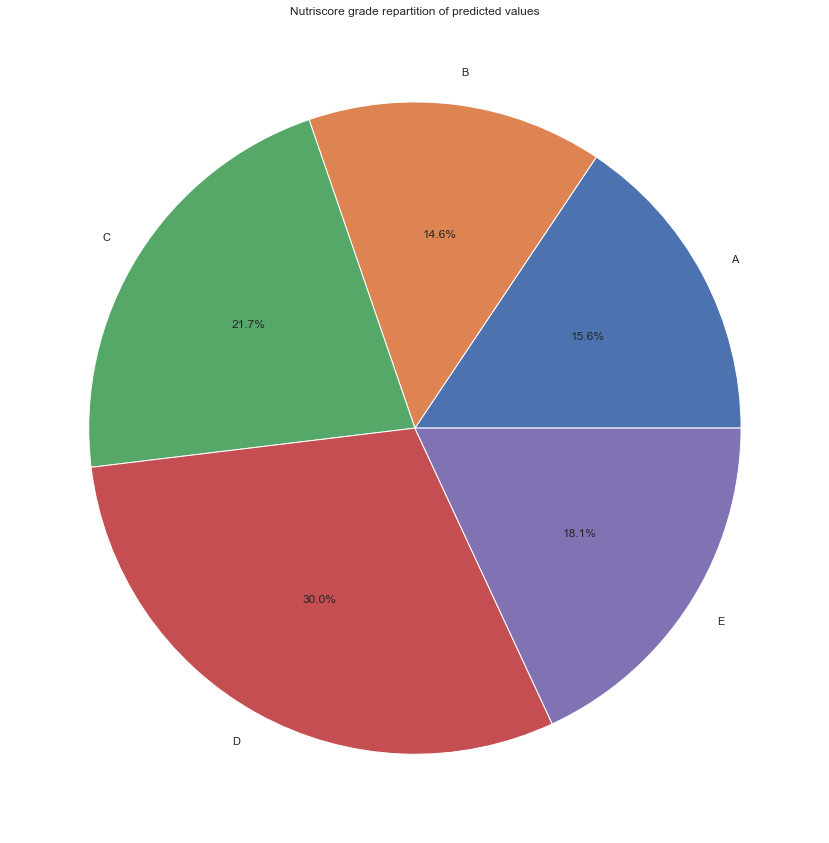

In [175]:
# Convert array to dataframe
dfx = pd.DataFrame(data=df_iterative_imputer['nutriscore_grade'].tolist())

#Plot
piex = dfx.groupby(0).size()
piex.plot(kind="pie",  autopct = '%1.1f%%')
plt.title("Nutriscore grade repartition of predicted values")
plt.ylabel("")
plt.show()


##### Confusion matrix

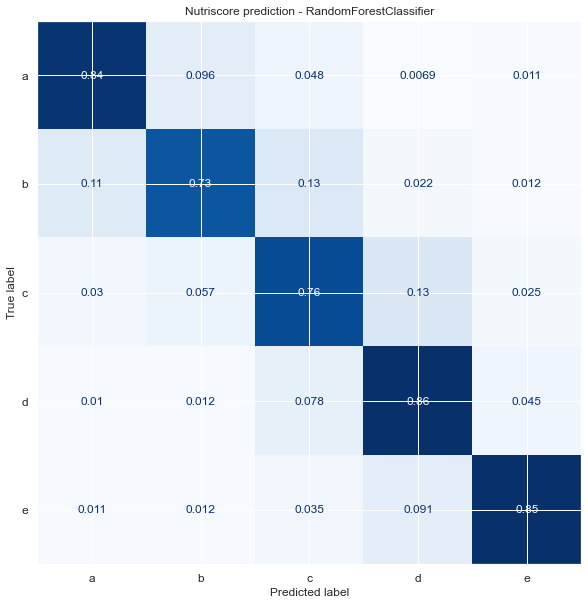

In [176]:
# Confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = plot_confusion_matrix(pipeline, X_test, y_test, cmap='Blues', normalize='true', values_format='.2g', ax=ax, colorbar=False)

# Parameters
disp.ax_.set_title("Nutriscore prediction - RandomForestClassifier")
ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

##### Classification Report

In [177]:
#
y_true = y_test
y_pred = pipeline.predict(X_test)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           a       0.83      0.84      0.83      6193
           b       0.75      0.73      0.74      5430
           c       0.76      0.76      0.76      8526
           d       0.83      0.86      0.84     11079
           e       0.87      0.85      0.86      6924

    accuracy                           0.81     38152
   macro avg       0.81      0.81      0.81     38152
weighted avg       0.81      0.81      0.81     38152



In [178]:
# Checking rate of missing values per column after treatment
list_final_rate_of_missing_values_knn_rf = df_products_missing_data.notna().mean()
print("Columns completion rate after KNN treatment: (%)\n" + str(list_final_rate_of_missing_values_knn_rf*100) + "\n\n")

# Checking improvement rate of missing value per columns after treatment
print("Columns completion rate improvement after KNN treatment: (+%)\n" + str((list_final_rate_of_missing_values_knn_rf - list_initial_rate_of_missing_values)*100/list_initial_rate_of_missing_values))


Columns completion rate after KNN treatment: (%)
nutriscore_grade      100.000000
energy-kcal_100g       99.089226
proteins_100g          97.408562
carbohydrates_100g     98.957648
fat_100g               96.949323
saturated-fat_100g     96.248431
sugars_100g            98.345010
salt_100g              97.607854
fiber_100g             36.271474
calcium_100g            1.784322
magnesium_100g          0.591137
potassium_100g          0.574770
iron_100g               1.211477
vitamin-a_100g          0.749351
vitamin-d_100g          0.412384
vitamin-b9_100g         0.376441
vitamin-c_100g          1.145689
dtype: float64


Columns completion rate improvement after KNN treatment: (+%)
nutriscore_grade      53.649637
energy-kcal_100g       0.000000
proteins_100g          1.839997
carbohydrates_100g     0.000000
fat_100g               1.777159
saturated-fat_100g     5.734220
sugars_100g            7.524912
salt_100g              6.320897
fiber_100g             0.000000
calcium_100g           

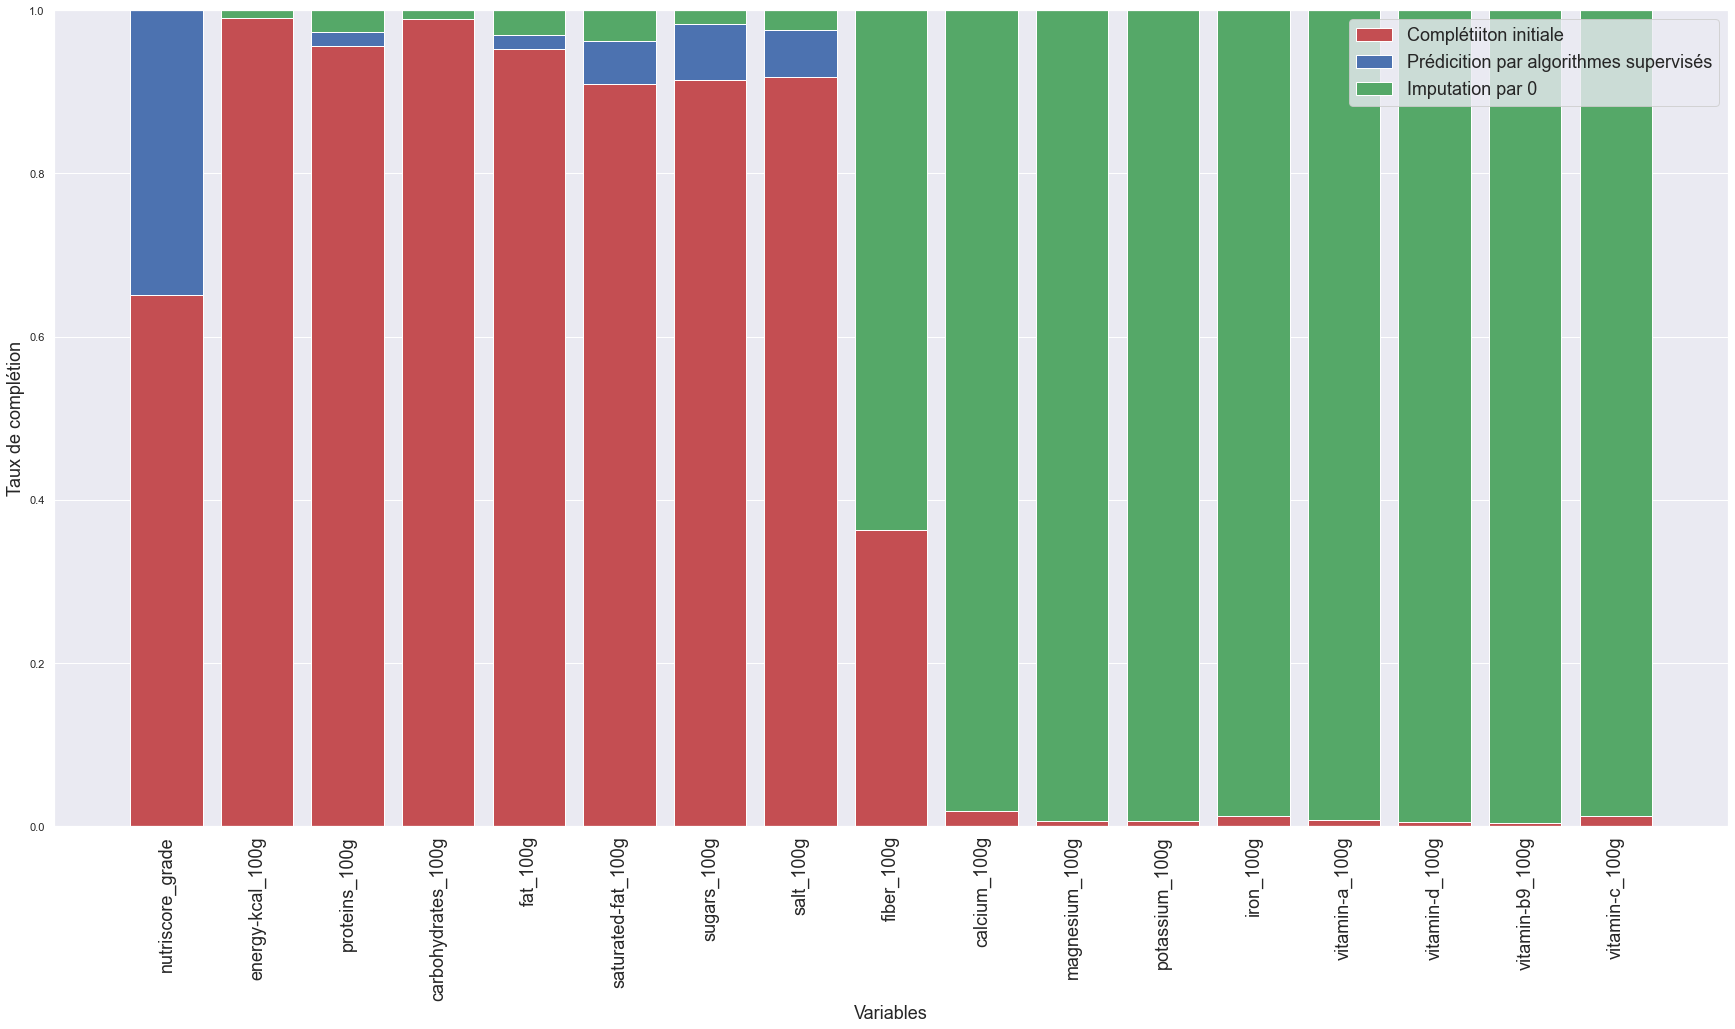

In [179]:
# Create data
x = ['nutriscore_grade',
        'energy-kcal_100g',      
        'proteins_100g',        
        'carbohydrates_100g',    
        'fat_100g',             
        'saturated-fat_100g',    
        'sugars_100g',           
        'salt_100g',             
        'fiber_100g',            
        'calcium_100g',          
        'magnesium_100g',        
        'potassium_100g',        
        'iron_100g',             
        'vitamin-a_100g',        
        'vitamin-d_100g',        
        'vitamin-b9_100g',       
        'vitamin-c_100g'  
    ]

# Prepare data
y1 = list_final_rate_of_missing_values_knn_rf
y2 = list_initial_rate_of_missing_values
y3 = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1] 

# plot bars in stack manner
plt.rcParams["figure.figsize"] = (30,15)
plt.xticks(rotation='vertical', fontsize=18)
plt.bar(x, y1, color='r')
plt.bar(x, y2-y1, bottom=y1, color='b')
plt.bar(x, y3-y1, bottom=y1, color='g')
plt.xlabel("Variables", fontsize=18)
plt.ylabel("Taux de complétion", fontsize=18)

#plt.ylabel("Completion rate")
plt.legend(["Complétiiton initiale", "Prédicition par algorithmes supervisés", "Imputation par 0"], fontsize=18)
#plt.legend(["Initial completion", "Predicition by machine learning algorithms", "Imputation by 0"])
plt.title("")
plt.show()

#### Imputation by 0 

##### Fiber & Vitamins 

In [180]:
# Selecting fiber and vitamins columns
df_products_missing_data_vitamins = df_products_missing_data[['fiber_100g','vitamin-a_100g','vitamin-d_100g','vitamin-b9_100g','vitamin-c_100g']].copy(deep=True)

# Show
df_products_missing_data_vitamins

fiber_100g  \
code          product_name                brands                  countries               
0000000001199 Solène céréales poulet      CROUS                   France            2.8   
0000000001281 Tarte noix de coco          Crous Resto',Crous      France            4.4   
0000000001663 Crème dessert chocolat      Ferme De La Frémondière France            NaN   
0000000001885 Compote de poire            Crous                   France            3.6   
0000000002264 Baguette Poitevin           Crous resto             France            1.7   
...                                                                                 ...   
9996980313319 cup noodles                 nissin                  France            0.0   
9999200847366 Choco pearls                Cara                    France            0.0   
9999900002553 Chocolat de Couverture Noir Barry                   France            NaN   
9999900401301 Kabanos                     Tarczynski              France            NaN   
9999991149090 Riz parfumé                 King Elephant           France            NaN   

                                                                             vitamin-a_100g  \
code          product_name                brands                  countries                   
0000000001199 Solène céréales poulet      CROUS                   France                NaN   
0000000001281 Tarte noix de coco          Crous Resto',Crous      France                NaN   
0000000001663 Crème dessert chocolat      Ferme De La Frémondière France                NaN   
0000000001885 Compote de poire            Crous                   France                NaN   
0000000002264 Baguette Poitevin           Crous resto             France                NaN   
...                                                                                     ...   
9996980313319 cup noodles                 nissin                  France                NaN   
9999200847366 Choco pearls                Cara                    France                NaN   
9999900002553 Chocolat de Couverture Noir Barry                   France                NaN   
9999900401301 Kabanos                     Tarczynski              France                NaN   
9999991149090 Riz parfumé                 King Elephant           France                NaN   

                                                                             vitamin-d_100g  \
code          product_name                brands                  countries                   
0000000001199 Solène céréales poulet      CROUS                   France                NaN   
0000000001281 Tarte noix de coco          Crous Resto',Crous      France                NaN   
0000000001663 Crème dessert chocolat      Ferme De La Frémondière France                NaN   
0000000001885 Compote de poire            Crous                   France                NaN   
0000000002264 Baguette Poitevin           Crous resto             France                NaN   
...                                                                                     ...   
9996980313319 cup noodles                 nissin                  France                NaN   
9999200847366 Choco pearls                Cara                    France                NaN   
9999900002553 Chocolat de Couverture Noir Barry                   France                NaN   
9999900401301 Kabanos                     Tarczynski              France                NaN   
9999991149090 Riz parfumé                 King Elephant           France                NaN   

                                                                             vitamin-b9_100g  \
code          product_name                brands                  countries                    
0000000001199 Solène céréales poulet      CROUS                   France                 NaN   
0000000001281 Tarte noix de coco          Crous Resto',Crous      France                 NaN   
0000000001663 Crème dessert chocolat 

<AxesSubplot:>

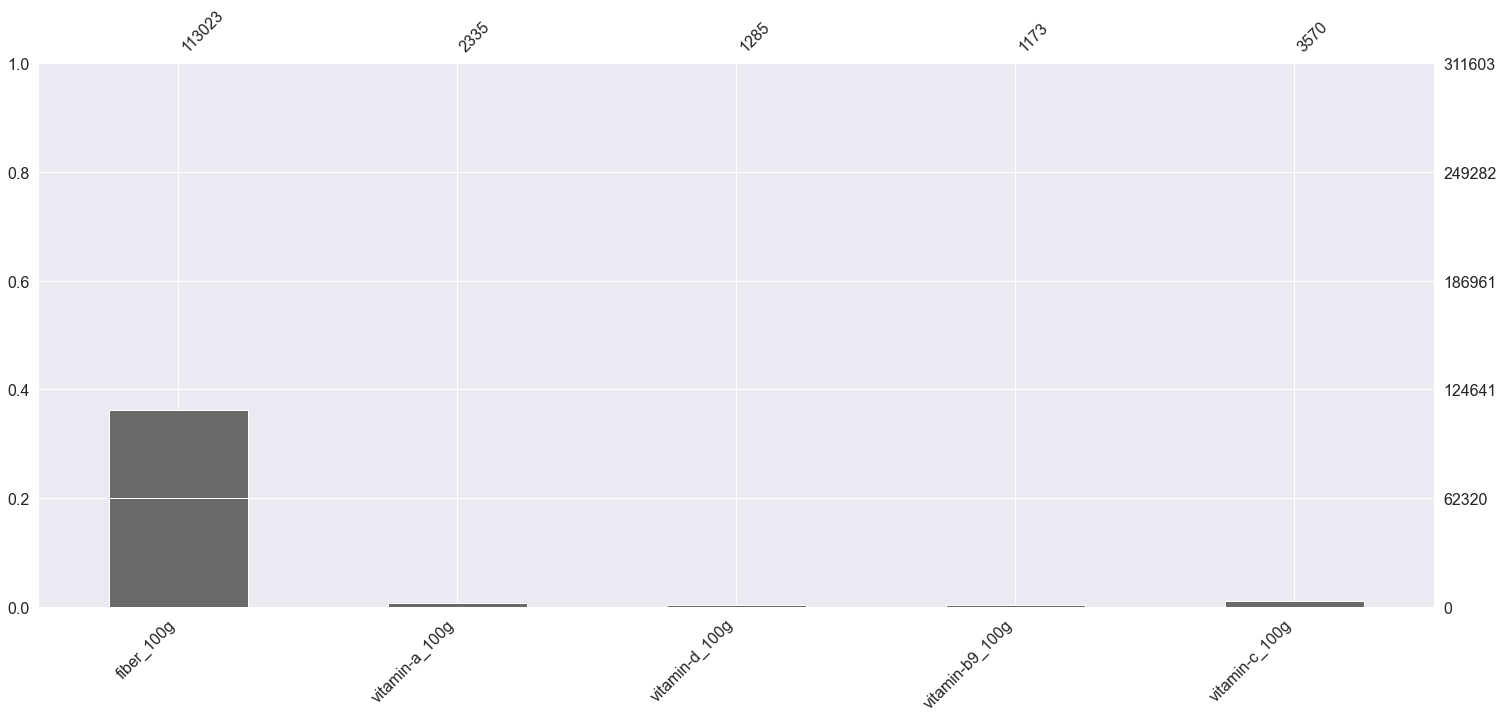

In [181]:
# Checking missing data
msno.bar(df_products_missing_data_vitamins)

In [182]:
# Imputation by 0
df_products_missing_data_vitamins.fillna(0, inplace = True)


##### Minerals: calcium_100g, magnesium_100g, potassium_100g, iron_100g

In [183]:
# Selecting minerals columns
df_products_missing_data_cmpi = df_products_missing_data[['calcium_100g','magnesium_100g','potassium_100g','iron_100g']].copy(deep=True)

# Show
df_products_missing_data_cmpi

calcium_100g  \
code          product_name                brands                  countries                 
0000000001199 Solène céréales poulet      CROUS                   France              NaN   
0000000001281 Tarte noix de coco          Crous Resto',Crous      France              NaN   
0000000001663 Crème dessert chocolat      Ferme De La Frémondière France              NaN   
0000000001885 Compote de poire            Crous                   France              NaN   
0000000002264 Baguette Poitevin           Crous resto             France              NaN   
...                                                                                   ...   
9996980313319 cup noodles                 nissin                  France              NaN   
9999200847366 Choco pearls                Cara                    France              NaN   
9999900002553 Chocolat de Couverture Noir Barry                   France              NaN   
9999900401301 Kabanos                     Tarczynski              France              NaN   
9999991149090 Riz parfumé                 King Elephant           France              NaN   

                                                                             magnesium_100g  \
code          product_name                brands                  countries                   
0000000001199 Solène céréales poulet      CROUS                   France                NaN   
0000000001281 Tarte noix de coco          Crous Resto',Crous      France                NaN   
0000000001663 Crème dessert chocolat      Ferme De La Frémondière France                NaN   
0000000001885 Compote de poire            Crous                   France                NaN   
0000000002264 Baguette Poitevin           Crous resto             France                NaN   
...                                                                                     ...   
9996980313319 cup noodles                 nissin                  France                NaN   
9999200847366 Choco pearls                Cara                    France                NaN   
9999900002553 Chocolat de Couverture Noir Barry                   France                NaN   
9999900401301 Kabanos                     Tarczynski              France                NaN   
9999991149090 Riz parfumé                 King Elephant           France                NaN   

                                                                             potassium_100g  \
code          product_name                brands                  countries                   
0000000001199 Solène céréales poulet      CROUS                   France                NaN   
0000000001281 Tarte noix de coco          Crous Resto',Crous      France                NaN   
0000000001663 Crème dessert chocolat      Ferme De La Frémondière France                NaN   
0000000001885 Compote de poire            Crous                   France                NaN   
0000000002264 Baguette Poitevin           Crous resto             France                NaN   
...                                                                                     ...   
9996980313319 cup noodles                 nissin                  France                NaN   
9999200847366 Choco pearls                Cara                    France                NaN   
9999900002553 Chocolat de Couverture Noir Barry                   France                NaN   
9999900401301 Kabanos                     Tarczynski              France                NaN   
9999991149090 Riz parfumé                 King Elephant           France                NaN   

                                                                             iron_100g  
code          product_name                brands                  countries             
0000000001199 Solène céréales poulet      CROUS                   France           NaN  
0000000001281 Tarte noix de coco          Crous Resto',Crous      France           NaN  
0000000001663 Crème dessert chocolat   

<AxesSubplot:>

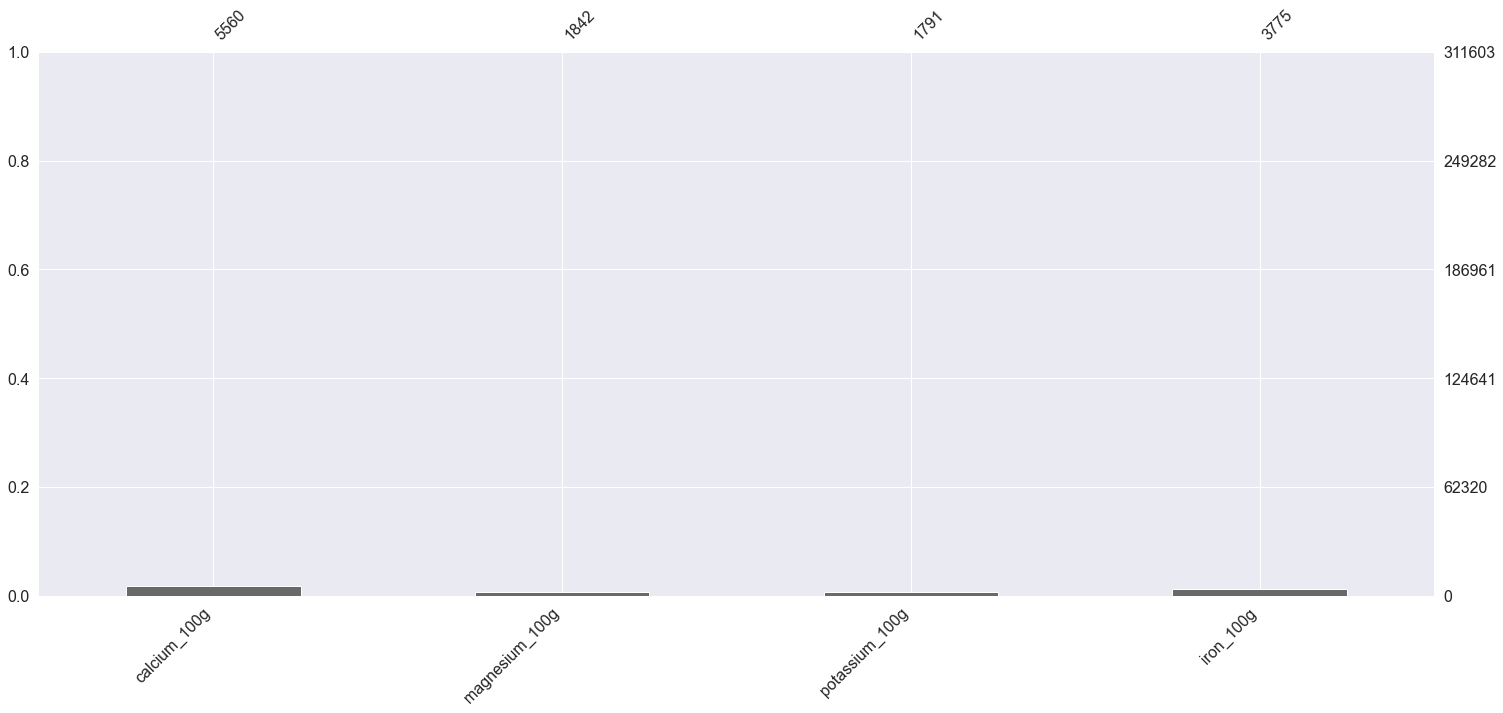

In [184]:
# Check missing data
msno.bar(df_products_missing_data_cmpi)

In [185]:
# Imputation by 0
df_products_missing_data_cmpi.fillna(0, inplace = True)

# Updating initial dataframe with new imputations
df_products_missing_data.update(df_products_missing_data_vitamins)
df_products_missing_data.update(df_products_missing_data_cmpi)


<AxesSubplot:>

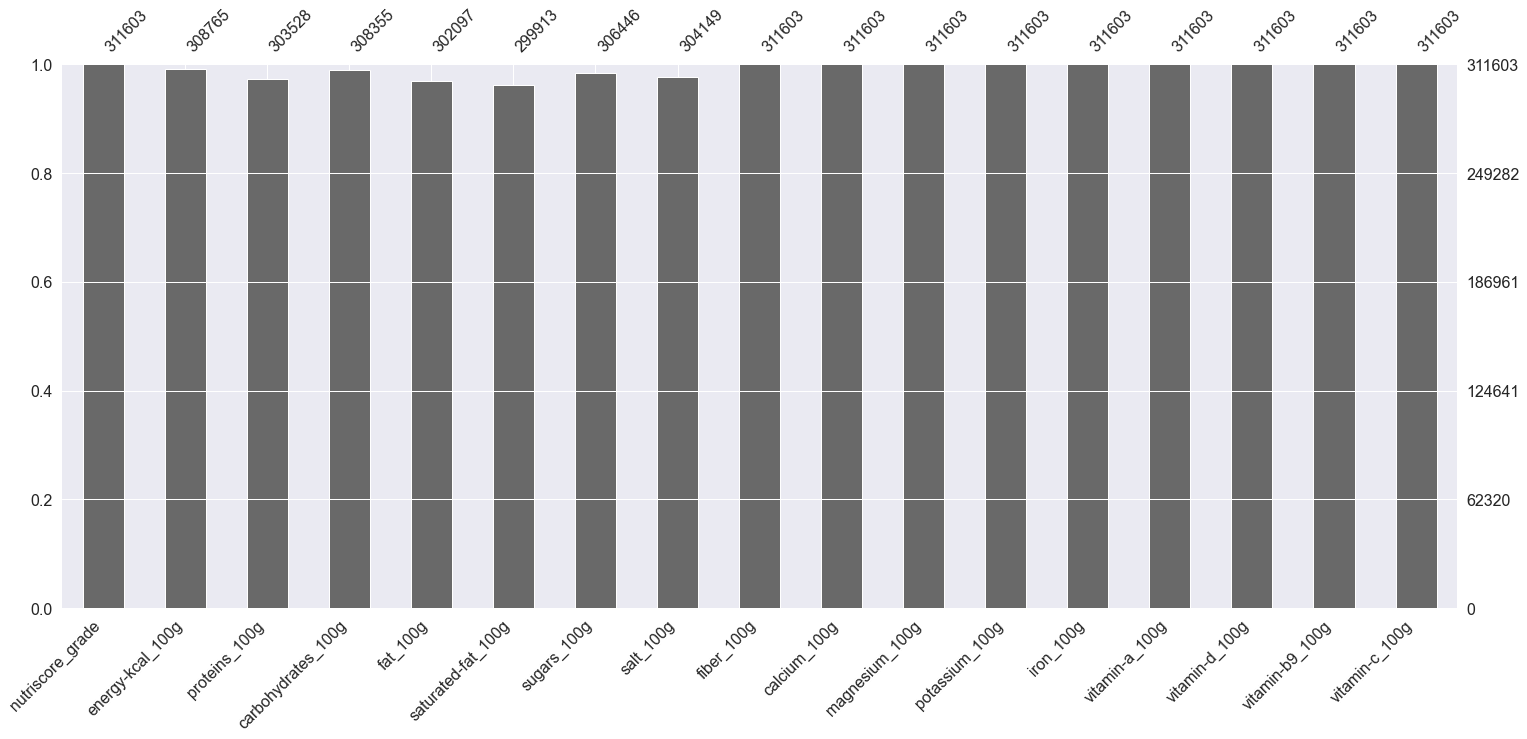

In [186]:
# Checking missing data of final dataframe
msno.bar(df_products_missing_data)

##### Predicted variables

In [187]:
###
columns = ['energy-kcal_100g','proteins_100g','carbohydrates_100g','fat_100g','saturated-fat_100g','sugars_100g','salt_100g']
for column in columns:
    df_products_missing_data[column].fillna(0, inplace=True)

#### Final completion rate

<AxesSubplot:>

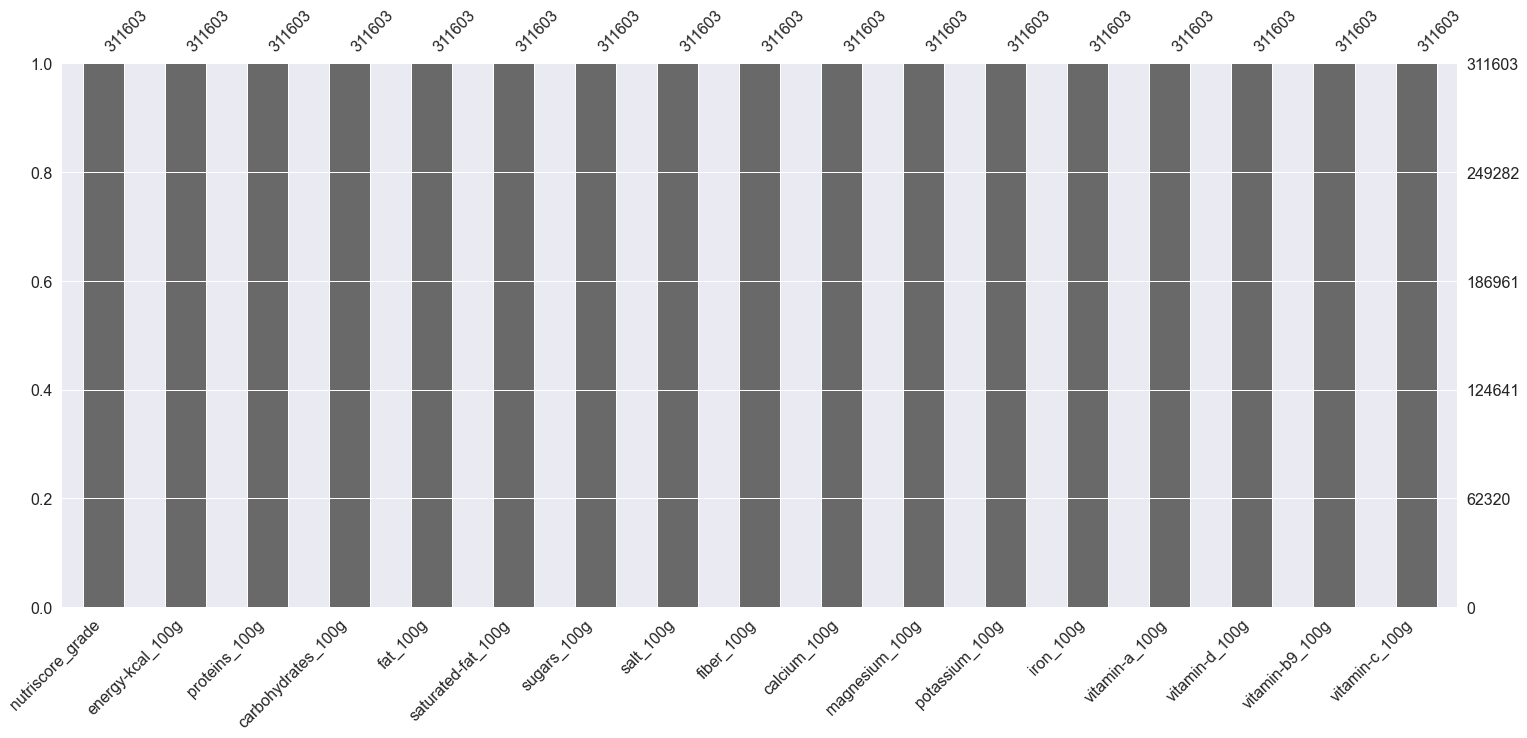

In [188]:
# Checking missing data of final dataframe
msno.bar(df_products_missing_data)

# Export dataframe (.csv file) to working directory

In [189]:
# Exporting data to working directory
# Exporting final dataframe after cleaning treatments
cwd = os.getcwd()
path = os.path.join(cwd, "df_cleaned.csv")
df_products_missing_data.to_csv(path)

# Exporting df_iterative_imputer_graph for future ANOVA analysis
path = os.path.join(cwd, "df_iterative_imputer_graph.csv")
df_iterative_imputer_graph.to_csv(path)

